# **Data Mining Project** 
# Task 2: Clustering Analysis by TimeSeriesKmeans and KMeans
Pistolesi Veronica, Poli Francesca

## Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy
import matplotlib
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

from collections import defaultdict
from scipy.stats import pearsonr
from datetime import datetime
from sklearn.preprocessing import StandardScaler

In [ ]:
!pip install --upgrade kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached kneed-0.8.1-py2.py3-none-any.whl (10 kB)


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from sklearn import metrics
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score 
from kneed import KneeLocator
from math import pi

In [ ]:
from matplotlib.pyplot import figure

In [ ]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.8/875.8 KB 16.8 MB/s eta 0:00:00


In [ ]:
from tslearn.clustering import TimeSeriesKMeans

In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tqdm import tqdm

## Data Loading and creation of useful lists

In [ ]:
tweets_scores = pd.read_csv('/content/drive/Shareddrives/DataMining/dataset/tweets_scores.csv', lineterminator='\n', index_col=False)

In [ ]:
users = pd.read_csv('/content/drive/Shareddrives/DataMining/dataset/users_profile.csv', lineterminator='\n', index_col=False)

In [ ]:
users = users[['user_id', 'bot']]

In [ ]:
tweets_scores.head()

user_id  created_at  SuccessScore  bot
0   722623  2019-01-01     -1.000000    0
1   722623  2019-01-02     -1.000000    0
2   722623  2019-01-03      1.549296    0
3   722623  2019-01-04   1626.393443    0
4   722623  2019-01-05      1.818182    0

In [ ]:
scores = tweets_scores.groupby('user_id')['SuccessScore'].apply(list)
scores.head()

user_id
722623     [-1.0, -1.0, 1.5492957746478877, 1626.39344262...
755746     [-1.0, -1.0, 0.0, 0.0, 0.0, 0.1639344262295082...
806975     [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....
887281     [-1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0...
1382561    [-1.0, -1.0, 60.0940070505288, 0.4480651731160...
Name: SuccessScore, dtype: object

In [ ]:
scores = scores.to_frame()

In [ ]:
ts_users = scores.merge(users, on='user_id')

In [ ]:
ts_users.head()

user_id                                       SuccessScore  bot
0   722623  [-1.0, -1.0, 1.5492957746478877, 1626.39344262...    0
1   755746  [-1.0, -1.0, 0.0, 0.0, 0.0, 0.1639344262295082...    0
2   806975  [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....    0
3   887281  [-1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0...    0
4  1382561  [-1.0, -1.0, 60.0940070505288, 0.4480651731160...    0

## Denoising and Normalizing TimeSeries

In [ ]:
X = ts_users["SuccessScore"].values
y = ts_users["bot"].values
y = np.int_(y)

In [ ]:
ts_all = []
for x in X:
  ts_all.append(pd.Series(x))

In [ ]:
# Time Series before denoising and normalization
X = ts_all  

In [ ]:
#Removing noise using a slinding window
def remove_noise(ts,w):
    #ts = ((ts - ts.mean())/ts.std()).rolling(window=w).mean()
    ts = ts.rolling(window=w, min_periods=1).mean()
    return ts
# Remove noise over all the dataset
ts_w7 = []
ts_w14 = []
ts_w30 = []
for ts in tqdm(X):
  ts_w7.append(remove_noise(ts, 7))
  ts_w14.append(remove_noise(ts, 14))
  ts_w30.append(remove_noise(ts, 30))



100%|██████████| 6787/6787 [00:08<00:00, 785.20it/s]


In [ ]:
# Time series after denoising
Xw7 = ts_w7     
Xw14 = ts_w14
Xw30 = ts_w30

In [ ]:
#X = ts_all

In [ ]:
#ts_all[2:4]

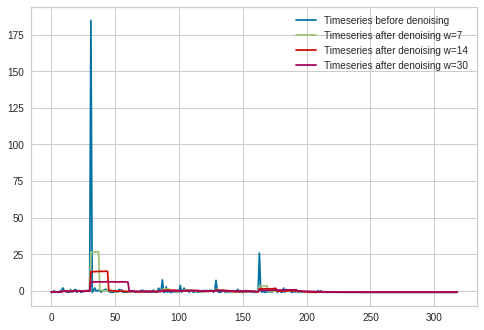

In [ ]:
ts_ex = X[5]
ts_ex_w7 = Xw7[5]
ts_ex_w14 = Xw14[5]
ts_ex_w30 = Xw30[5]

plt.plot(ts_ex, label="Timeseries before denoising")
plt.plot(ts_ex_w7, label="Timeseries after denoising w=7")
plt.plot(ts_ex_w14, label="Timeseries after denoising w=14")
plt.plot(ts_ex_w30, label="Timeseries after denoising w=30")
plt.legend()
plt.show()

In [ ]:
#Normalization
from tslearn.preprocessing import TimeSeriesScalerMinMax
scaler = TimeSeriesScalerMinMax(value_range=(0.0, 1.))  

def ts_norm(ts):
  ts_reshaped = ts.values.reshape(1, -1)
  return scaler.fit_transform(ts_reshaped).flatten()

In [ ]:
# Time series after normalization
ts_ex_n = ts_norm(ts_ex)
ts_ex_n7 = ts_norm(ts_ex_w7)
ts_ex_n14 = ts_norm(ts_ex_w14)
ts_ex_n30 = ts_norm(ts_ex_w30)

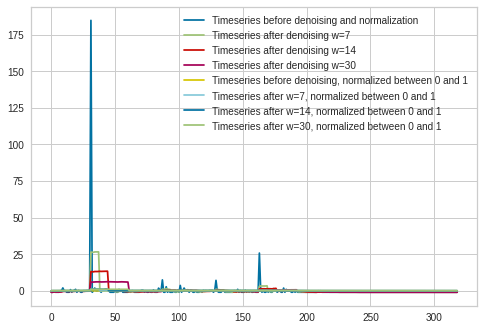

In [ ]:
plt.plot(ts_ex, label="Timeseries before denoising and normalization")
plt.plot(ts_ex_w7, label="Timeseries after denoising w=7")
plt.plot(ts_ex_w14, label="Timeseries after denoising w=14")
plt.plot(ts_ex_w30, label="Timeseries after denoising w=30")

plt.plot(ts_ex_n, label="Timeseries before denoising, normalized between 0 and 1")
plt.plot(ts_ex_n7, label="Timeseries after w=7, normalized between 0 and 1")
plt.plot(ts_ex_n14, label="Timeseries after w=14, normalized between 0 and 1")
plt.plot(ts_ex_n30, label="Timeseries after w=30, normalized between 0 and 1")

plt.legend()
plt.show()

In [ ]:
ts_n = []
ts_n7 = []
ts_n14 = []
ts_n30 = []

# Normalize all the dataset
for ts in tqdm(X):
  ts_n.append(ts_norm(ts))
for ts in tqdm(Xw7):
  ts_n7.append(ts_norm(ts))
for ts in tqdm(Xw14):
  ts_n14.append(ts_norm(ts))
for ts in tqdm(Xw30):
  ts_n30.append(ts_norm(ts))

100%|██████████| 6787/6787 [00:04<00:00, 1550.95it/s]


In [ ]:
# Time series after normalization
Xn = ts_n
Xwn7 = ts_n7   # and denoising w=7
Xwn14 = ts_n14   # and denoising w=14
Xwn30 = ts_n30   # and denoising w=30

In [ ]:
X = np.array(X)   # original time series
Xn = np.array(Xn)   # normalized time series
Xw7 = np.array(Xw7)   # denoised w=7 time series
Xwn7 = np.array(Xwn7)   # denoised w=7 and normalized time series
Xw14 = np.array(Xw14)   # denoised w=14 time series
Xwn14 = np.array(Xwn14)   # denoised w=14 and normalized time series
Xw30 = np.array(Xw30)   # denoised w=30 time series
Xwn30 = np.array(Xwn30)   # denoised w=30 and normalized time series

In [ ]:
X.shape

(6787, 319)

# Shape-based clustering

## TimeSeriesKMeans Euclidean

Parameters:
* **n_clusters** (default 8): The number of clusters
* **n_init** (default 10): Number of time TimeSeriesKMeans will be run with different initial centroids. The final results will be the best output in terms of inertia.
* **max_iter** (default 300): Maximum number of iterations of the TimeSeriesKMeans algorithm for a single run.

Output:
* **labels_**: Labels of each point
* **cluster\_centers_**: Coordinates of cluster centers
* **inertia_**: Sum of squared distances of samples to their closest cluster center.

In [ ]:
timeserieskmeans = []

timeserieskmeans2 = TimeSeriesKMeans(n_clusters=2, n_init=10, max_iter=100)
timeserieskmeans2.fit(X)
timeserieskmeans.append(timeserieskmeans2)

timeserieskmeans3 = TimeSeriesKMeans(n_clusters=2, n_init=10, max_iter=100)
timeserieskmeans3.fit(Xn)
timeserieskmeans.append(timeserieskmeans3)

timeserieskmeans4 = TimeSeriesKMeans(n_clusters=2, n_init=10, max_iter=100)
timeserieskmeans4.fit(Xw7)
timeserieskmeans.append(timeserieskmeans4)

timeserieskmeans5 = TimeSeriesKMeans(n_clusters=2, n_init=10, max_iter=100)
timeserieskmeans5.fit(Xwn7)
timeserieskmeans.append(timeserieskmeans5)

timeserieskmeans6 = TimeSeriesKMeans(n_clusters=2, n_init=10, max_iter=100)
timeserieskmeans6.fit(Xw14)
timeserieskmeans.append(timeserieskmeans6)

timeserieskmeans7 = TimeSeriesKMeans(n_clusters=2, n_init=10, max_iter=100)
timeserieskmeans7.fit(Xwn14)
timeserieskmeans.append(timeserieskmeans7)

timeserieskmeans8 = TimeSeriesKMeans(n_clusters=2, n_init=10, max_iter=100)
timeserieskmeans8.fit(Xw30)
timeserieskmeans.append(timeserieskmeans8)

timeserieskmeans9 = TimeSeriesKMeans(n_clusters=2, n_init=10, max_iter=100)
timeserieskmeans9.fit(Xwn30)
timeserieskmeans.append(timeserieskmeans9)

Labels

In [ ]:
for i in range(len(timeserieskmeans)):
  print(timeserieskmeans[i].labels_[:5])

[0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0]
[1 1 1 1 1]
[0 0 0 0 0]
[1 1 1 1 1]
[0 0 0 0 0]
[1 0 0 1 1]


Observing the size of each cluster

In [ ]:
for i in range(len(timeserieskmeans)):
  print(np.unique(timeserieskmeans[i].labels_, return_counts=True))

(array([0, 1]), array([6786,    1]))
(array([0, 1]), array([6565,  222]))
(array([0, 1]), array([6786,    1]))
(array([0, 1]), array([3221, 3566]))
(array([0, 1]), array([6786,    1]))
(array([0, 1]), array([3565, 3222]))
(array([0, 1]), array([6786,    1]))
(array([0, 1]), array([4577, 2210]))


In [ ]:
for i in range(len(timeserieskmeans)):
  hist, bins = np.histogram(timeserieskmeans[i].labels_, bins=range(0, len(set(timeserieskmeans[i].labels_)) + 1))
  print(dict(zip(bins, hist)))

{0: 6786, 1: 1}
{0: 6565, 1: 222}
{0: 6786, 1: 1}
{0: 3221, 1: 3566}
{0: 6786, 1: 1}
{0: 3565, 1: 3222}
{0: 6786, 1: 1}
{0: 4577, 1: 2210}


### Centers

In [ ]:
for i in range(len(timeserieskmeans)):
  print(timeserieskmeans[i].cluster_centers_)
  print("------------------------")

[[[-2.12022621e-01]
  [ 3.19199325e-01]
  [ 3.81198763e+01]
  [ 5.59035788e+01]
  [ 1.27410501e+02]
  [ 2.89303510e+01]
  [ 2.17331451e+01]
  [ 3.81685496e+01]
  [ 2.43248433e+01]
  [ 3.47818973e+01]
  [ 2.10907602e+01]
  [ 2.12324282e+01]
  [ 2.63340567e+01]
  [ 2.82208633e+01]
  [ 3.83495421e+01]
  [ 1.97824915e+01]
  [ 2.02790673e+01]
  [ 1.68767477e+01]
  [ 2.47403332e+01]
  [ 3.12243123e+01]
  [ 4.66216282e+01]
  [ 2.90044827e+01]
  [ 6.88509283e+01]
  [ 2.50570834e+01]
  [ 7.17536119e+01]
  [ 1.50966172e+02]
  [ 4.95949407e+01]
  [ 4.17148187e+01]
  [ 6.17137673e+01]
  [ 2.09995696e+01]
  [ 2.84625331e+01]
  [ 3.80176627e+01]
  [ 3.09920124e+01]
  [ 1.19432989e+02]
  [ 4.69183565e+01]
  [ 4.75322303e+01]
  [ 4.59428948e+01]
  [ 2.63234849e+01]
  [ 2.80549050e+01]
  [ 4.73360964e+01]
  [ 5.66582751e+01]
  [ 7.49846724e+01]
  [ 6.20484903e+01]
  [ 2.86576909e+01]
  [ 3.45102362e+01]
  [ 4.62124232e+01]
  [ 1.27870658e+02]
  [ 1.38251391e+02]
  [ 1.43344987e+02]
  [ 1.12451456e+02]


### Visualization of clusters centers by means of parallel coordinates

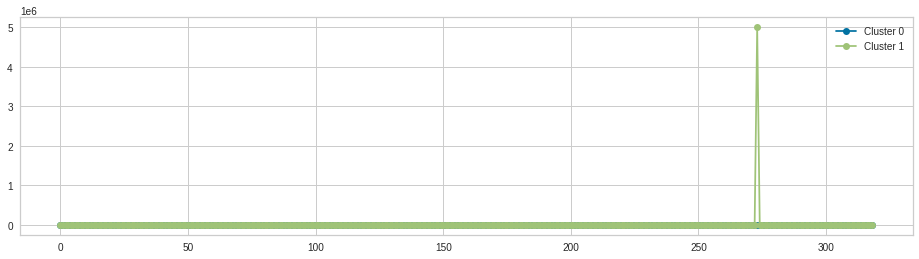

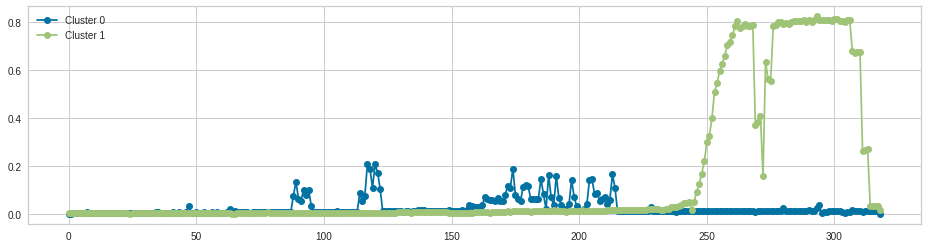

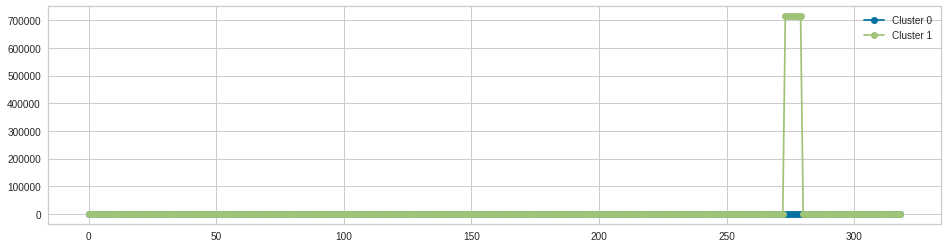

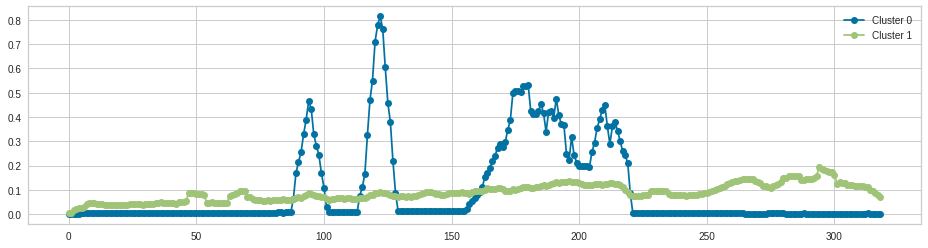

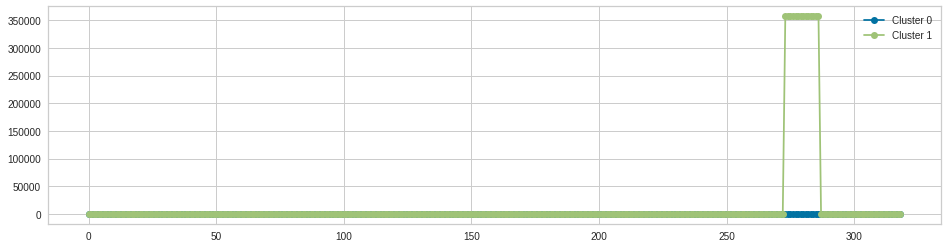

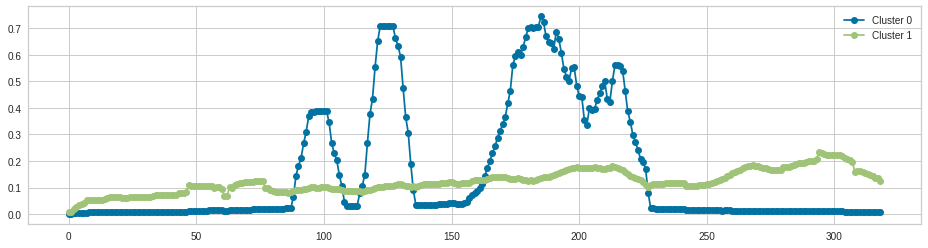

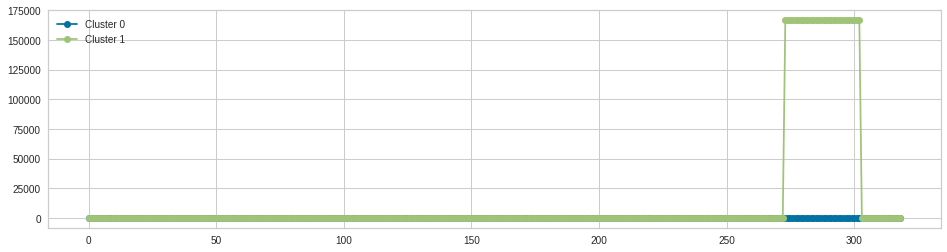

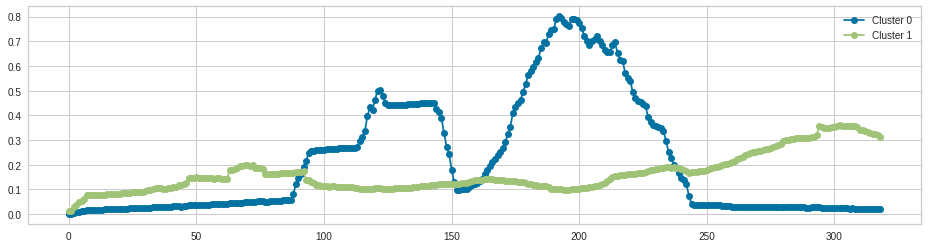

In [ ]:
for ii in range(len(timeserieskmeans)):
  plt.figure(figsize=(16, 4))
  for i in range(0, len(timeserieskmeans[ii].cluster_centers_)):
      plt.plot(timeserieskmeans[ii].cluster_centers_[i], marker='o', label='Cluster %s' % i)
  plt.tick_params(axis='both', which='major', labelsize=10)
  #plt.xticks(range(0, len(X.columns)), X.columns, fontsize=8)
  plt.legend(fontsize=10)
  plt.show()

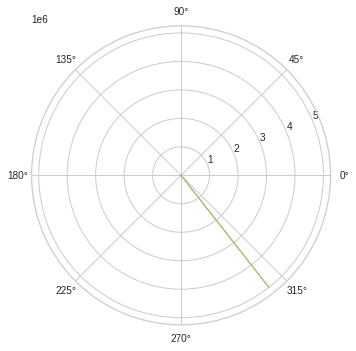

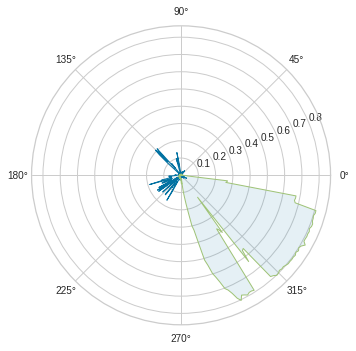

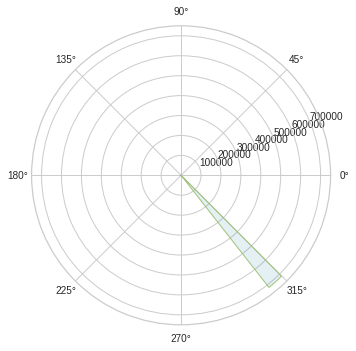

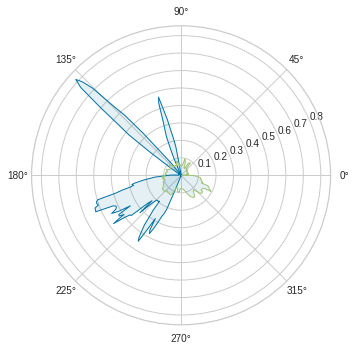

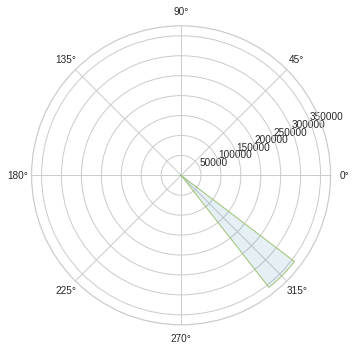

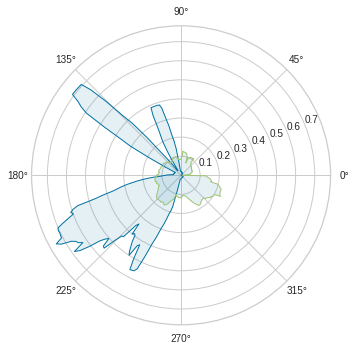

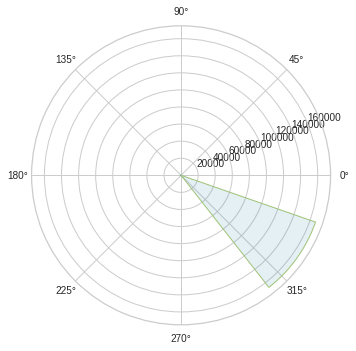

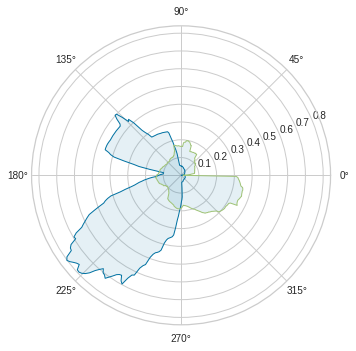

In [ ]:
for ii in range(len(timeserieskmeans)):
  # number of variable
  N = 319
  # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
  for i in range(0, len(timeserieskmeans[ii].cluster_centers_)):
      angles = [n / float(N) * 2 * pi for n in range(N)]
      values = timeserieskmeans[ii].cluster_centers_[i].tolist()
      values += values[:1]
      angles += angles[:1]
  # Initialise the spider plot
      ax = plt.subplot(polar=True)
  # Draw one axe per variable + add labels labels yet
      #plt.xticks(angles[:-1], X.columns, color='grey', size=8) 
  # Plot data
      ax.plot(angles, values, linewidth=1, linestyle='solid')
  # Fill area
      ax.fill(angles, values, 'b', alpha=0.1)
  plt.show()

### Clusters characterization

In [ ]:
users_profile_all = pd.read_csv('/content/drive/Shareddrives/DataMining/dataset/users_profile.csv', lineterminator='\n')

In [ ]:
users_profile_all = users_profile_all.merge(ts_users, on='user_id')

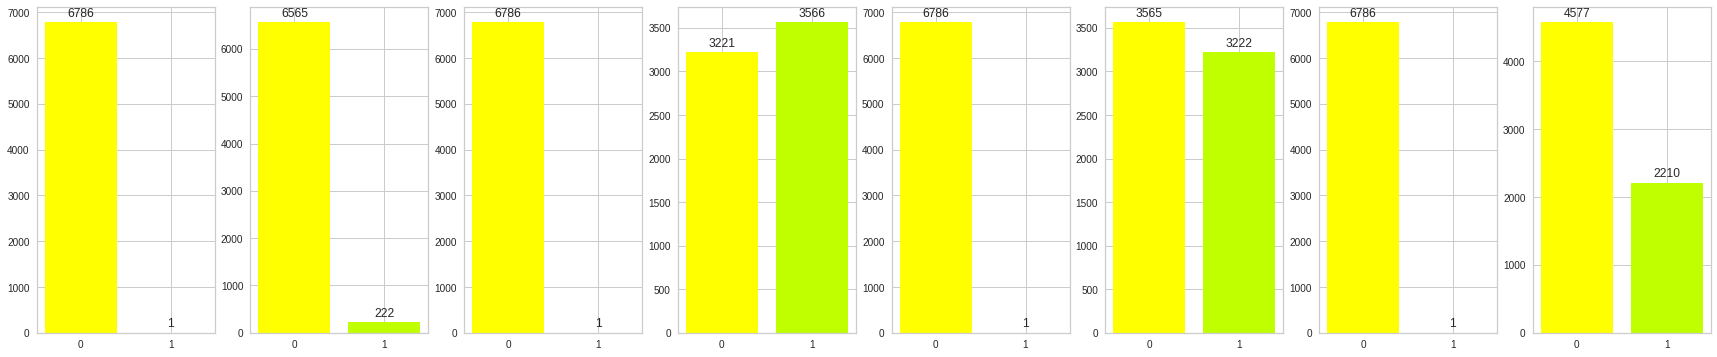

In [ ]:
fig, ax = plt.subplots(ncols=len(timeserieskmeans), figsize=(30,6))
for i in range(len(timeserieskmeans)):
  hist, bins = np.histogram(timeserieskmeans[i].labels_, bins=range(0, len(set(timeserieskmeans[i].labels_)) + 1))
  #plt.stairs(hist, bins)
  clusters = ax[i].bar(range(len(dict(zip(bins, hist)))), list(dict(zip(bins, hist)).values()), align='center', color=['#ffff00', '#bfff00', '#00ff40', '#00ff80', '#00ffbf', '#00ffff', '#00bfff', '#0080ff', '#0040ff', '#0000ff', '#4000ff', '#8000ff', '#bf00ff', '#ff00ff', '#ff00bf', '#ff0080', '#ff0040', '#ff0000', '#756bb1'])
  ax[i].set_xticks(range(len(dict(zip(bins, hist)))), list(dict(zip(bins, hist)).keys()))
  ax[i].bar_label(clusters, padding=3)
plt.show()

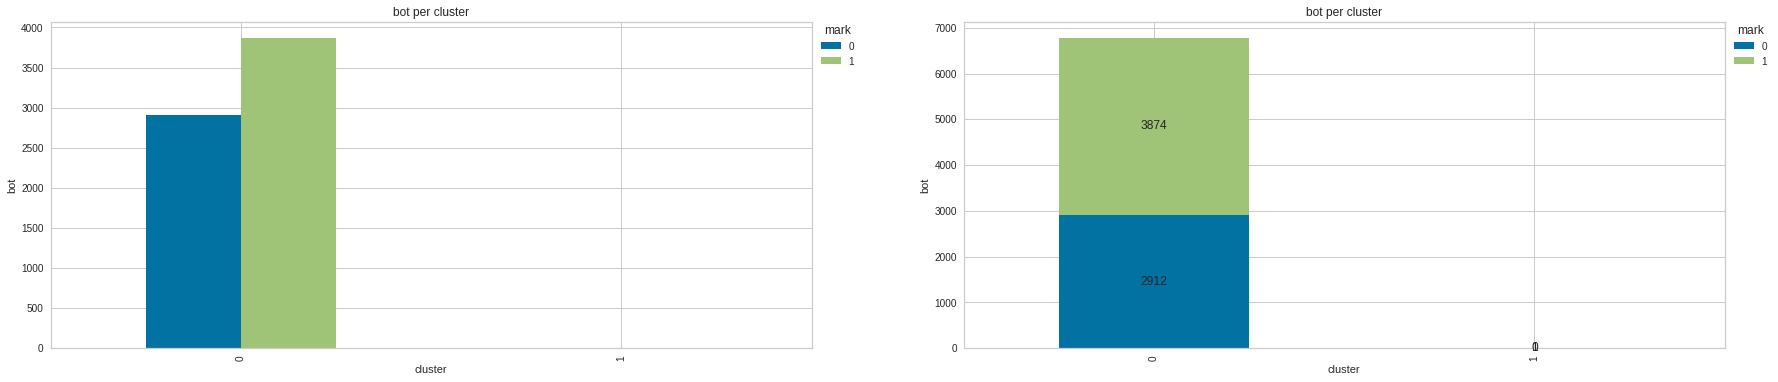

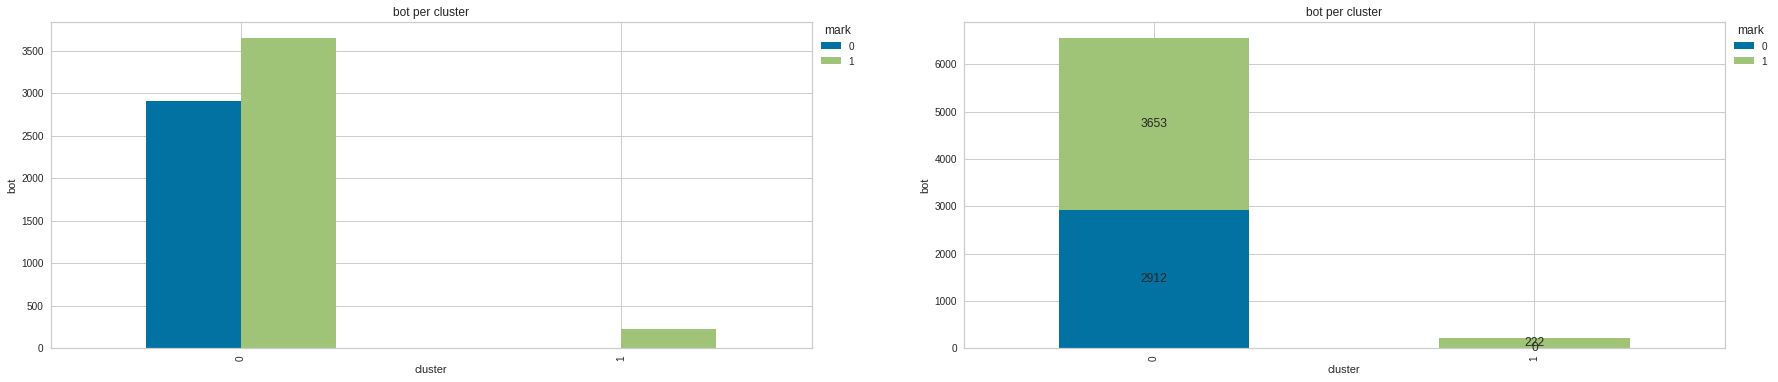

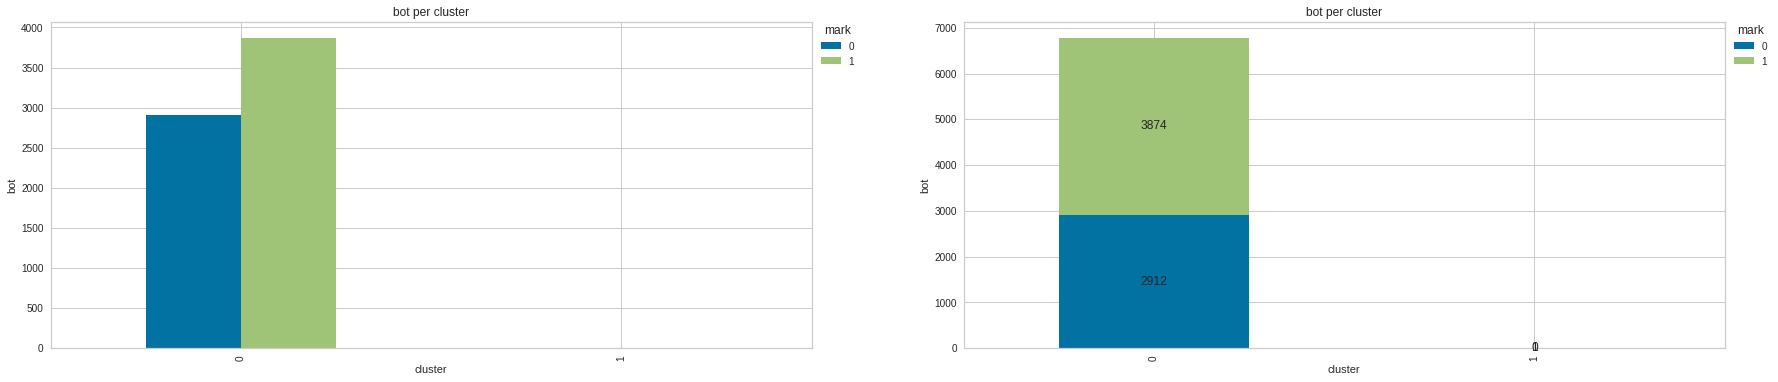

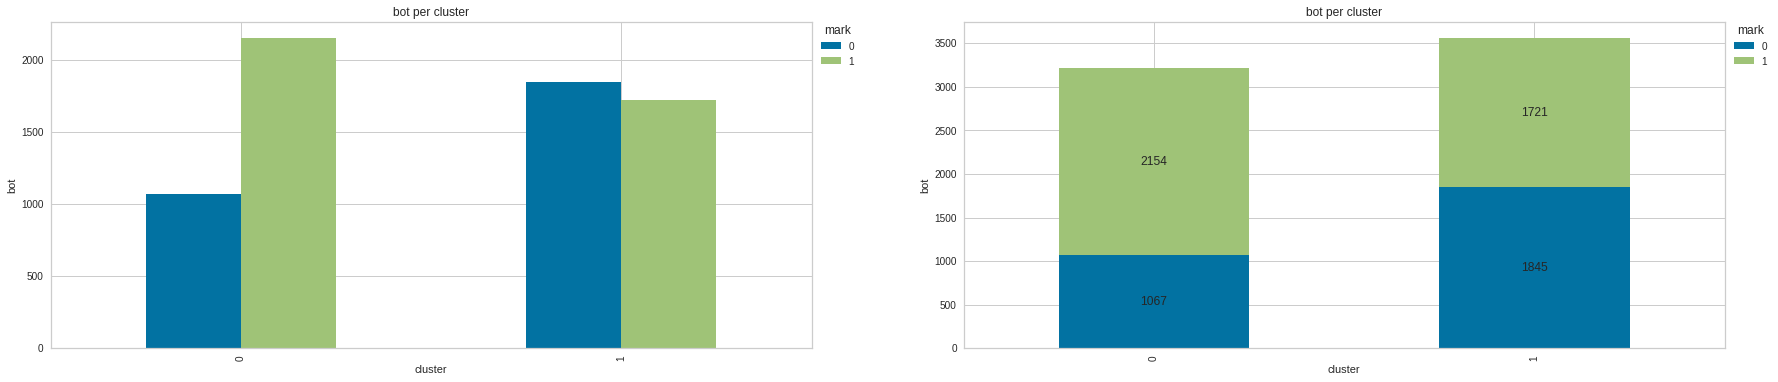

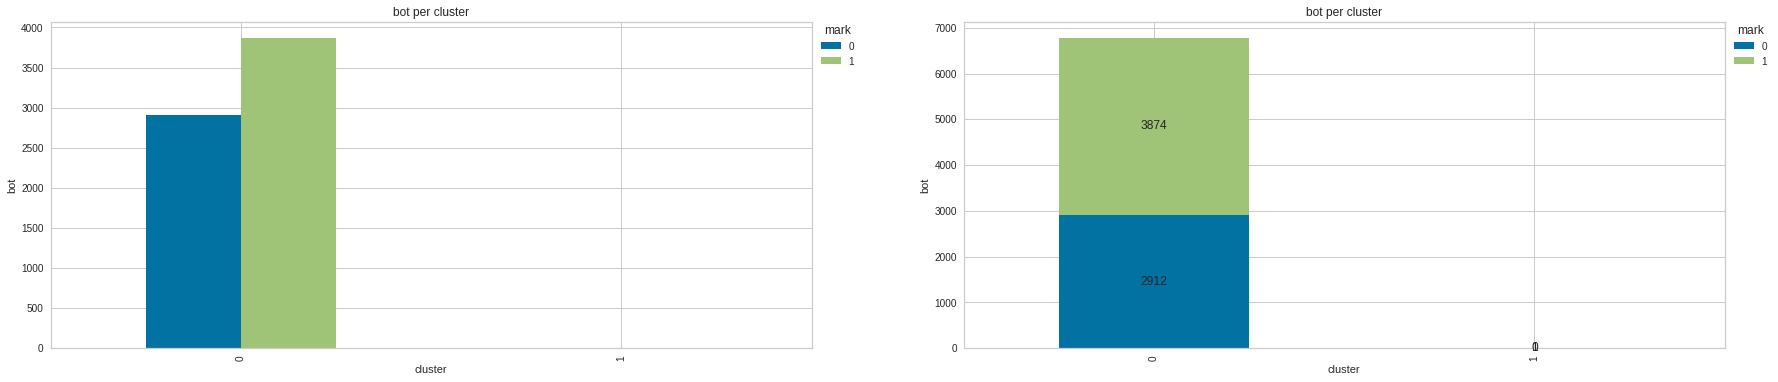

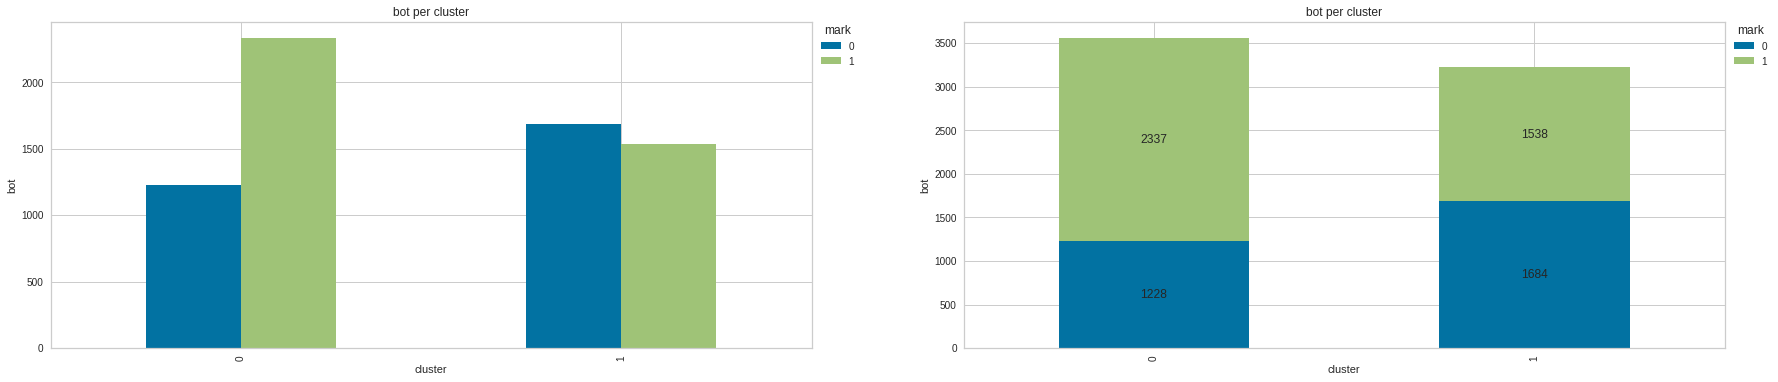

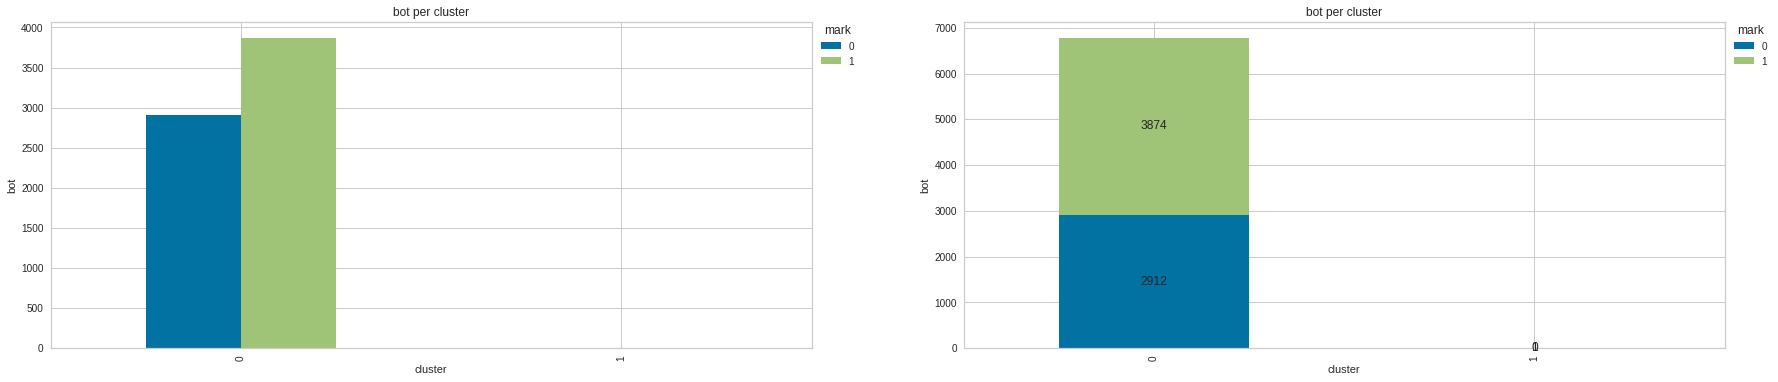

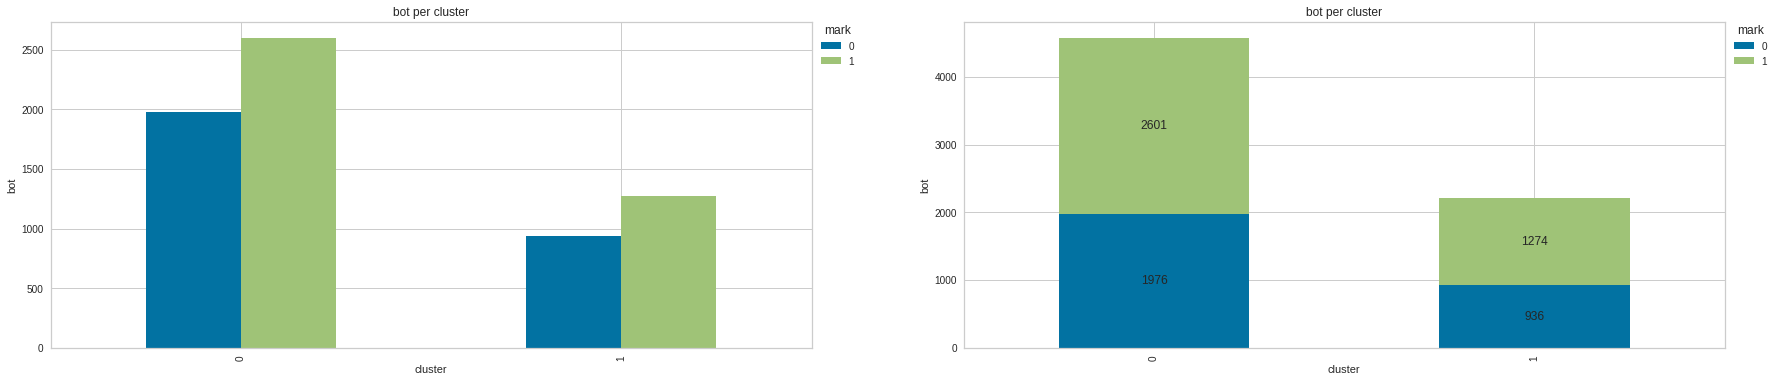

In [ ]:
for i in range(len(timeserieskmeans)):
  bot_ct = pd.crosstab(timeserieskmeans[i].labels_,ts_users['bot'])

  f, axs = plt.subplots(ncols=2, figsize=(30,6))

  ax1 = bot_ct.plot(kind='bar', stacked=False, title='bot per cluster', ax=axs[0])
  ax1.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  axs[0].set_xlabel('cluster')
  axs[0].set_ylabel('bot')

  ax2 = bot_ct.plot(kind='bar', stacked=True, title='bot per cluster', ax=axs[1])
  ax2.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  # add counts
  for c in ax2.containers:
      # set the bar label
      ax2.bar_label(c, label_type='center')
  axs[1].set_xlabel('cluster')
  axs[1].set_ylabel('bot')

  plt.show()

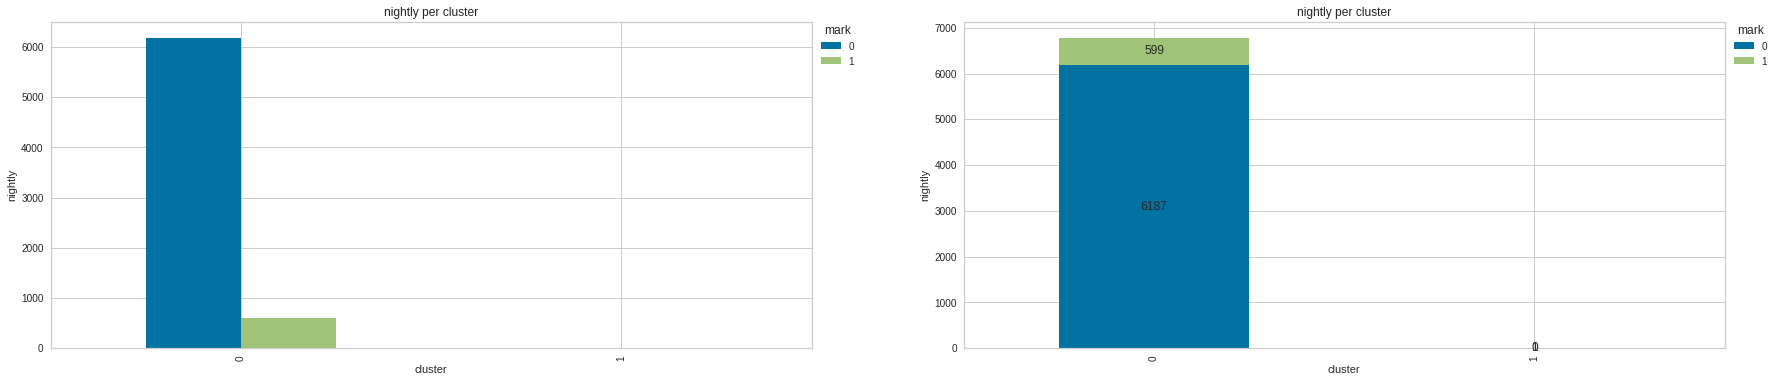

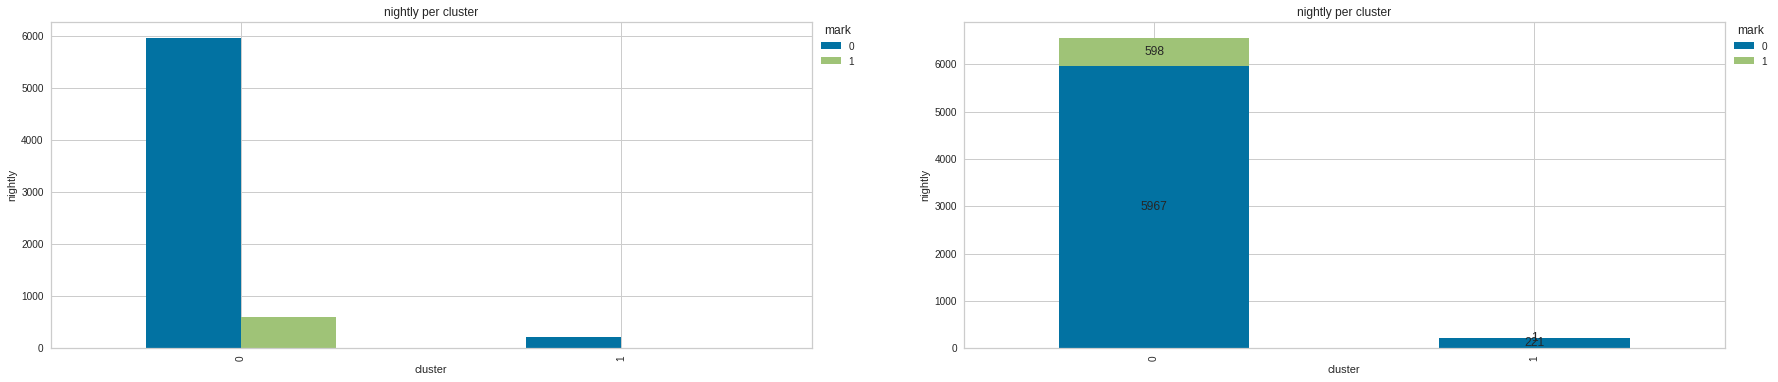

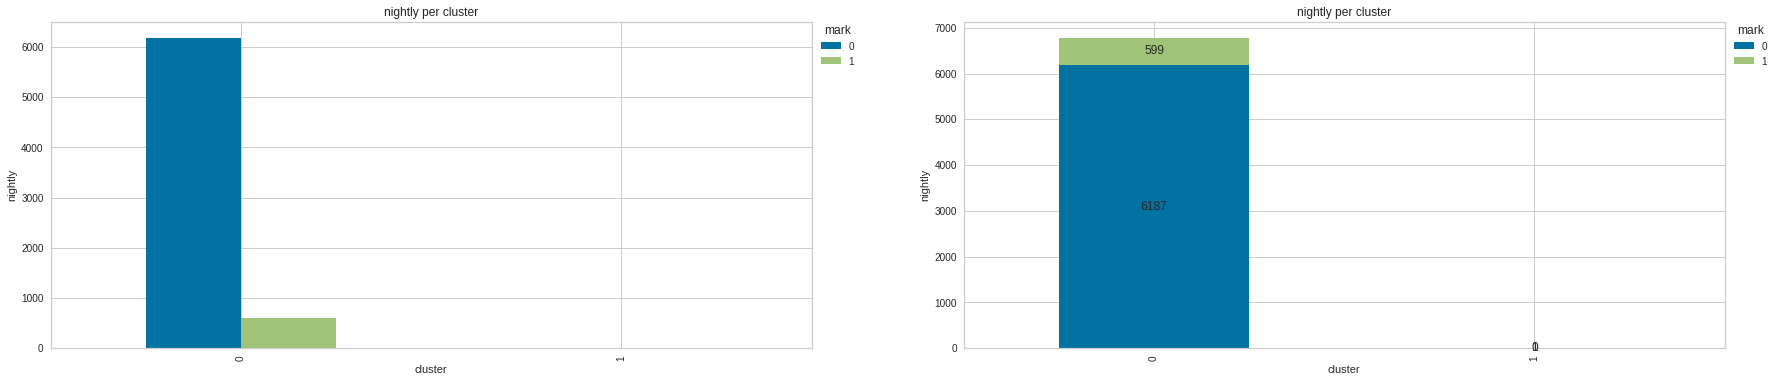

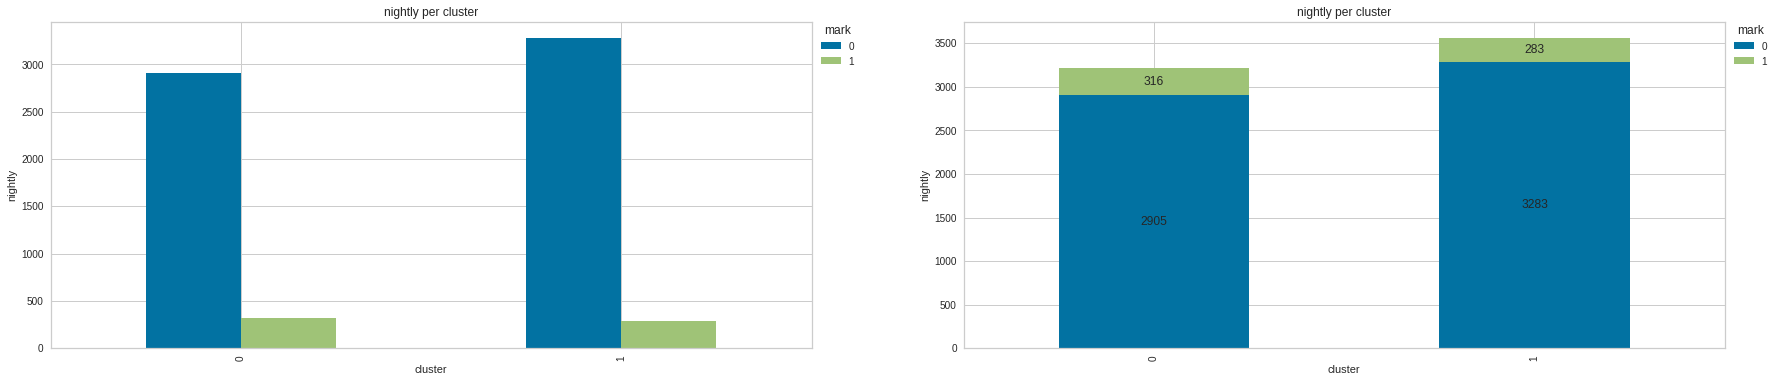

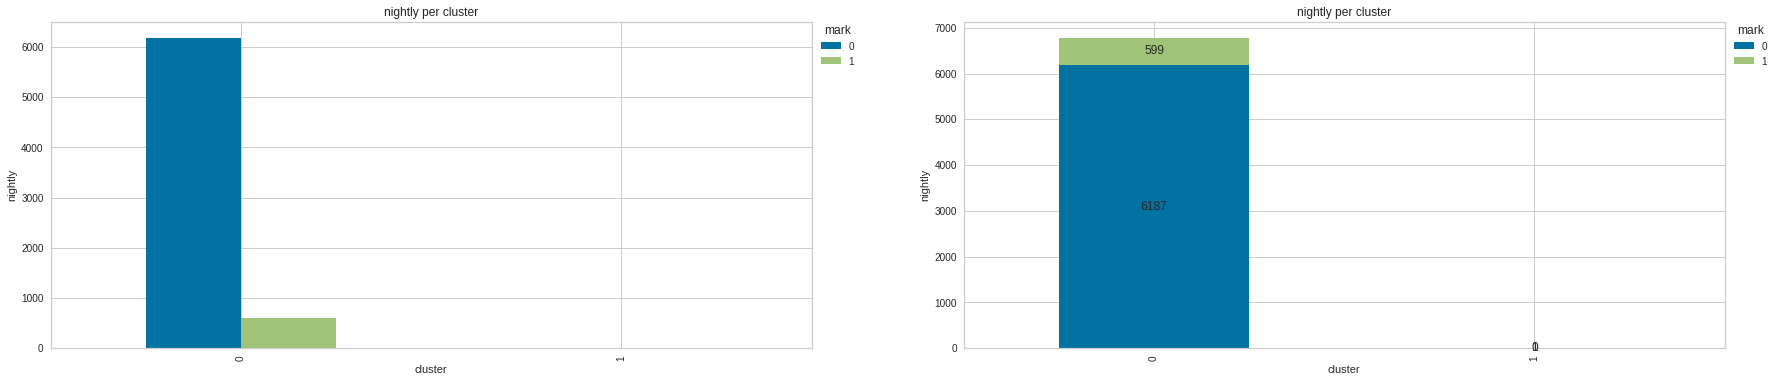

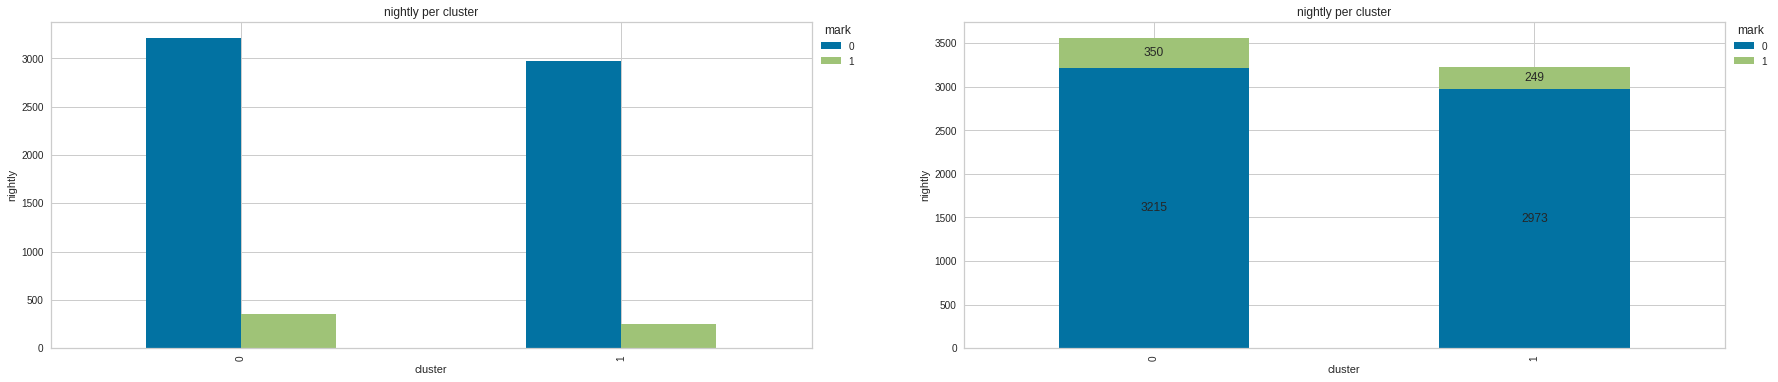

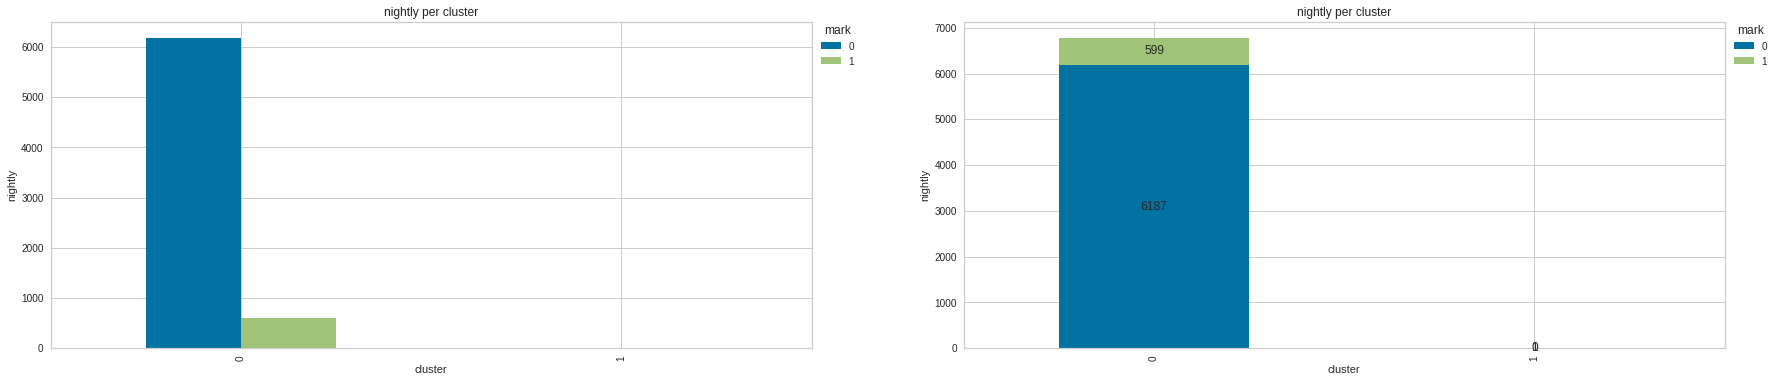

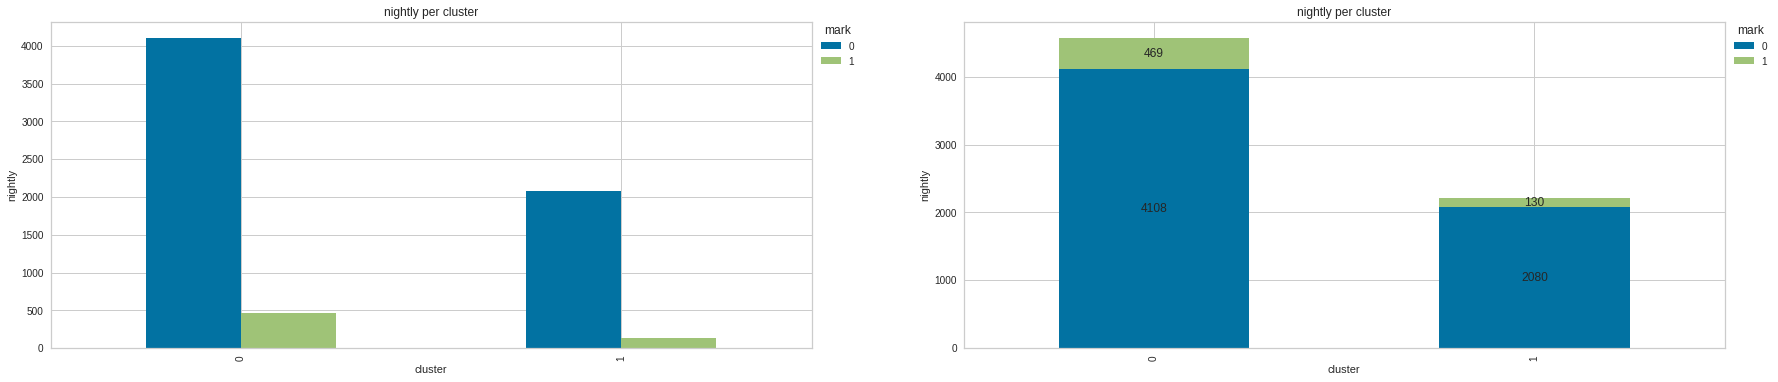

In [ ]:
for i in range(len(timeserieskmeans)):
  nightly_ct = pd.crosstab(timeserieskmeans[i].labels_,users_profile_all['nightly'])

  f, axs = plt.subplots(ncols=2, figsize=(30,6))

  ax1 = nightly_ct.plot(kind='bar', stacked=False, title='nightly per cluster', ax=axs[0])
  ax1.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  axs[0].set_xlabel('cluster')
  axs[0].set_ylabel('nightly')

  ax2 = nightly_ct.plot(kind='bar', stacked=True, title='nightly per cluster', ax=axs[1])
  ax2.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  # add counts
  for c in ax2.containers:
      # set the bar label
      ax2.bar_label(c, label_type='center')
  axs[1].set_xlabel('cluster')
  axs[1].set_ylabel('nightly')

  plt.show()

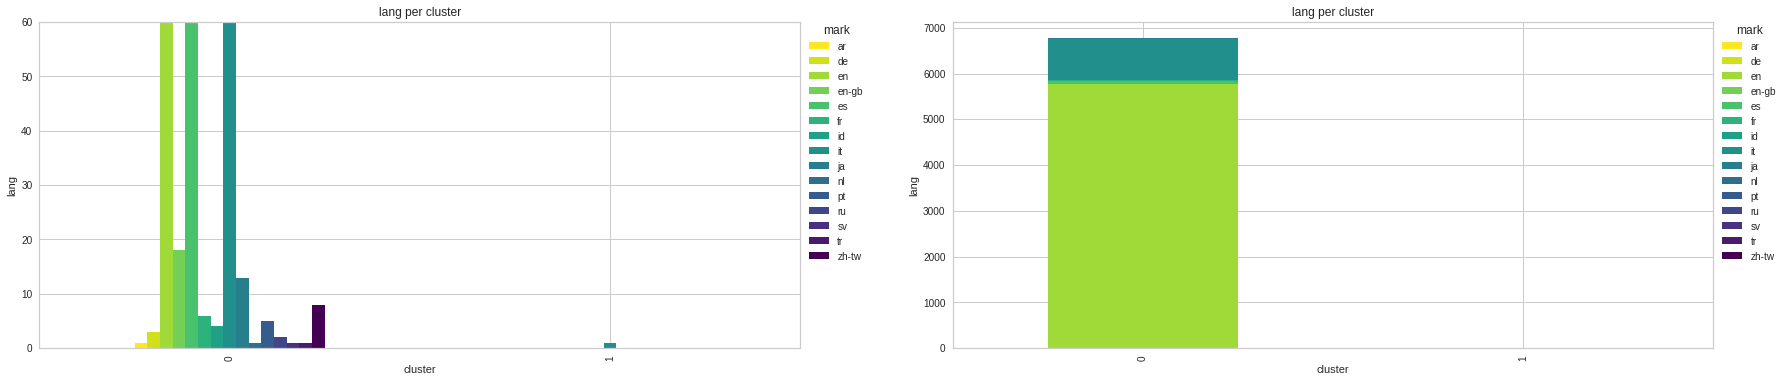

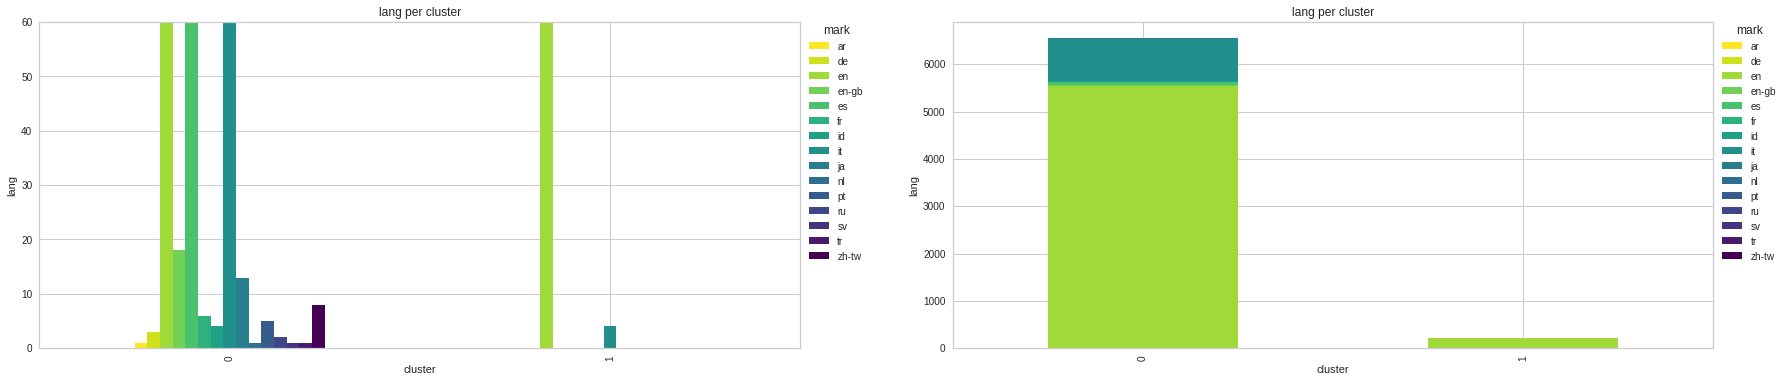

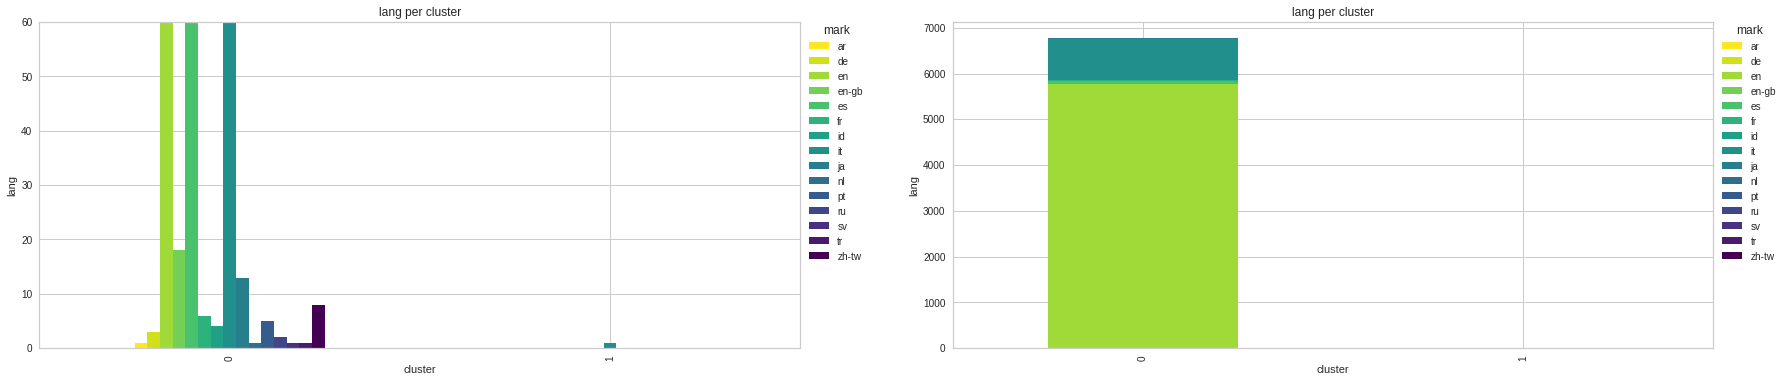

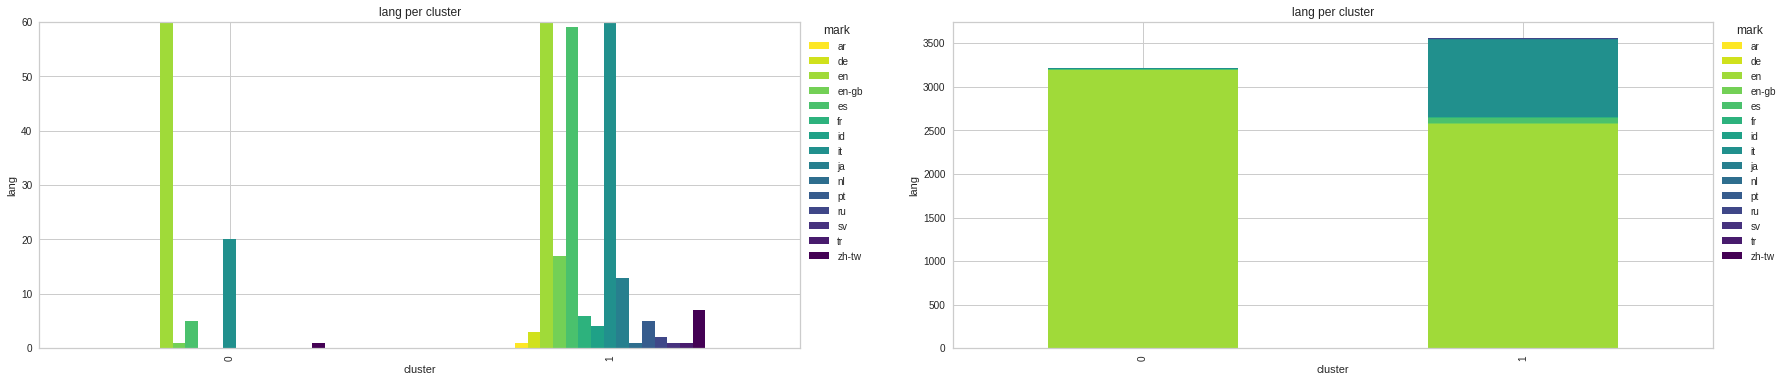

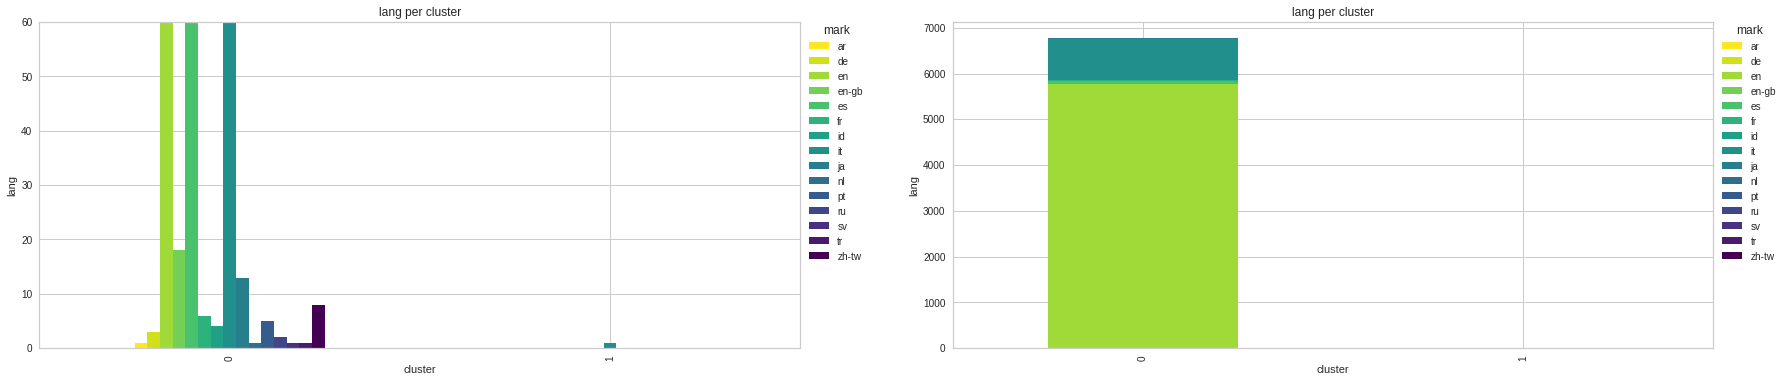

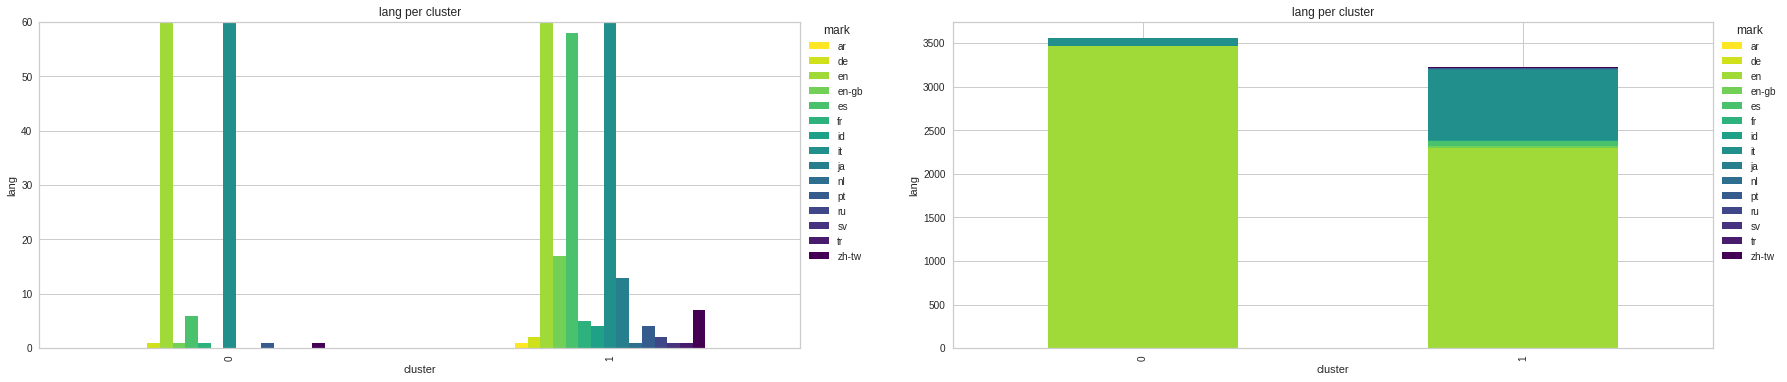

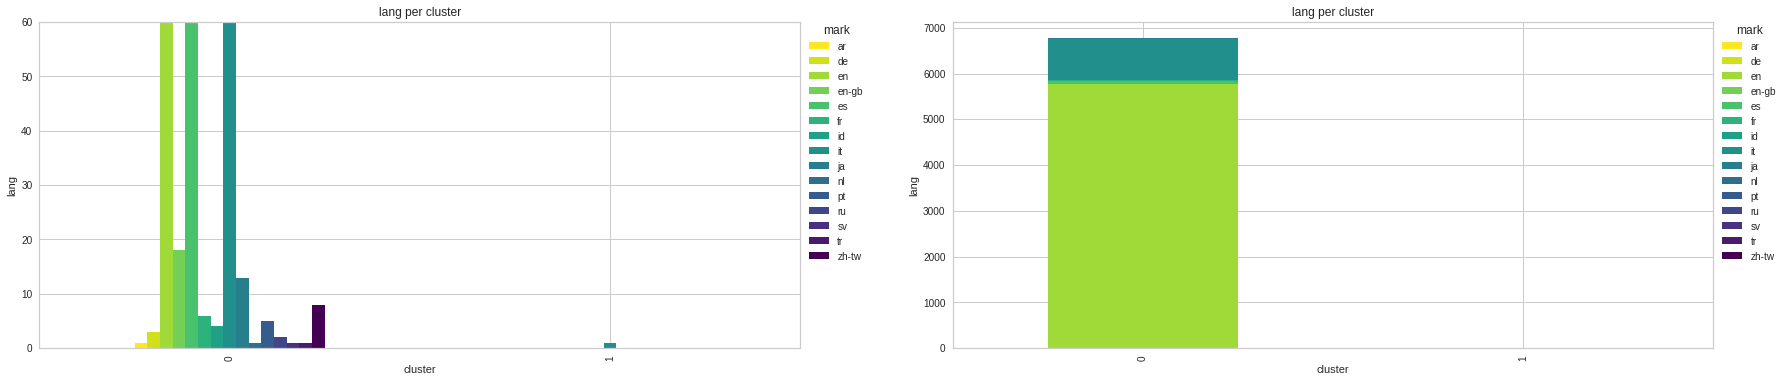

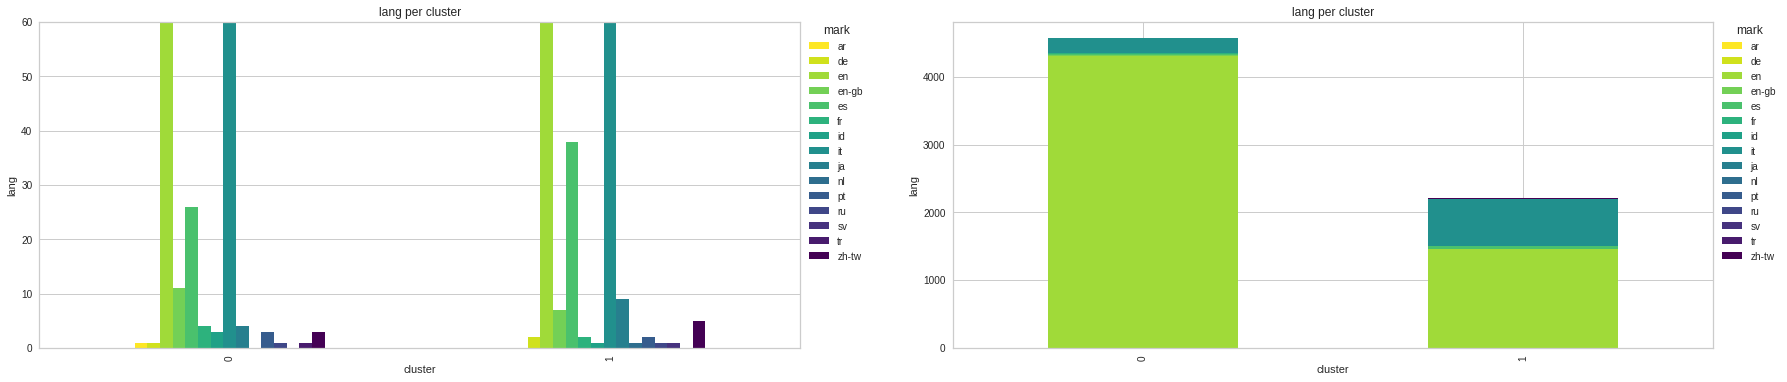

In [ ]:
for i in range(len(timeserieskmeans)):
  lang_ct = pd.crosstab(timeserieskmeans[i].labels_,users_profile_all['lang'])

  f, axs = plt.subplots(ncols=2, figsize=(30,6))

  ax1 = lang_ct.plot(kind='bar', stacked=False, title='lang per cluster', ax=axs[0], colormap="viridis_r")
  ax1.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  axs[0].set_xlabel('cluster')
  axs[0].set_ylabel('lang')
  axs[0].set_ylim(0, 60) 

  ax2 = lang_ct.plot(kind='bar', stacked=True, title='lang per cluster', ax=axs[1], colormap="viridis_r")
  ax2.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  axs[1].set_xlabel('cluster')
  axs[1].set_ylabel('lang')

  plt.show()

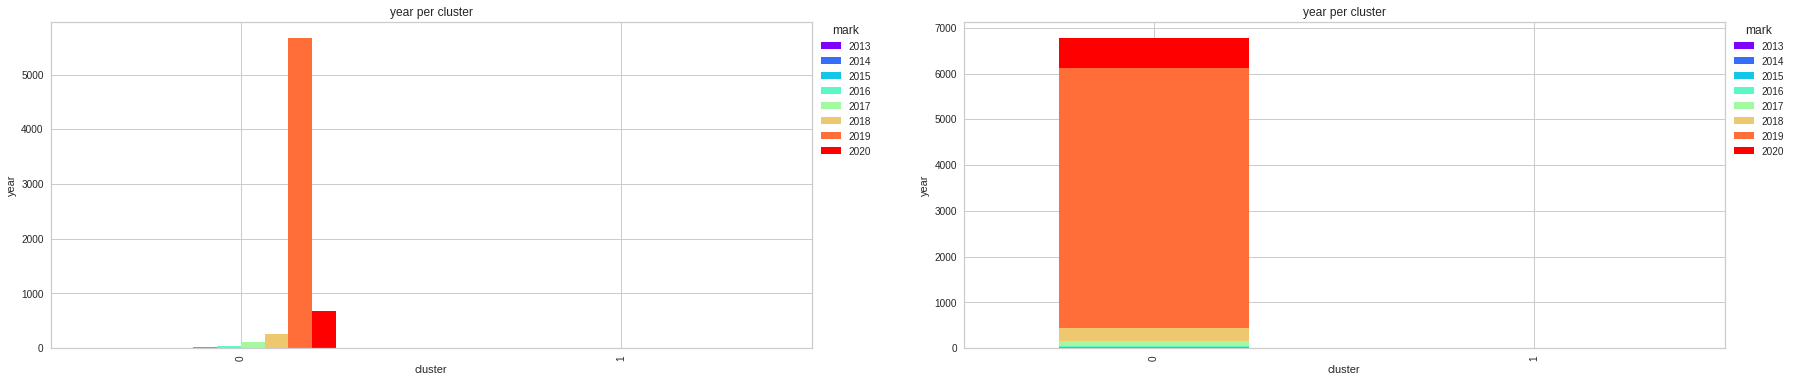

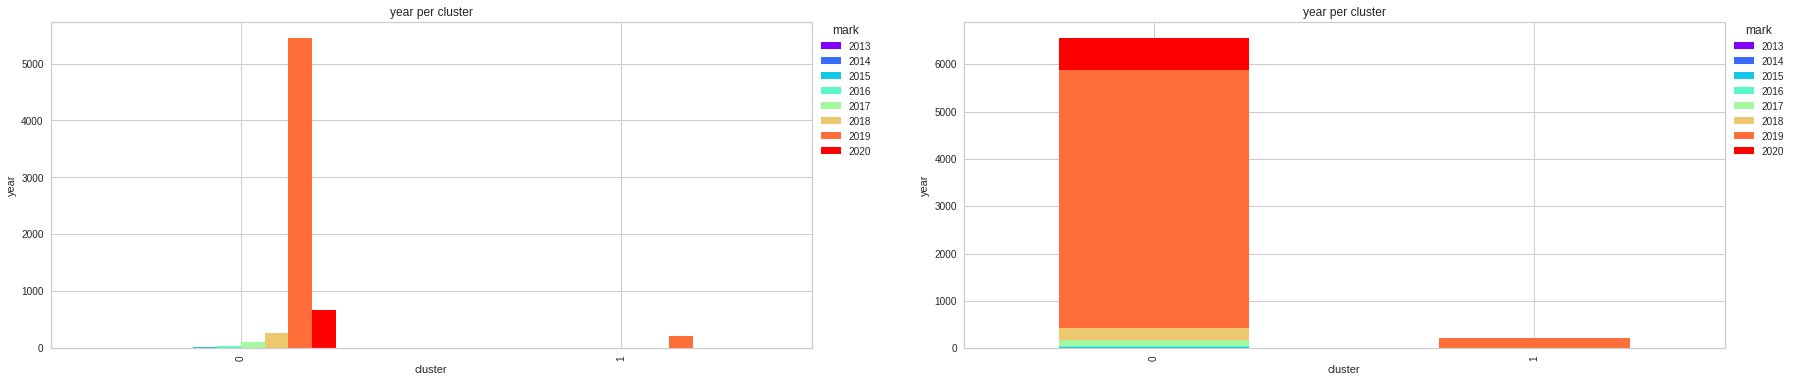

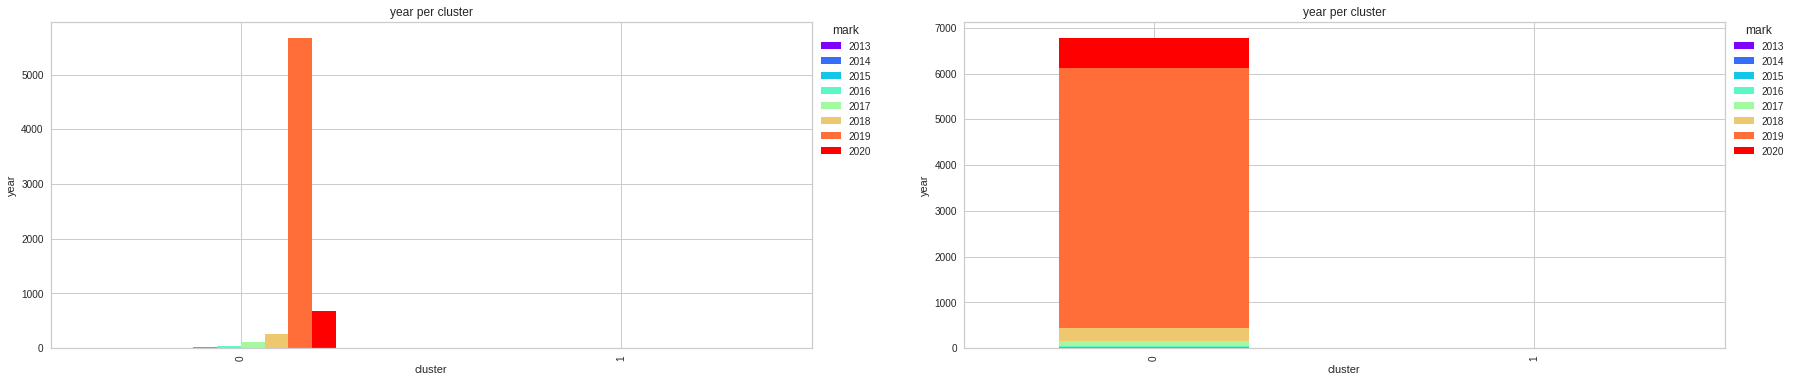

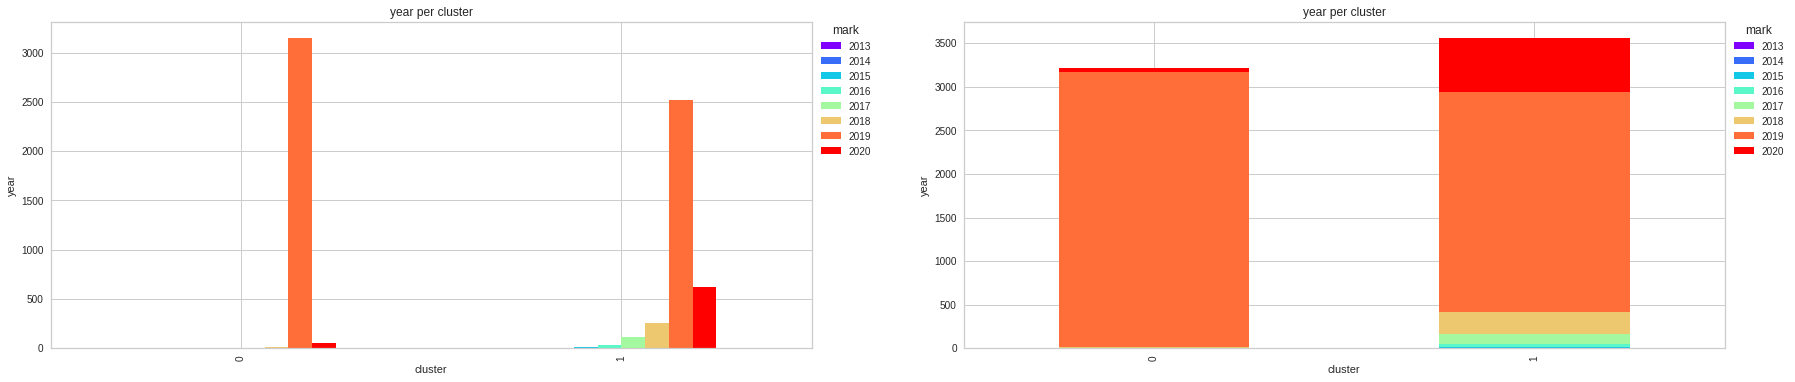

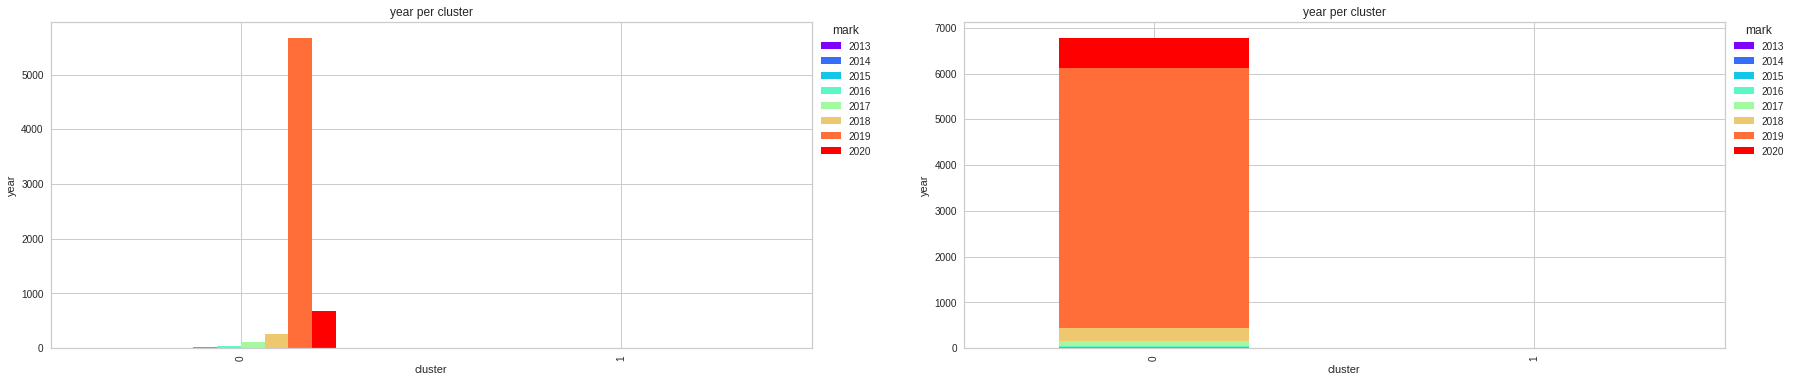

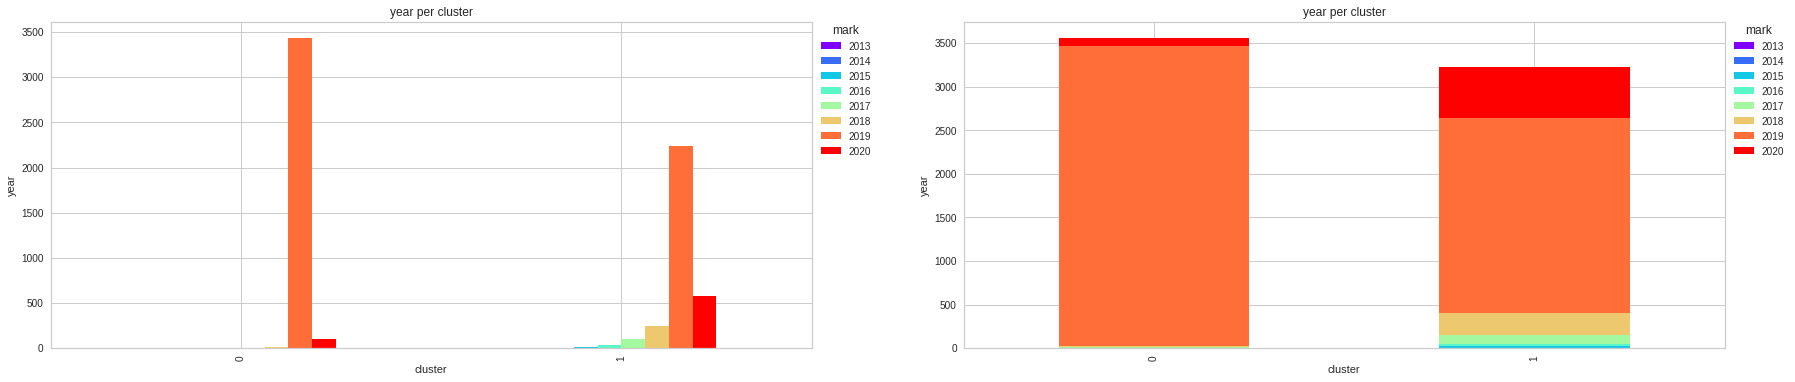

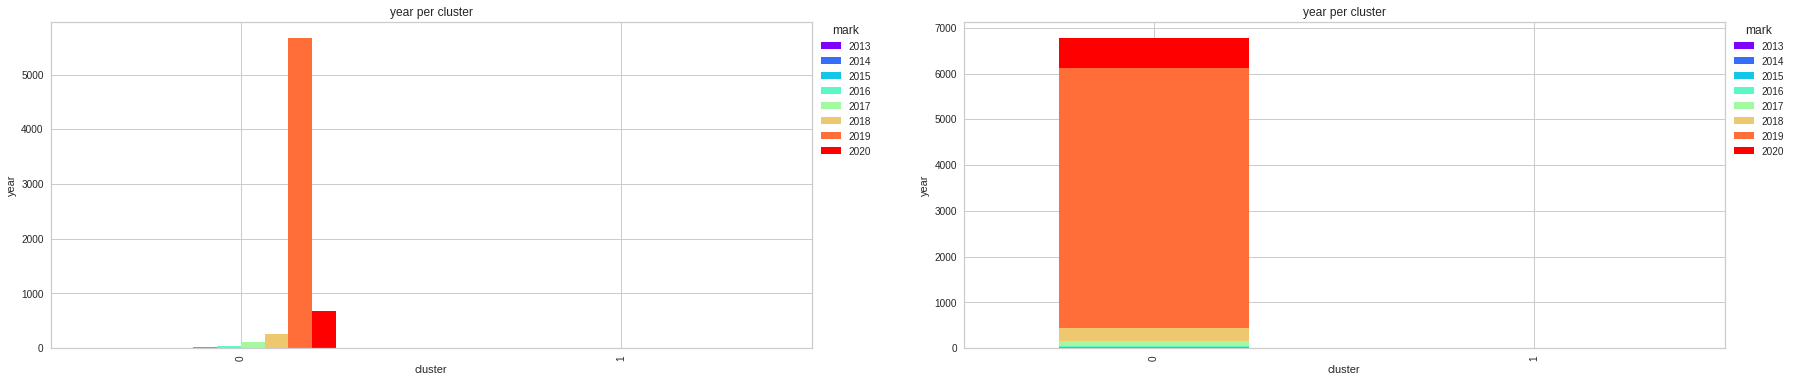

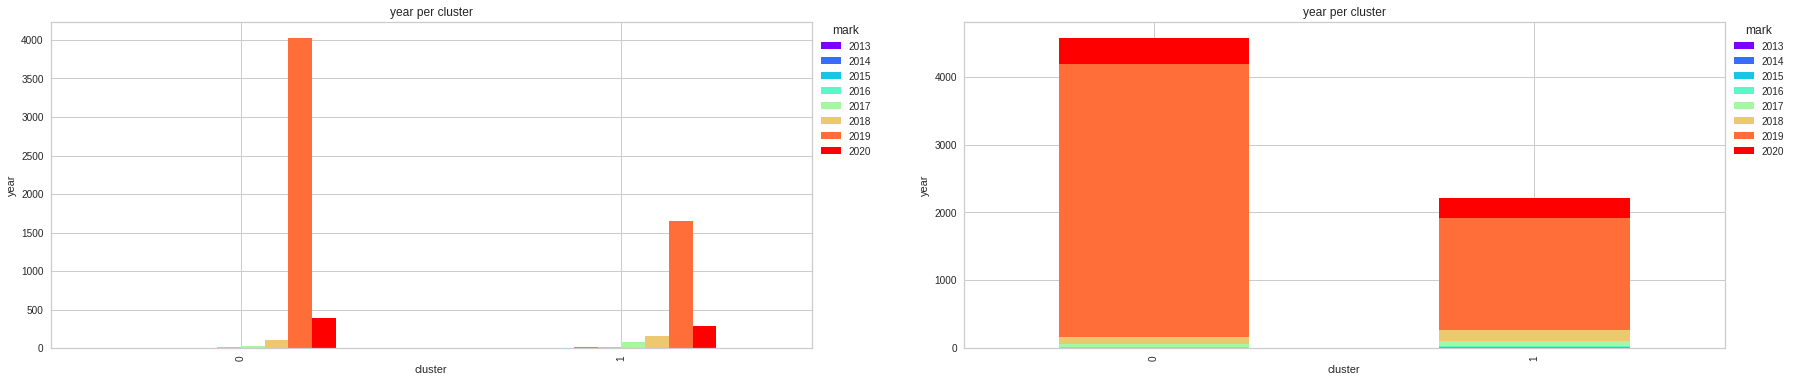

In [ ]:
for i in range(len(timeserieskmeans)):
  year_ct = pd.crosstab(timeserieskmeans[i].labels_,users_profile_all['most_freq_year'])

  f, axs = plt.subplots(ncols=2, figsize=(30,6))

  ax1 = year_ct.plot(kind='bar', stacked=False, title='year per cluster', ax=axs[0], colormap="rainbow")
  ax1.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  axs[0].set_xlabel('cluster')
  axs[0].set_ylabel('year')

  ax2 = year_ct.plot(kind='bar', stacked=True, title='year per cluster', ax=axs[1], colormap="rainbow")
  ax2.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  axs[1].set_xlabel('cluster')
  axs[1].set_ylabel('year')

  plt.show()

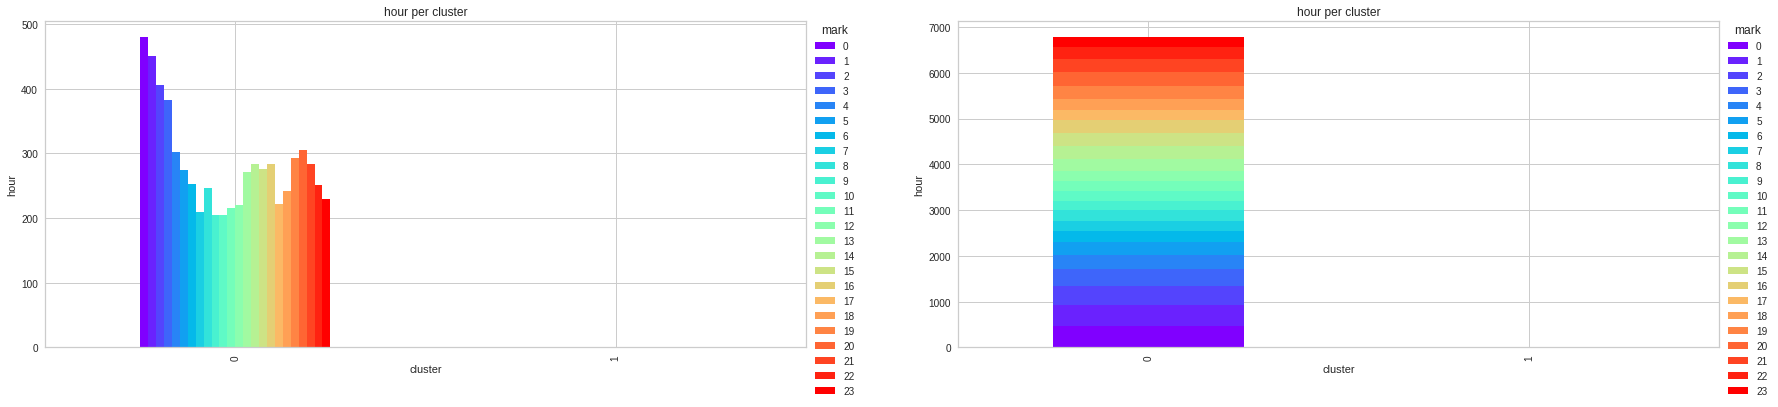

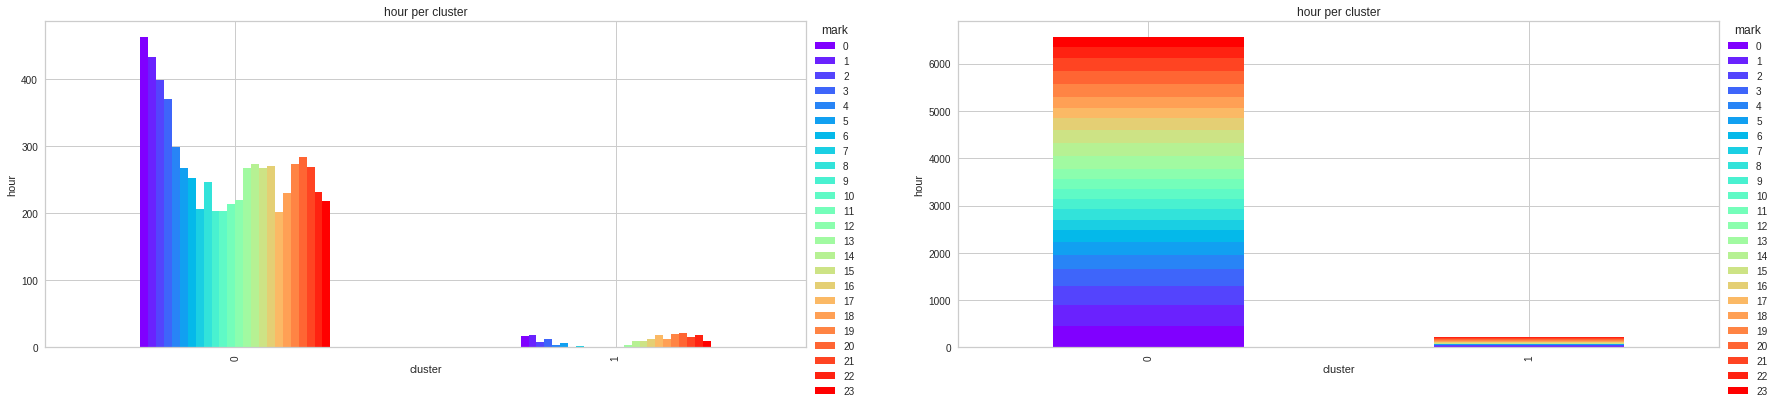

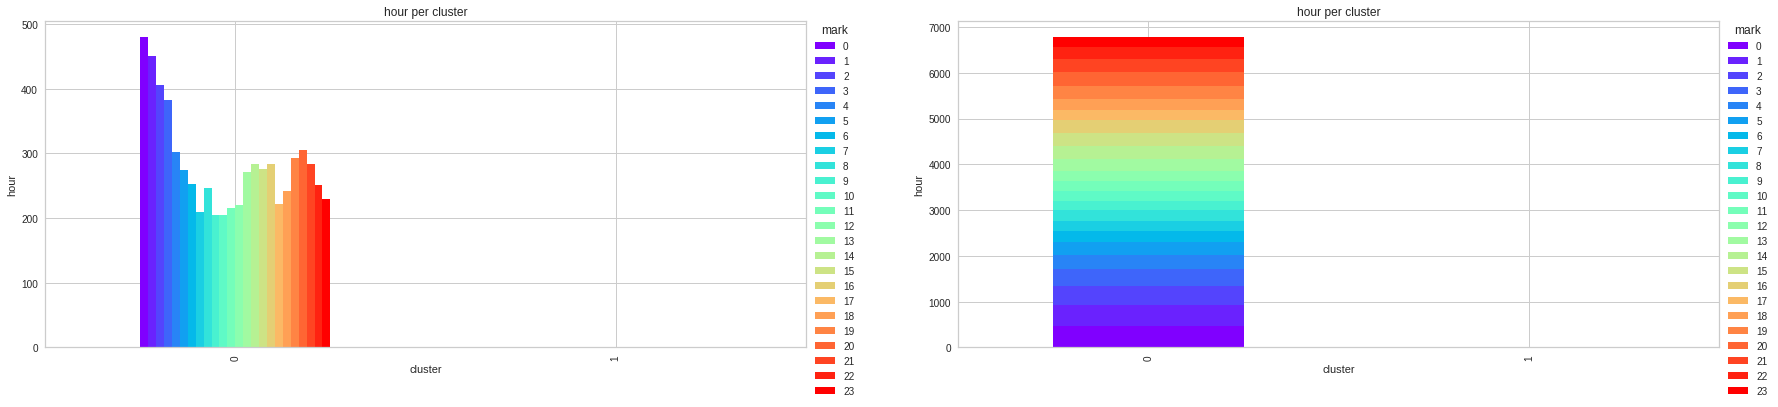

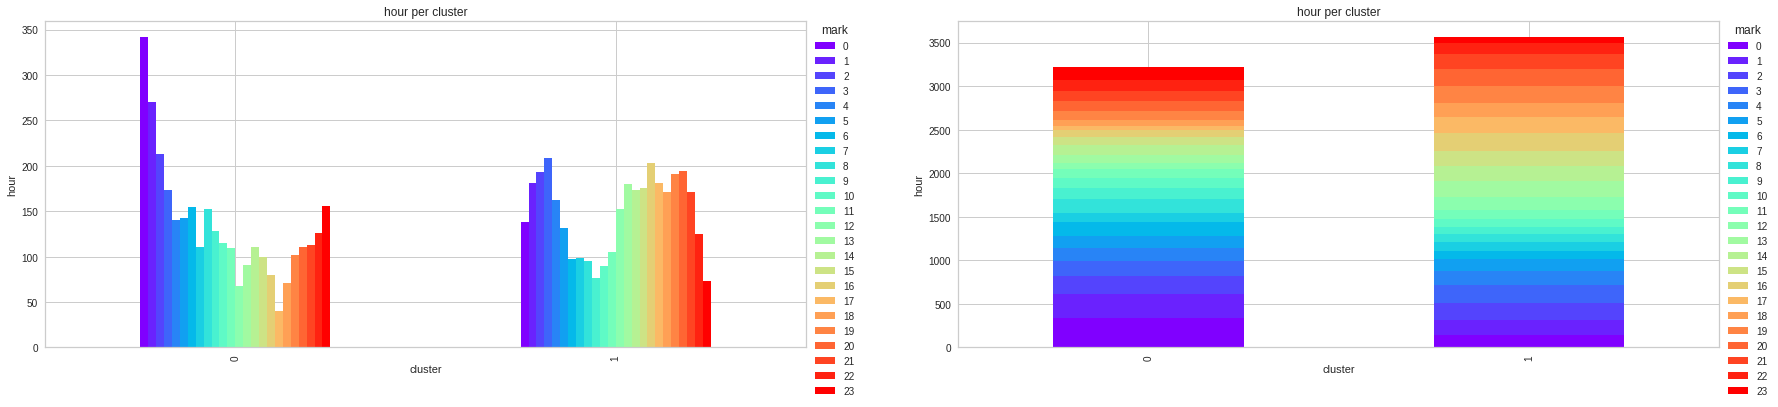

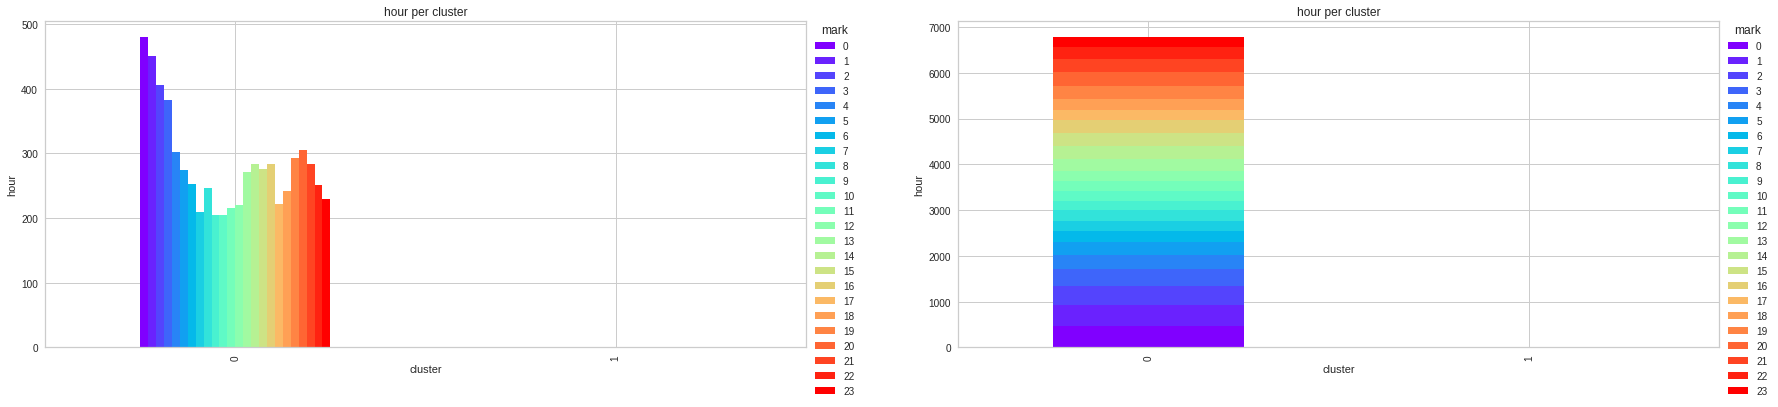

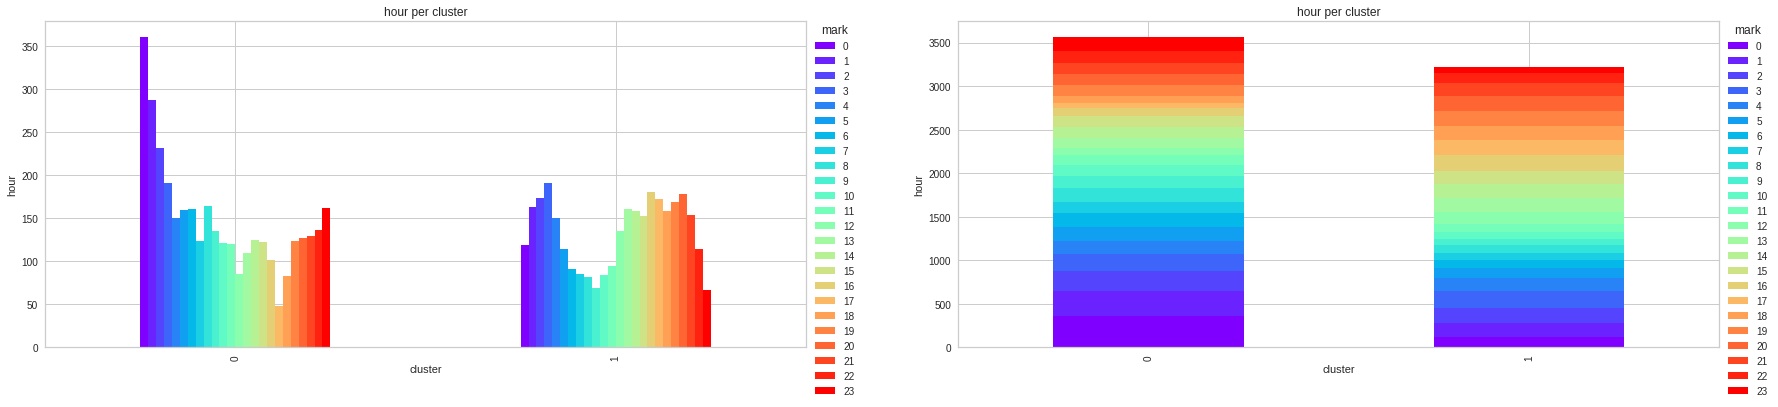

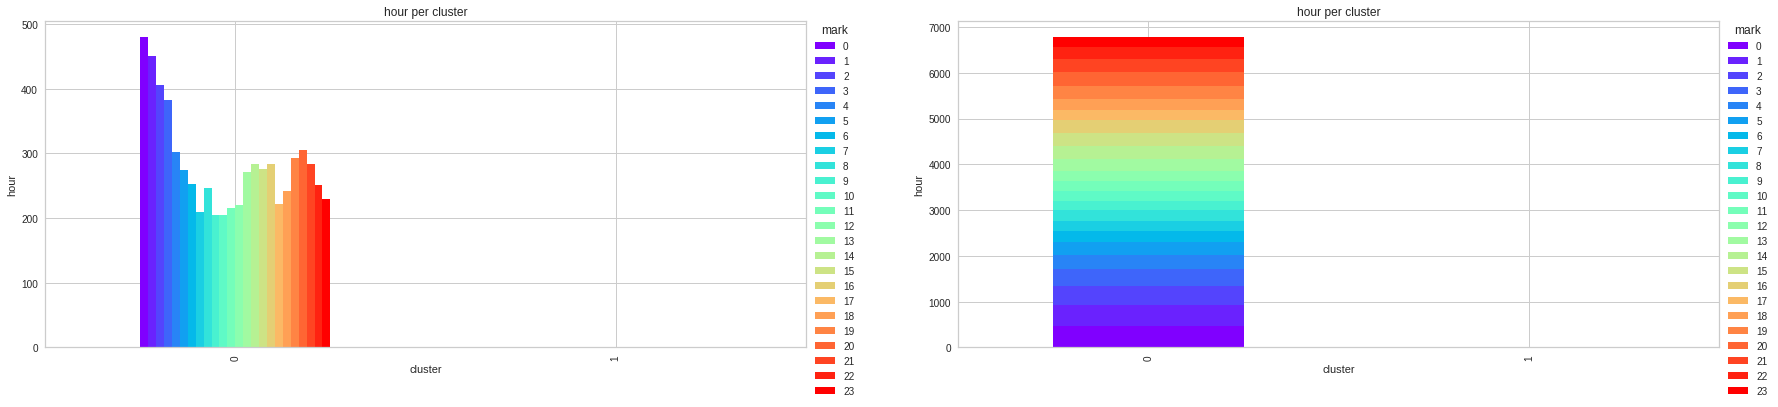

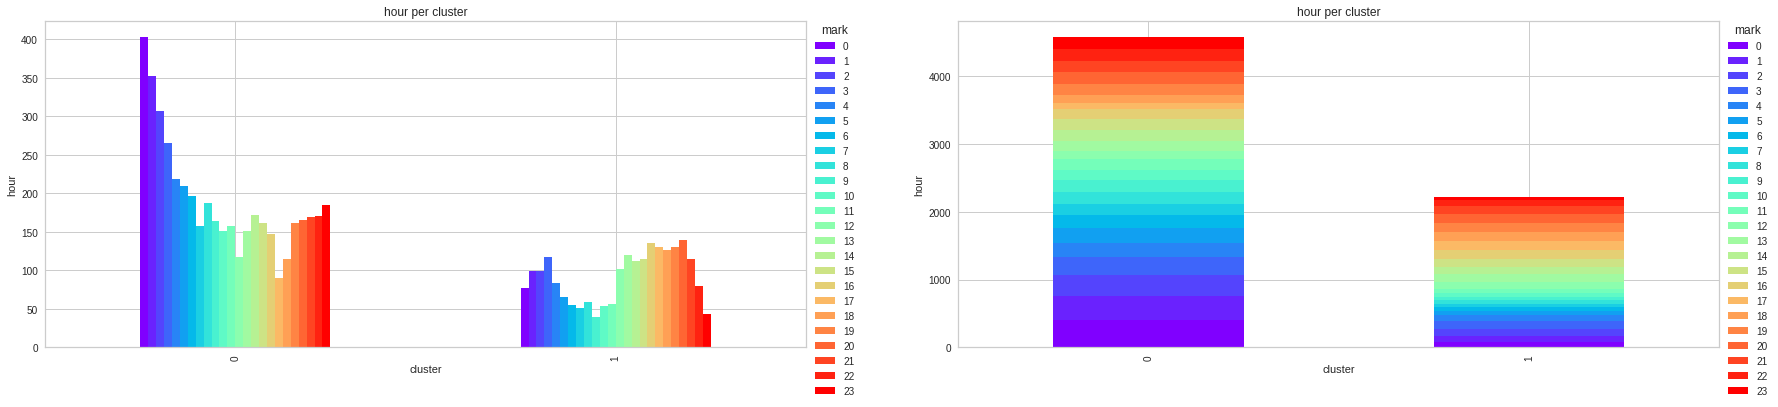

In [ ]:
for i in range(len(timeserieskmeans)):
  hour_ct = pd.crosstab(timeserieskmeans[i].labels_,users_profile_all['most_freq_hour'])

  f, axs = plt.subplots(ncols=2, figsize=(30,6))

  ax1 = hour_ct.plot(kind='bar', stacked=False, title='hour per cluster', ax=axs[0], colormap="rainbow")
  ax1.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  axs[0].set_xlabel('cluster')
  axs[0].set_ylabel('hour')

  ax2 = hour_ct.plot(kind='bar', stacked=True, title='hour per cluster', ax=axs[1], colormap="rainbow")
  ax2.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  axs[1].set_xlabel('cluster')
  axs[1].set_ylabel('hour')

  plt.show()

In [ ]:
cols = []
for i in range(len(timeserieskmeans)):
  s = 'label_K=2 '+str(i+2)
  cols.append(s)

In [ ]:
for i in range(len(timeserieskmeans)):
  users_profile_all[cols[i]]=timeserieskmeans[i].labels_

In [ ]:
users_profile_all.head()

user_id                  name lang  bot_x      user_created_at  \
0   722623          Buzz Jackson   en      0  2012-01-31 00:54:34   
1   755746  Sarah Friedlander G.   en      0  2012-02-09 05:21:24   
2   806975          Mrinal Desai   en      0  2012-03-03 20:00:04   
3   887281          Paul Youlten   en      0  2012-03-11 22:25:08   
4  1382561                jojoko   en      0  2012-03-18 23:24:35   

   statuses_count  retweet_count  reply_count  favorite_count  num_hashtags  \
0           11770      1158520.0          0.0           969.0         766.0   
1           18035       317861.0          0.0           209.0         488.0   
2           28400       173785.0          0.0           529.0         643.0   
3             626         9894.0          0.0            30.0         180.0   
4            8236       276333.0          0.0           612.0         630.0   

   ...                                       SuccessScore  bot_y  label_K=2 2  \
0  ...  [-1.0, -1.0, 1.5492957746478877, 1626.39344262...      0            0   
1  ...  [-1.0, -1.0, 0.0, 0.0, 0.0, 0.1639344262295082...      0            0   
2  ...  [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....      0            0   
3  ...  [-1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0...      0            0   
4  ...  [-1.0, -1.0, 60.0940070505288, 0.4480651731160...      0            0   

   label_K=2 3  label_K=2 4  label_K=2 5  label_K=2 6  label_K=2 7  \
0            0            0            1            0            1   
1            0            0            1            0            1   
2            0            0            1            0            1   
3            0            0            1            0            1   
4            0            0            1            0            1   

   label_K=2 8  label_K=2 9  
0            0            1  
1            0            0  
2            0            0  
3            0            1  
4            0            1  

[5 rows x 43 columns]

In [ ]:
for i in range(len(cols)):
  x = users_profile_all[['statuses_count','retweet_count','favorite_count','num_hashtags','num_urls','num_mentions','max_retweet_count',
                     'max_favorite_count','std_retweet_count','std_favorite_count','popularity','tweet_richness','text_entropy',
                     'avg_textlen','days_on_tw','activity_richness',cols[i]]].groupby(cols[i]).mean()
  display(x)

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 2                                                                
0               3058.913646  250076.830239      663.872237    181.232832   
1                 41.000000  501383.000000      659.000000    136.000000   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 2                                                                    
0            222.535662    368.329207       31567.913498          155.114058   
1            975.000000     12.000000      500000.000000           28.000000   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 2                                                      
0                  1203.661792            4.473859  155.573184   
1                 13263.929962            1.169196  353.550704   

             tweet_richness  text_entropy  avg_textlen   days_on_tw  \
label_K=2 2                                                           
0                  0.644849      2.762809    72.602128  1740.171088   
1                  0.790845      0.000000    89.236284  2079.000000   

             activity_richness  
label_K=2 2                     
0                     0.513705  
1                     0.683021

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 3                                                                
0               2740.663062  258563.192536      675.516832    182.201219   
1              12456.648649     249.522523      319.495495    152.391892   

                num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 3                                                                     
0             169.517593    376.587510       32706.606245          160.243107   
1            1793.779279    122.509009           4.463964            2.864865   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 3                                                      
0                  1246.195194            4.618446  160.858953   
1                     0.186483            0.183247    0.153826   

             tweet_richness  text_entropy  avg_textlen   days_on_tw  \
label_K=2 3                                                           
0                  0.647847      2.712989    72.304762  1725.069916   
1                  0.556856      4.223631    81.470784  2188.270270   

             activity_richness  
label_K=2 3                     
0                     0.472682  
1                     1.727583

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 4                                                                
0               3058.913646  250076.830239      663.872237    181.232832   
1                 41.000000  501383.000000      659.000000    136.000000   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 4                                                                    
0            222.535662    368.329207       31567.913498          155.114058   
1            975.000000     12.000000      500000.000000           28.000000   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 4                                                      
0                  1203.661792            4.473859  155.573184   
1                 13263.929962            1.169196  353.550704   

             tweet_richness  text_entropy  avg_textlen   days_on_tw  \
label_K=2 4                                                           
0                  0.644849      2.762809    72.602128  1740.171088   
1                  0.790845      0.000000    89.236284  2079.000000   

             activity_richness  
label_K=2 4                     
0                     0.513705  
1                     0.683021

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 5                                                                
0                500.160199   94578.702266       96.793232     30.115803   
1               5369.268929  390601.445036     1176.086652    317.717050   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 5                                                                    
0             21.382800     98.643899        4446.800373           10.371624   
1            404.438587    611.823331       56196.499439          285.817443   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 5                                                      
0                   203.213509            0.482645   44.244395   
1                  2110.701665            8.078008  256.186758   

             tweet_richness  text_entropy  avg_textlen   days_on_tw  \
label_K=2 5                                                           
0                  0.498365      1.588128    66.850134  1353.389010   
1                  0.777203      3.823067    77.802298  2089.628155   

             activity_richness  
label_K=2 5                     
0                     0.137744  
1                     0.853340

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 6                                                                
0               3058.913646  250076.830239      663.872237    181.232832   
1                 41.000000  501383.000000      659.000000    136.000000   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 6                                                                    
0            222.535662    368.329207       31567.913498          155.114058   
1            975.000000     12.000000      500000.000000           28.000000   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 6                                                      
0                  1203.661792            4.473859  155.573184   
1                 13263.929962            1.169196  353.550704   

             tweet_richness  text_entropy  avg_textlen   days_on_tw  \
label_K=2 6                                                           
0                  0.644849      2.762809    72.602128  1740.171088   
1                  0.790845      0.000000    89.236284  2079.000000   

             activity_richness  
label_K=2 6                     
0                     0.513705  
1                     0.683021

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 7                                                                
0                735.286115  115407.426928      263.560168     51.194951   
1               5628.967722  399160.545003     1106.798262    325.099938   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 7                                                                    
0             31.899018    136.278822        7364.019355           12.748948   
1            433.700186    624.972067       58493.833644          312.595282   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 7                                                      
0                   319.021658            0.600562   59.184623   
1                  2186.219938            8.758464  262.284293   

             tweet_richness  text_entropy  avg_textlen   days_on_tw  \
label_K=2 7                                                           
0                  0.515491      1.805662    67.532851  1397.557363   
1                  0.788024      3.820991    78.216220  2119.363128   

             activity_richness  
label_K=2 7                     
0                     0.182443  
1                     0.880284

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 8                                                                
0               3058.913646  250076.830239      663.872237    181.232832   
1                 41.000000  501383.000000      659.000000    136.000000   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 8                                                                    
0            222.535662    368.329207       31567.913498          155.114058   
1            975.000000     12.000000      500000.000000           28.000000   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 8                                                      
0                  1203.661792            4.473859  155.573184   
1                 13263.929962            1.169196  353.550704   

             tweet_richness  text_entropy  avg_textlen   days_on_tw  \
label_K=2 8                                                           
0                  0.644849      2.762809    72.602128  1740.171088   
1                  0.790845      0.000000    89.236284  2079.000000   

             activity_richness  
label_K=2 8                     
0                     0.513705  
1                     0.683021

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 9                                                                
0               1863.701770  239119.653922      520.602141    125.492025   
1               5532.880543  272883.301810      960.588235    296.653846   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 9                                                                    
0             80.391960    304.728643       20506.162115           60.811667   
1            517.261538    499.887330       54689.211312          350.360633   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 9                                                      
0                   835.440893            2.170099  131.937006   
1                  1971.719404            9.243545  204.614252   

             tweet_richness  text_entropy  avg_textlen   days_on_tw  \
label_K=2 9                                                           
0                  0.610633      2.346388    69.040708  1549.404195   
1                  0.715779      3.623982    79.985500  2135.410407   

             activity_richness  
label_K=2 9                     
0                     0.306752  
1                     0.942389

In [ ]:
for i in range(len(cols)):
  x = users_profile_all[['statuses_count','retweet_count','favorite_count','num_hashtags','num_urls','num_mentions','max_retweet_count',
                     'max_favorite_count','std_retweet_count','std_favorite_count','popularity','tweet_richness','text_entropy',
                     'avg_textlen','days_on_tw','activity_richness',cols[i]]].groupby(cols[i]).std()
  display(x)

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 2                                                                
0               8318.065031   1.677927e+06     3735.652375    482.645172   
1                       NaN            NaN             NaN           NaN   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 2                                                                    
0            515.749704    668.572538       91269.664038         1054.878209   
1                   NaN           NaN                NaN                 NaN   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 2                                                      
0                  3960.748833           33.485008  814.000147   
1                          NaN                 NaN         NaN   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 2                                                          
0                  0.711664      3.702801    13.269693  571.188408   
1                       NaN           NaN          NaN         NaN   

             activity_richness  
label_K=2 2                     
0                     0.556761  
1                          NaN

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 3                                                                
0               8155.643014   1.705302e+06     3730.391851    468.725647   
1               7548.335271   3.188311e+03     3872.785647    790.832647   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 3                                                                    
0            425.974900    675.154981       92784.985094         1072.111949   
1            464.895192    349.468229          10.925335            6.491884   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 3                                                      
0                  4023.316014           34.034325  827.082713   
1                     0.772747            0.756979    1.910438   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 3                                                          
0                  0.720815      3.671222    13.358856  572.207728   
1                  0.330426      4.294684     5.018095  289.280898   

             activity_richness  
label_K=2 3                     
0                     0.516837  
1                     0.230214

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 4                                                                
0               8318.065031   1.677927e+06     3735.652375    482.645172   
1                       NaN            NaN             NaN           NaN   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 4                                                                    
0            515.749704    668.572538       91269.664038         1054.878209   
1                   NaN           NaN                NaN                 NaN   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 4                                                      
0                  3960.748833           33.485008  814.000147   
1                          NaN                 NaN         NaN   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 4                                                          
0                  0.711664      3.702801    13.269693  571.188408   
1                       NaN           NaN          NaN         NaN   

             activity_richness  
label_K=2 4                     
0                     0.556761  
1                          NaN

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 5                                                                
0               3334.879769   1.390867e+06     1384.832798    140.030638   
1              10506.535639   1.889320e+06     4926.920580    621.589227   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 5                                                                    
0            150.671896    320.273956       32699.110387          214.226884   
1            645.175567    795.669613      116955.704028         1428.420292   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 5                                                      
0                  1917.290314            5.687755  605.551527   
1                  4984.996013           45.578294  953.179371   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 5                                                          
0                  0.724392      2.228588     5.696805  238.063810   
1                  0.673092      4.386299    15.778197  558.983253   

             activity_richness  
label_K=2 5                     
0                     0.217455  
1                     0.551518

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 6                                                                
0               8318.065031   1.677927e+06     3735.652375    482.645172   
1                       NaN            NaN             NaN           NaN   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 6                                                                    
0            515.749704    668.572538       91269.664038         1054.878209   
1                   NaN           NaN                NaN                 NaN   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 6                                                      
0                  3960.748833           33.485008  814.000147   
1                          NaN                 NaN         NaN   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 6                                                          
0                  0.711664      3.702801    13.269693  571.188408   
1                       NaN           NaN          NaN         NaN   

             activity_richness  
label_K=2 6                     
0                     0.556761  
1                          NaN

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 7                                                                
0               3785.504149   1.342831e+06     2085.209750    221.056321   
1              10831.069907   1.973116e+06     4920.520857    630.245958   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 7                                                                    
0            171.791048    398.934595       40356.429316          206.019482   
1            665.593127    800.022867      120165.703525         1499.944664   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 7                                                      
0                  2092.889893            5.496826  597.601317   
1                  5139.284689           47.890437  989.410176   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 7                                                          
0                  0.735459      2.550419     7.308363  317.525796   
1                  0.655245      4.421822    15.872511  549.526699   

             activity_richness  
label_K=2 7                     
0                     0.292683  
1                     0.549838

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 8                                                                
0               8318.065031   1.677927e+06     3735.652375    482.645172   
1                       NaN            NaN             NaN           NaN   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 8                                                                    
0            515.749704    668.572538       91269.664038         1054.878209   
1                   NaN           NaN                NaN                 NaN   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 8                                                      
0                  3960.748833           33.485008  814.000147   
1                          NaN                 NaN         NaN   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 8                                                          
0                  0.711664      3.702801    13.269693  571.188408   
1                       NaN           NaN          NaN         NaN   

             activity_richness  
label_K=2 8                     
0                     0.556761  
1                          NaN

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 9                                                                
0               6000.679417   1.925248e+06     3886.325822    422.021908   
1              11351.151050   9.842135e+05     3383.117909    571.657252   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 9                                                                    
0            263.300696    632.844032       66367.469625          603.972799   
1            738.170311    719.493737      125590.256224         1614.212107   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 9                                                      
0                  3167.299157           22.713588  769.940677   
1                  5157.352893           48.388722  896.446933   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 9                                                          
0                  0.751568      3.288763    10.891115  499.659515   
1                  0.614868      4.313877    14.643700  503.280867   

             activity_richness  
label_K=2 9                     
0                     0.409915  
1                     0.575723

In [ ]:
for i in range(len(cols)):
  x = users_profile_all[['statuses_count','retweet_count','favorite_count','num_hashtags','num_urls','num_mentions','max_retweet_count',
                     'max_favorite_count','std_retweet_count','std_favorite_count','popularity','tweet_richness','text_entropy',
                     'avg_textlen','days_on_tw','activity_richness',cols[i]]].groupby(cols[i]).max()
  display(x)

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 2                                                                
0                    200000     91037102.0        221102.0       16228.0   
1                        41       501383.0           659.0         136.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 2                                                                  
0              3749.0        6284.0           500000.0             10000.0   
1               975.0          12.0           500000.0                28.0   

             std_retweet_count  std_favorite_count    popularity  \
label_K=2 2                                                        
0                 95097.011295          916.660125  29482.488281   
1                 13263.929962            1.169196    353.550704   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 2                                                          
0                 10.440860     11.806861   146.675595        3893   
1                  0.790845      0.000000    89.236284        2079   

             activity_richness  
label_K=2 2                     
0                     2.783033  
1                     0.683021

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 3                                                                
0                    200000     91037102.0        221102.0       16228.0   
1                     84120        47532.0         57760.0        9611.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 3                                                                  
0              3639.0        6284.0           500000.0             10000.0   
1              3749.0        2295.0              109.0                89.0   

             std_retweet_count  std_favorite_count    popularity  \
label_K=2 3                                                        
0                 95097.011295          916.660125  29482.488281   
1                    11.183533           11.383845     28.488095   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 3                                                          
0                 10.440860     11.806861   146.675595        3893   
1                  4.142281     11.757003   122.358427        3126   

             activity_richness  
label_K=2 3                     
0                     2.696154  
1                     2.783033

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 4                                                                
0                    200000     91037102.0        221102.0       16228.0   
1                        41       501383.0           659.0         136.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 4                                                                  
0              3749.0        6284.0           500000.0             10000.0   
1               975.0          12.0           500000.0                28.0   

             std_retweet_count  std_favorite_count    popularity  \
label_K=2 4                                                        
0                 95097.011295          916.660125  29482.488281   
1                 13263.929962            1.169196    353.550704   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 4                                                          
0                 10.440860     11.806861   146.675595        3893   
1                  0.790845      0.000000    89.236284        2079   

             activity_richness  
label_K=2 4                     
0                     2.783033  
1                     0.683021

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 5                                                                
0                     99563     47425166.0         72374.0        3113.0   
1                    200000     91037102.0        221102.0       16228.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 5                                                                  
0              3083.0        4574.0           500000.0             10000.0   
1              3749.0        6284.0           500000.0             10000.0   

             std_retweet_count  std_favorite_count    popularity  \
label_K=2 5                                                        
0                 56277.447006          272.969840  21587.464847   
1                 95097.011295          916.660125  29482.488281   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 5                                                          
0                 10.440860     11.738400   122.358427        3778   
1                  9.703704     11.806861   146.675595        3893   

             activity_richness  
label_K=2 5                     
0                     2.228571  
1                     2.783033

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 6                                                                
0                    200000     91037102.0        221102.0       16228.0   
1                        41       501383.0           659.0         136.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 6                                                                  
0              3749.0        6284.0           500000.0             10000.0   
1               975.0          12.0           500000.0                28.0   

             std_retweet_count  std_favorite_count    popularity  \
label_K=2 6                                                        
0                 95097.011295          916.660125  29482.488281   
1                 13263.929962            1.169196    353.550704   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 6                                                          
0                 10.440860     11.806861   146.675595        3893   
1                  0.790845      0.000000    89.236284        2079   

             activity_richness  
label_K=2 6                     
0                     2.783033  
1                     0.683021

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 7                                                                
0                     99563     47425166.0         72374.0        4974.0   
1                    200000     91037102.0        221102.0       16228.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 7                                                                  
0              3083.0        4574.0           500000.0             10000.0   
1              3749.0        6284.0           500000.0             10000.0   

             std_retweet_count  std_favorite_count    popularity  \
label_K=2 7                                                        
0                 56277.447006          272.969840  21587.464847   
1                 95097.011295          916.660125  29482.488281   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 7                                                          
0                 10.440860     11.738400   124.991822        3778   
1                  8.479675     11.806861   146.675595        3893   

             activity_richness  
label_K=2 7                     
0                     2.360635  
1                     2.783033

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 8                                                                
0                    200000     91037102.0        221102.0       16228.0   
1                        41       501383.0           659.0         136.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 8                                                                  
0              3749.0        6284.0           500000.0             10000.0   
1               975.0          12.0           500000.0                28.0   

             std_retweet_count  std_favorite_count    popularity  \
label_K=2 8                                                        
0                 95097.011295          916.660125  29482.488281   
1                 13263.929962            1.169196    353.550704   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 8                                                          
0                 10.440860     11.806861   146.675595        3893   
1                  0.790845      0.000000    89.236284        2079   

             activity_richness  
label_K=2 8                     
0                     2.783033  
1                     0.683021

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 9                                                                
0                     99563     91037102.0        221102.0       16228.0   
1                    200000     21028029.0        105015.0        9611.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 9                                                                  
0              3486.0        4904.0           500000.0             10000.0   
1              3749.0        6284.0           500000.0             10000.0   

             std_retweet_count  std_favorite_count    popularity  \
label_K=2 9                                                        
0                 56734.038613          909.054786  24651.463851   
1                 95097.011295          916.660125  29482.488281   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 9                                                          
0                 10.440860     11.738400   124.991822        3884   
1                  6.067227     11.806861   146.675595        3893   

             activity_richness  
label_K=2 9                     
0                     2.363158  
1                     2.783033

In [ ]:
for i in range(len(cols)):
  x = users_profile_all[['statuses_count','retweet_count','favorite_count','num_hashtags','num_urls','num_mentions','max_retweet_count',
                     'max_favorite_count','std_retweet_count','std_favorite_count','popularity','tweet_richness','text_entropy',
                     'avg_textlen','days_on_tw','activity_richness',cols[i]]].groupby(cols[i]).min()
  display(x)

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 2                                                                
0                         5            0.0             0.0           0.0   
1                        41       501383.0           659.0         136.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 2                                                                  
0                 0.0           0.0                0.0                 0.0   
1               975.0          12.0           500000.0                28.0   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 2                                                      
0                     0.000000            0.000000    0.000000   
1                 13263.929962            1.169196  353.550704   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 2                                                          
0                  0.000000           0.0    29.320513        1155   
1                  0.790845           0.0    89.236284        2079   

             activity_richness  
label_K=2 2                     
0                     0.003207  
1                     0.683021

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 3                                                                
0                         5            0.0             0.0           0.0   
1                      2007            1.0             1.0           0.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 3                                                                  
0                 0.0           0.0                0.0                 0.0   
1                 3.0           0.0                1.0                 1.0   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 3                                                      
0                     0.000000            0.000000    0.000000   
1                     0.018075            0.018075    0.000654   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 3                                                          
0                  0.000000           0.0    29.320513        1155   
1                  0.002976           0.0    57.366348        1332   

             activity_richness  
label_K=2 3                     
0                     0.003207  
1                     1.185861

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 4                                                                
0                         5            0.0             0.0           0.0   
1                        41       501383.0           659.0         136.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 4                                                                  
0                 0.0           0.0                0.0                 0.0   
1               975.0          12.0           500000.0                28.0   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 4                                                      
0                     0.000000            0.000000    0.000000   
1                 13263.929962            1.169196  353.550704   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 4                                                          
0                  0.000000           0.0    29.320513        1155   
1                  0.790845           0.0    89.236284        2079   

             activity_richness  
label_K=2 4                     
0                     0.003207  
1                     0.683021

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 5                                                                
0                        30            0.0             0.0           1.0   
1                         5            0.0             0.0           0.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 5                                                                  
0                 0.0           0.0                0.0                 0.0   
1                 0.0           0.0                0.0                 0.0   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 5                                                      
0                          0.0                 0.0         0.0   
1                          0.0                 0.0         0.0   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 5                                                          
0                  0.074783           0.0    35.181058        1190   
1                  0.000000           0.0    29.320513        1155   

             activity_richness  
label_K=2 5                     
0                     0.026423  
1                     0.003207

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 6                                                                
0                         5            0.0             0.0           0.0   
1                        41       501383.0           659.0         136.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 6                                                                  
0                 0.0           0.0                0.0                 0.0   
1               975.0          12.0           500000.0                28.0   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 6                                                      
0                     0.000000            0.000000    0.000000   
1                 13263.929962            1.169196  353.550704   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 6                                                          
0                  0.000000           0.0    29.320513        1155   
1                  0.790845           0.0    89.236284        2079   

             activity_richness  
label_K=2 6                     
0                     0.003207  
1                     0.683021

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 7                                                                
0                        24            0.0             0.0           0.0   
1                         5            0.0             0.0           0.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 7                                                                  
0                 0.0           0.0                0.0                 0.0   
1                 0.0           0.0                0.0                 0.0   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 7                                                      
0                          0.0                 0.0         0.0   
1                          0.0                 0.0         0.0   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 7                                                          
0                  0.002976           0.0    35.181058        1189   
1                  0.000000           0.0    29.320513        1155   

             activity_richness  
label_K=2 7                     
0                     0.012195  
1                     0.003207

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 8                                                                
0                         5            0.0             0.0           0.0   
1                        41       501383.0           659.0         136.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 8                                                                  
0                 0.0           0.0                0.0                 0.0   
1               975.0          12.0           500000.0                28.0   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 8                                                      
0                     0.000000            0.000000    0.000000   
1                 13263.929962            1.169196  353.550704   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 8                                                          
0                  0.000000           0.0    29.320513        1155   
1                  0.790845           0.0    89.236284        2079   

             activity_richness  
label_K=2 8                     
0                     0.003207  
1                     0.683021

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 9                                                                
0                        24            0.0             0.0           0.0   
1                         5            0.0             0.0           0.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 9                                                                  
0                 0.0           0.0                0.0                 0.0   
1                 0.0           0.0                0.0                 0.0   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 9                                                      
0                          0.0                 0.0         0.0   
1                          0.0                 0.0         0.0   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 9                                                          
0                  0.000784           0.0    29.320513        1165   
1                  0.000000           0.0    31.699590        1155   

             activity_richness  
label_K=2 9                     
0                     0.012195  
1                     0.003207

## TimeSeriesKMeans DTW

Parameters:
* **n_clusters** (default 8): The number of clusters
* **n_init** (default 10): Number of time TimeSeriesKMeans will be run with different initial centroids. The final results will be the best output in terms of inertia.
* **max_iter** (default 300): Maximum number of iterations of the TimeSeriesKMeans algorithm for a single run.

Output:
* **labels_**: Labels of each point
* **cluster\_centers_**: Coordinates of cluster centers
* **inertia_**: Sum of squared distances of samples to their closest cluster center.

In [ ]:
timeserieskmeans_dtw = []

#timeserieskmeans_dtw2 = TimeSeriesKMeans(n_clusters=2, max_iter=2, metric='dtw')
#timeserieskmeans_dtw2.fit(X)
#timeserieskmeans_dtw.append(timeserieskmeans_dtw2)

timeserieskmeans_dtw3 = TimeSeriesKMeans(n_clusters=2, max_iter=2, metric='dtw')
timeserieskmeans_dtw3.fit(Xn)
timeserieskmeans_dtw.append(timeserieskmeans_dtw3)

#timeserieskmeans_dtw4 = TimeSeriesKMeans(n_clusters=2, max_iter=2, metric='dtw')
#timeserieskmeans_dtw4.fit(Xw7)
#timeserieskmeans_dtw.append(timeserieskmeans_dtw4)

timeserieskmeans_dtw5 = TimeSeriesKMeans(n_clusters=2, max_iter=2, metric='dtw')
timeserieskmeans_dtw5.fit(Xwn7)
timeserieskmeans_dtw.append(timeserieskmeans_dtw5)

#timeserieskmeans_dtw6 = TimeSeriesKMeans(n_clusters=2, max_iter=2, metric='dtw')
#timeserieskmeans_dtw6.fit(Xw14)
#timeserieskmeans_dtw.append(timeserieskmeans_dtw6)

timeserieskmeans_dtw7 = TimeSeriesKMeans(n_clusters=2, max_iter=2, metric='dtw')
timeserieskmeans_dtw7.fit(Xwn14)
timeserieskmeans_dtw.append(timeserieskmeans_dtw7)

#timeserieskmeans_dtw8 = TimeSeriesKMeans(n_clusters=2, max_iter=2, metric='dtw')
#timeserieskmeans_dtw8.fit(Xw30)
#timeserieskmeans_dtw.append(timeserieskmeans_dtw8)

timeserieskmeans_dtw9 = TimeSeriesKMeans(n_clusters=2, max_iter=2, metric='dtw')
timeserieskmeans_dtw9.fit(Xwn30)
timeserieskmeans_dtw.append(timeserieskmeans_dtw9)

Labels

In [ ]:
for i in range(len(timeserieskmeans_dtw)):
  print(timeserieskmeans_dtw[i].labels_[:5])

[1 1 1 1 1]
[1 1 1 1 1]
[1 1 1 1 1]
[0 0 0 0 0]


Observing the size of each cluster

In [ ]:
for i in range(len(timeserieskmeans_dtw)):
  print(np.unique(timeserieskmeans_dtw[i].labels_, return_counts=True))

(array([0, 1]), array([3069, 3718]))
(array([0, 1]), array([3707, 3080]))
(array([0, 1]), array([3817, 2970]))
(array([0, 1]), array([5559, 1228]))


In [ ]:
for i in range(len(timeserieskmeans_dtw)):
  hist, bins = np.histogram(timeserieskmeans_dtw[i].labels_, bins=range(0, len(set(timeserieskmeans_dtw[i].labels_)) + 1))
  print(dict(zip(bins, hist)))

{0: 3069, 1: 3718}
{0: 3707, 1: 3080}
{0: 3817, 1: 2970}
{0: 5559, 1: 1228}


### Centers

In [ ]:
for i in range(len(timeserieskmeans_dtw)):
  print(timeserieskmeans_dtw[i].cluster_centers_)
  print("------------------------")

[[[7.47999383e-04]
  [1.57566591e-01]
  [4.82912534e-03]
  [6.08781854e-04]
  [5.97213716e-04]
  [5.97462980e-04]
  [5.97323967e-04]
  [5.97697580e-04]
  [5.98000500e-04]
  [5.97180482e-04]
  [5.97180482e-04]
  [5.97180482e-04]
  [5.97180482e-04]
  [5.97180482e-04]
  [5.99172472e-04]
  [6.00268703e-04]
  [5.96375390e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96405448e-04]
  [5.96120471e-04]
  [5.96120471e-04]
  [5.9612047

### Visualization of clusters centers by means of parallel coordinates

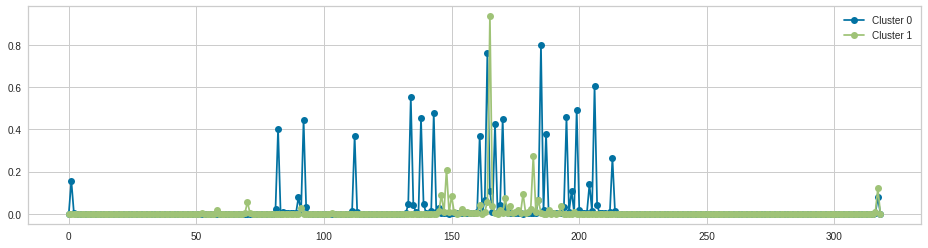

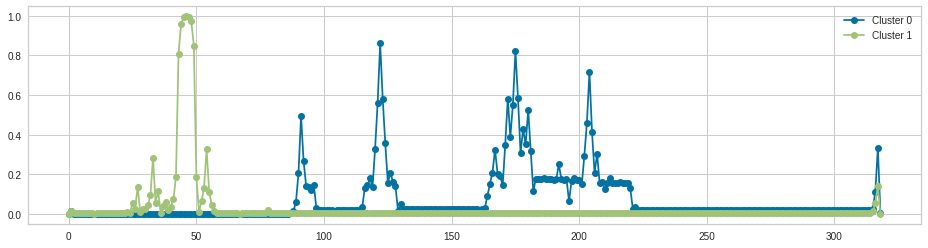

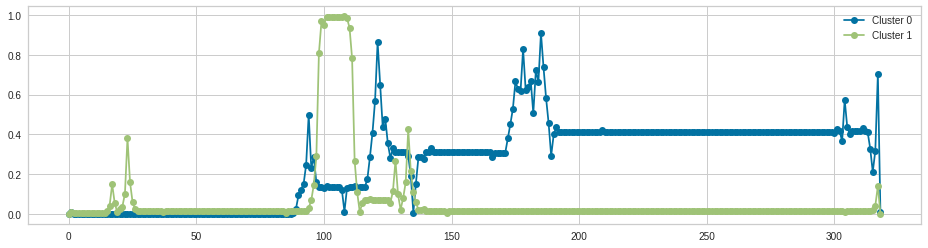

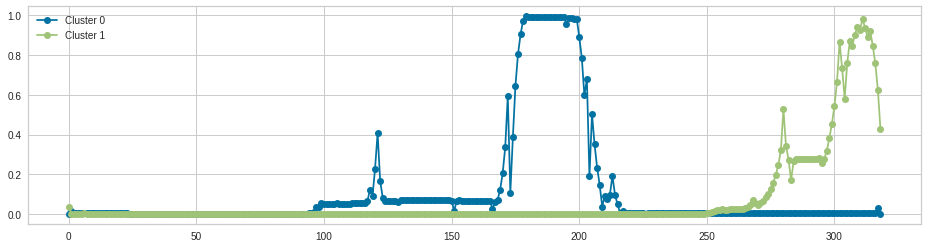

In [ ]:
for ii in range(len(timeserieskmeans_dtw)):
  plt.figure(figsize=(16, 4))
  for i in range(0, len(timeserieskmeans_dtw[ii].cluster_centers_)):
      plt.plot(timeserieskmeans_dtw[ii].cluster_centers_[i], marker='o', label='Cluster %s' % i)
  plt.tick_params(axis='both', which='major', labelsize=10)
  #plt.xticks(range(0, len(X.columns)), X.columns, fontsize=8)
  plt.legend(fontsize=10)
  plt.show()

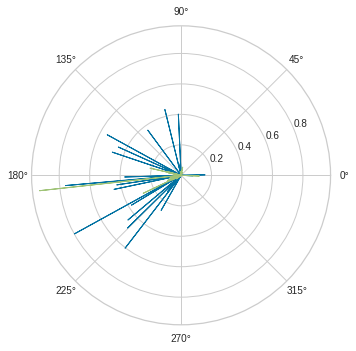

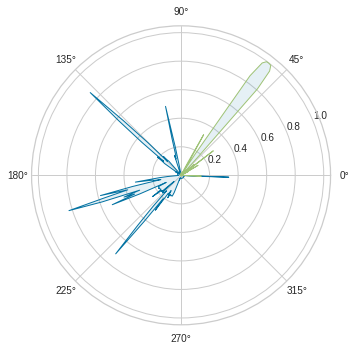

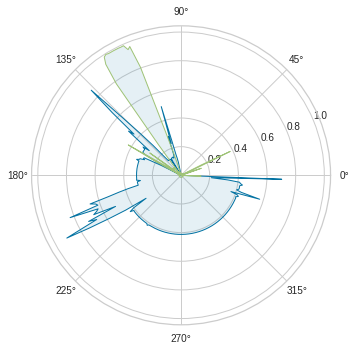

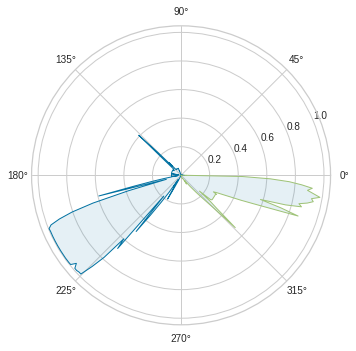

In [ ]:
for ii in range(len(timeserieskmeans_dtw)):
  # number of variable
  N = 319
  # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
  for i in range(0, len(timeserieskmeans_dtw[ii].cluster_centers_)):
      angles = [n / float(N) * 2 * pi for n in range(N)]
      values = timeserieskmeans_dtw[ii].cluster_centers_[i].tolist()
      values += values[:1]
      angles += angles[:1]
  # Initialise the spider plot
      ax = plt.subplot(polar=True)
  # Draw one axe per variable + add labels labels yet
      #plt.xticks(angles[:-1], X.columns, color='grey', size=8) 
  # Plot data
      ax.plot(angles, values, linewidth=1, linestyle='solid')
  # Fill area
      ax.fill(angles, values, 'b', alpha=0.1)
  plt.show()

### Clusters characterization

In [ ]:
users_profile_all = pd.read_csv('/content/drive/Shareddrives/DataMining/dataset/users_profile.csv', lineterminator='\n')

In [ ]:
users_profile_all = users_profile_all.merge(ts_users, on='user_id')

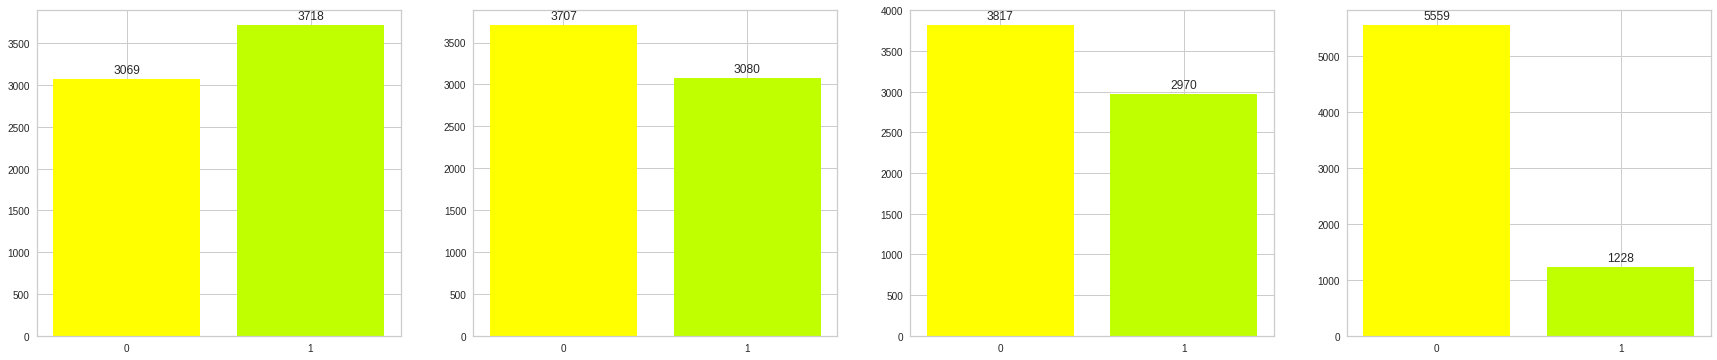

In [ ]:
fig, ax = plt.subplots(ncols=len(timeserieskmeans_dtw), figsize=(30,6))
for i in range(len(timeserieskmeans_dtw)):
  hist, bins = np.histogram(timeserieskmeans_dtw[i].labels_, bins=range(0, len(set(timeserieskmeans_dtw[i].labels_)) + 1))
  #plt.stairs(hist, bins)
  clusters = ax[i].bar(range(len(dict(zip(bins, hist)))), list(dict(zip(bins, hist)).values()), align='center', color=['#ffff00', '#bfff00', '#00ff40', '#00ff80', '#00ffbf', '#00ffff', '#00bfff', '#0080ff', '#0040ff', '#0000ff', '#4000ff', '#8000ff', '#bf00ff', '#ff00ff', '#ff00bf', '#ff0080', '#ff0040', '#ff0000', '#756bb1'])
  ax[i].set_xticks(range(len(dict(zip(bins, hist)))), list(dict(zip(bins, hist)).keys()))
  ax[i].bar_label(clusters, padding=3)
plt.show()

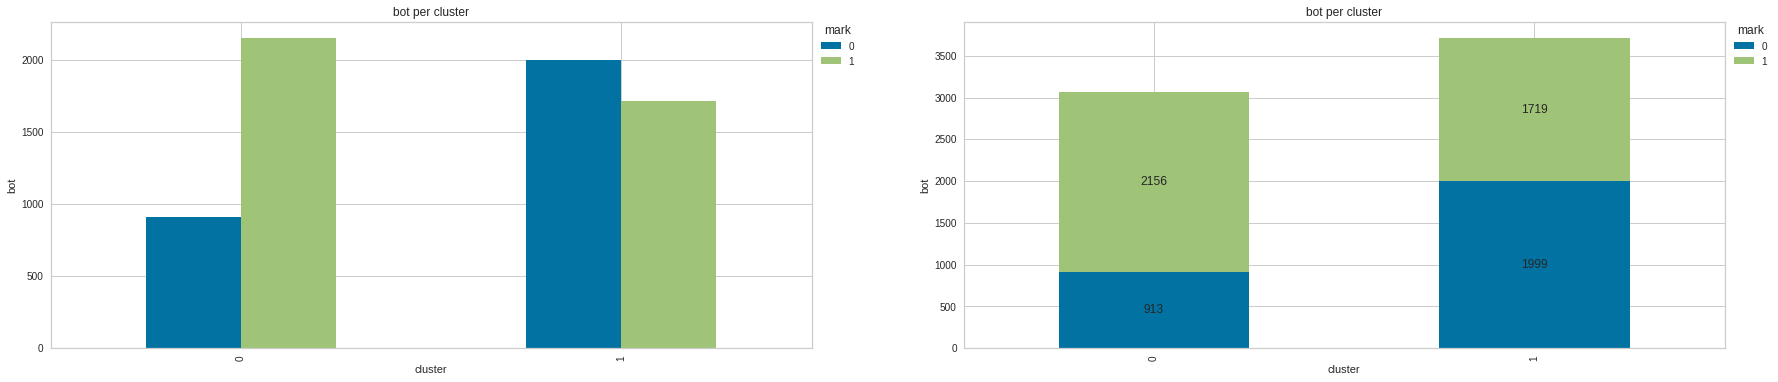

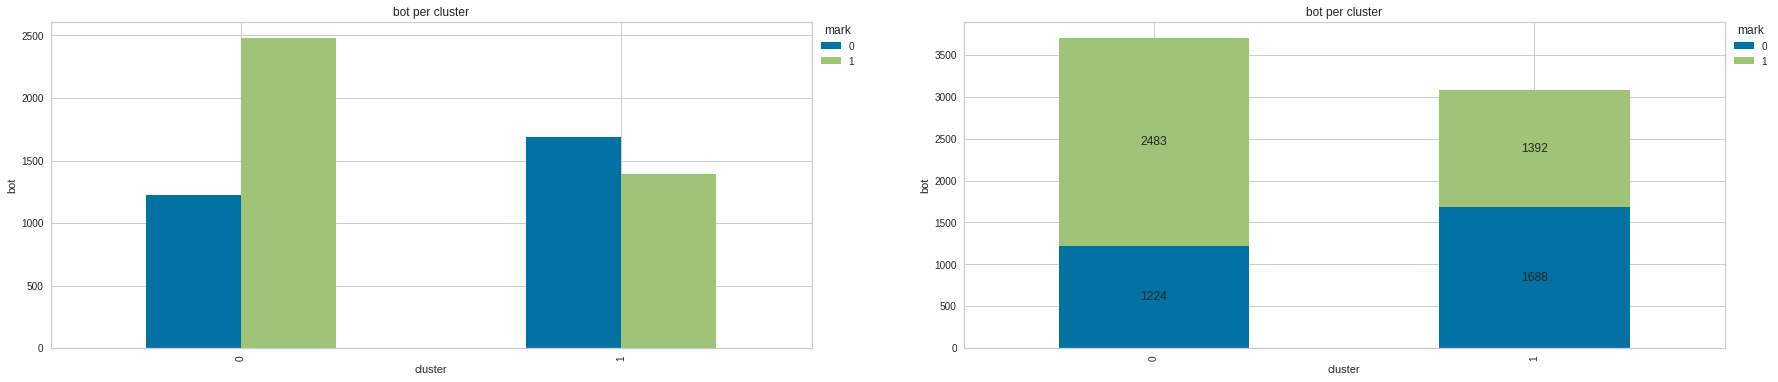

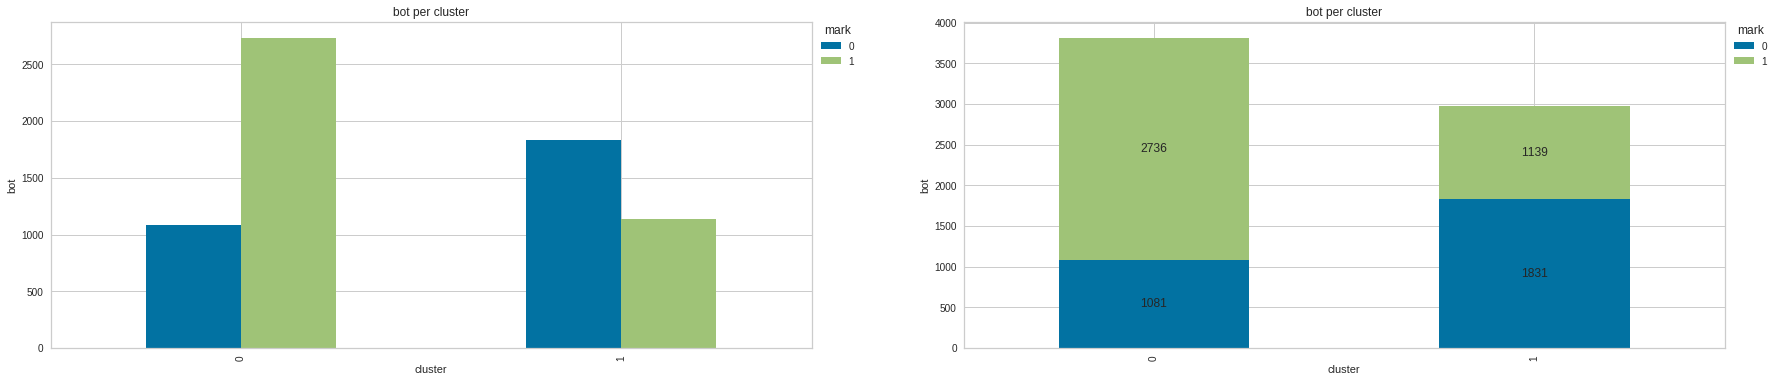

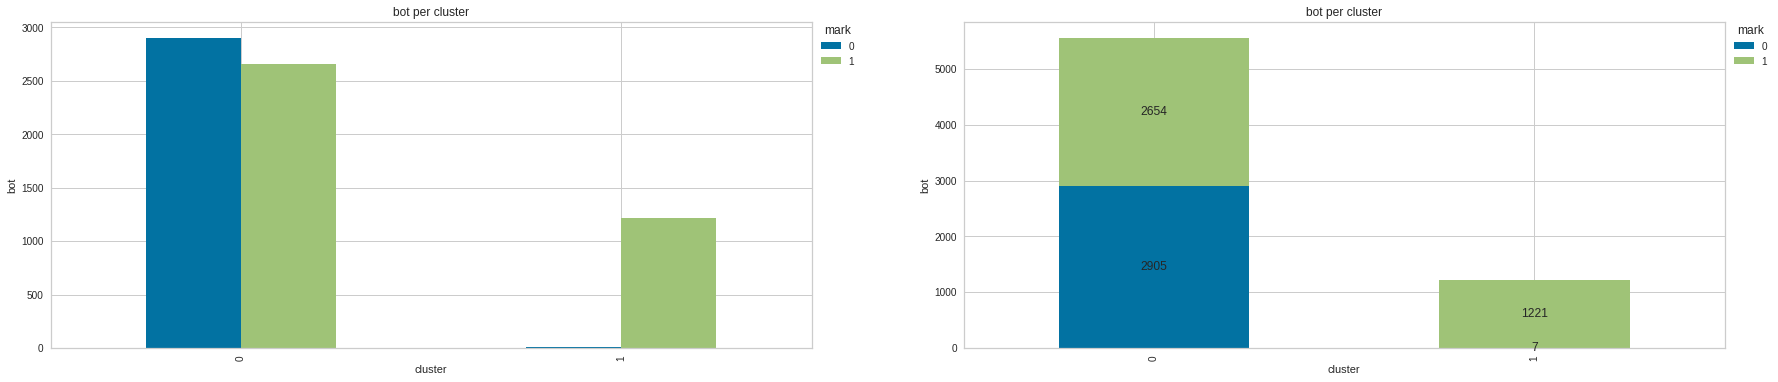

In [ ]:
for i in range(len(timeserieskmeans_dtw)):
  bot_ct = pd.crosstab(timeserieskmeans_dtw[i].labels_,ts_users['bot'])

  f, axs = plt.subplots(ncols=2, figsize=(30,6))

  ax1 = bot_ct.plot(kind='bar', stacked=False, title='bot per cluster', ax=axs[0])
  ax1.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  axs[0].set_xlabel('cluster')
  axs[0].set_ylabel('bot')

  ax2 = bot_ct.plot(kind='bar', stacked=True, title='bot per cluster', ax=axs[1])
  ax2.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  # add counts
  for c in ax2.containers:
      # set the bar label
      ax2.bar_label(c, label_type='center')
  axs[1].set_xlabel('cluster')
  axs[1].set_ylabel('bot')

  plt.show()

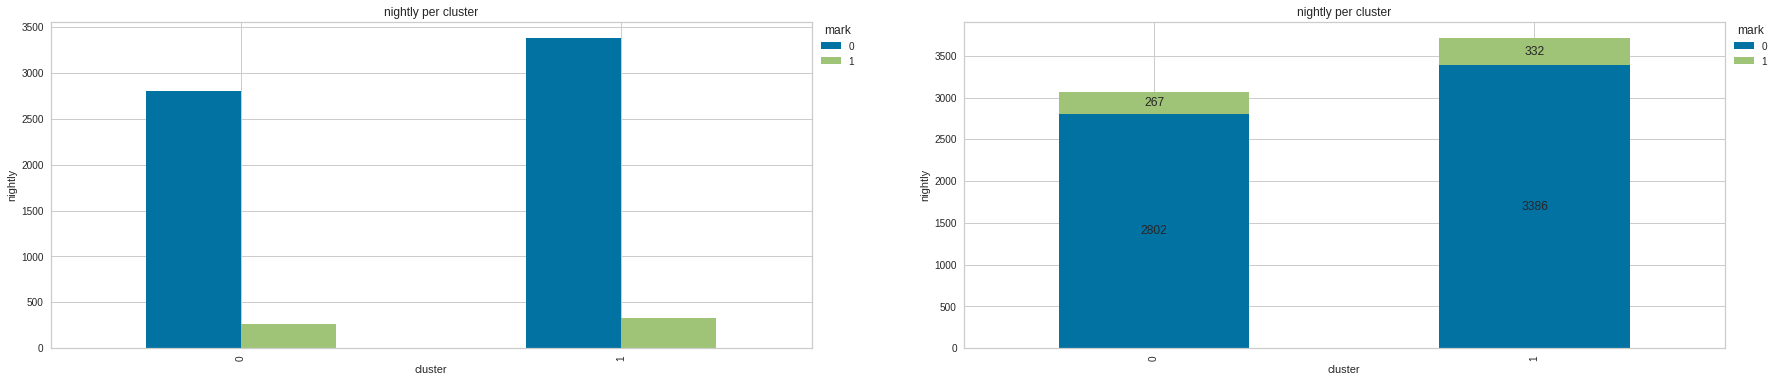

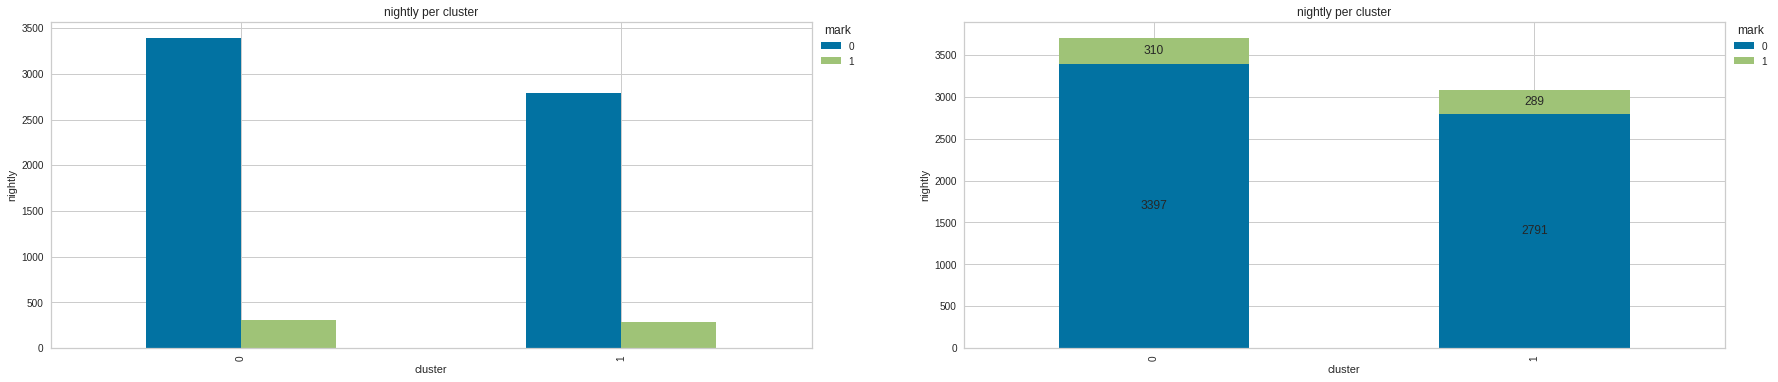

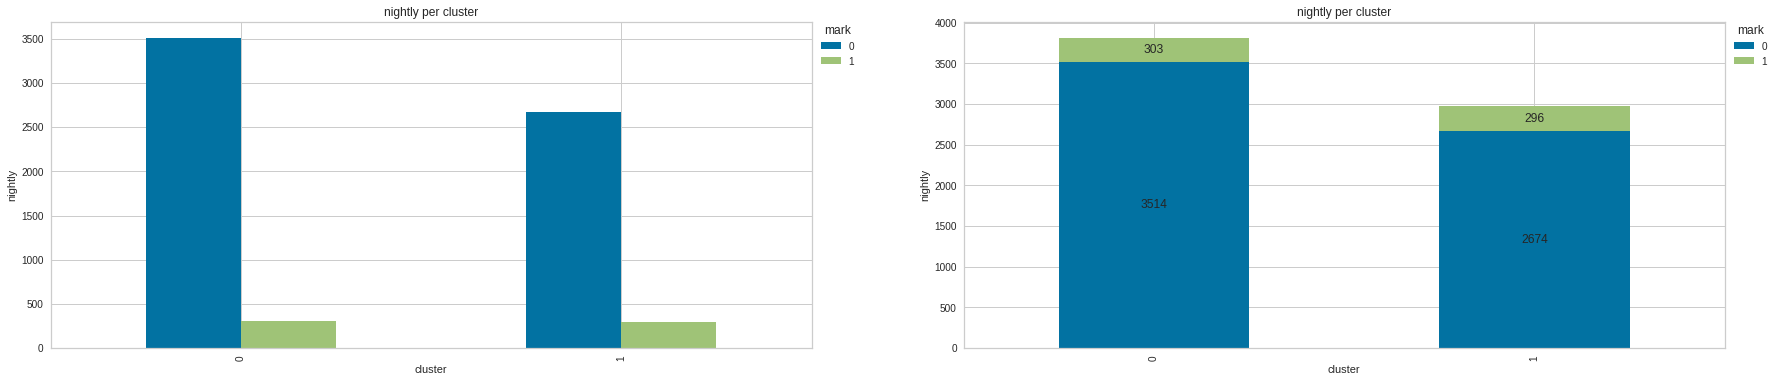

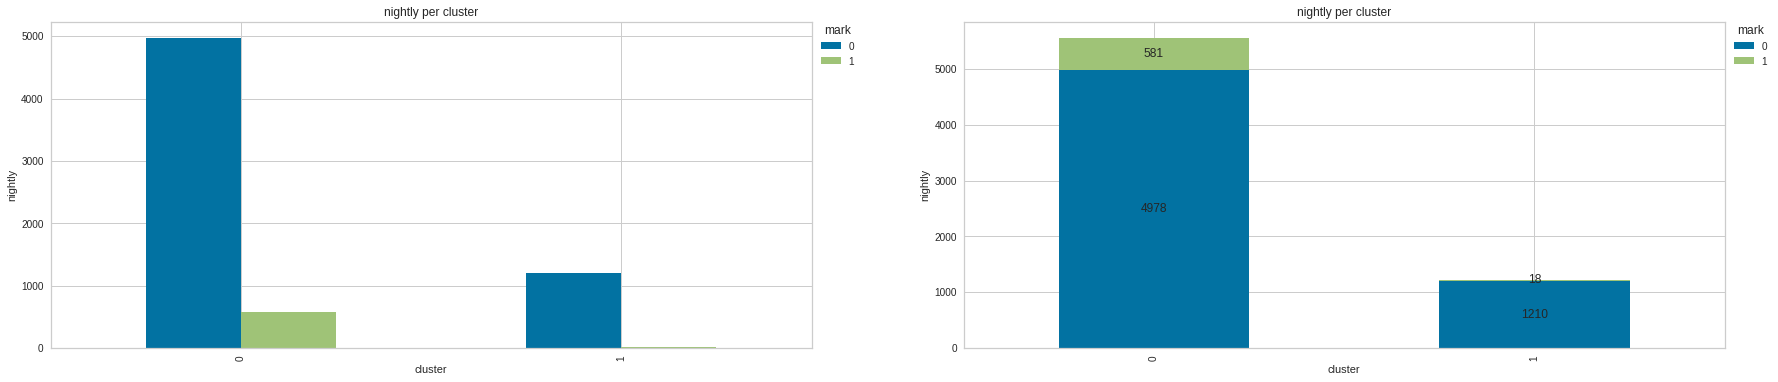

In [ ]:
for i in range(len(timeserieskmeans_dtw)):
  nightly_ct = pd.crosstab(timeserieskmeans_dtw[i].labels_,users_profile_all['nightly'])

  f, axs = plt.subplots(ncols=2, figsize=(30,6))

  ax1 = nightly_ct.plot(kind='bar', stacked=False, title='nightly per cluster', ax=axs[0])
  ax1.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  axs[0].set_xlabel('cluster')
  axs[0].set_ylabel('nightly')

  ax2 = nightly_ct.plot(kind='bar', stacked=True, title='nightly per cluster', ax=axs[1])
  ax2.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  # add counts
  for c in ax2.containers:
      # set the bar label
      ax2.bar_label(c, label_type='center')
  axs[1].set_xlabel('cluster')
  axs[1].set_ylabel('nightly')

  plt.show()

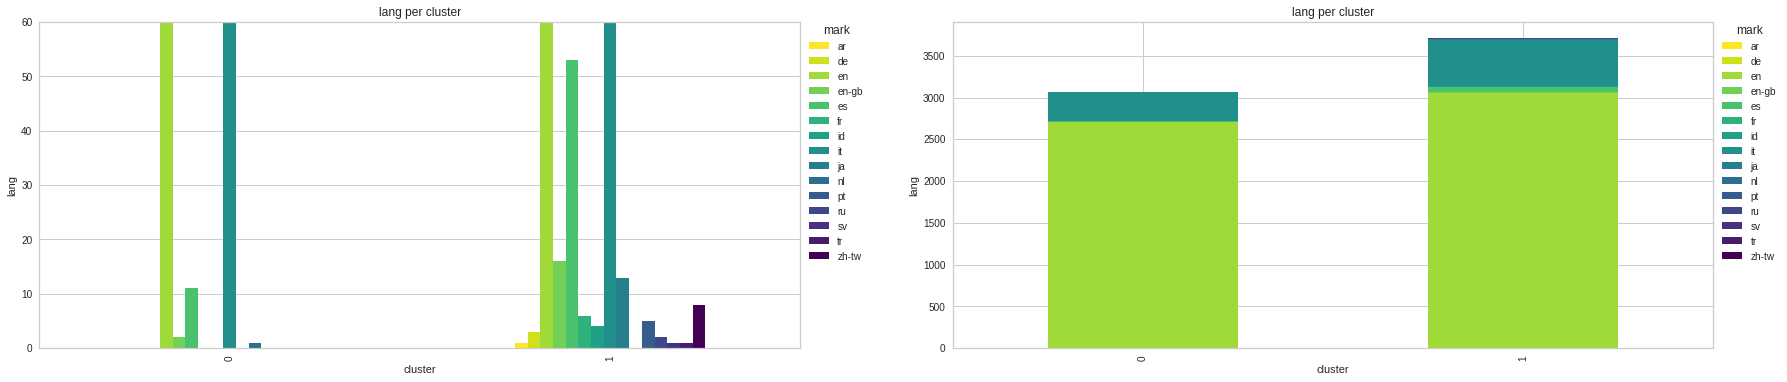

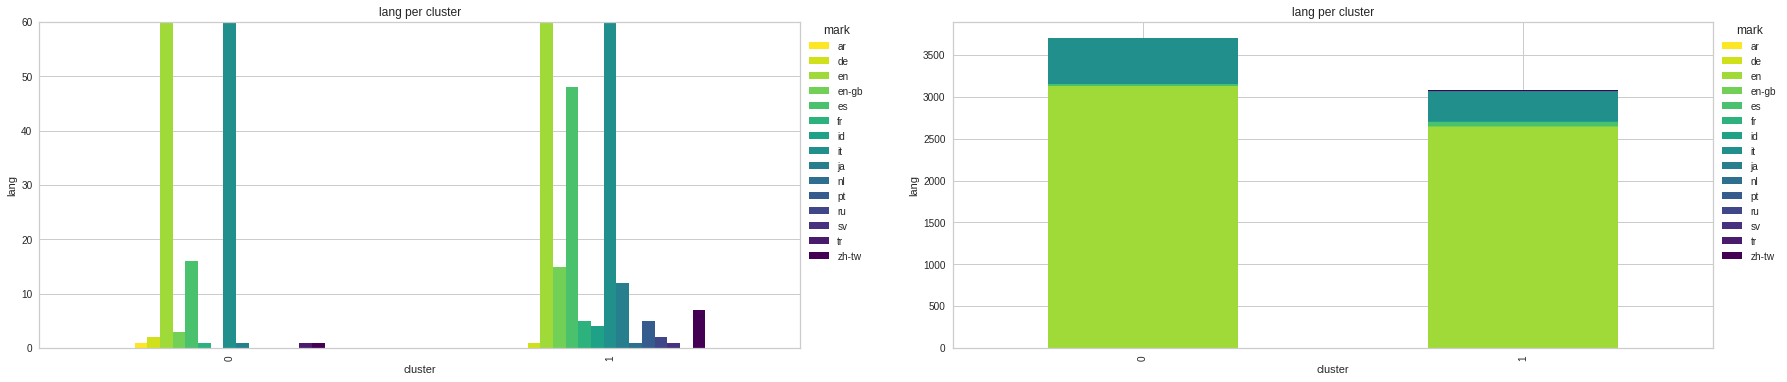

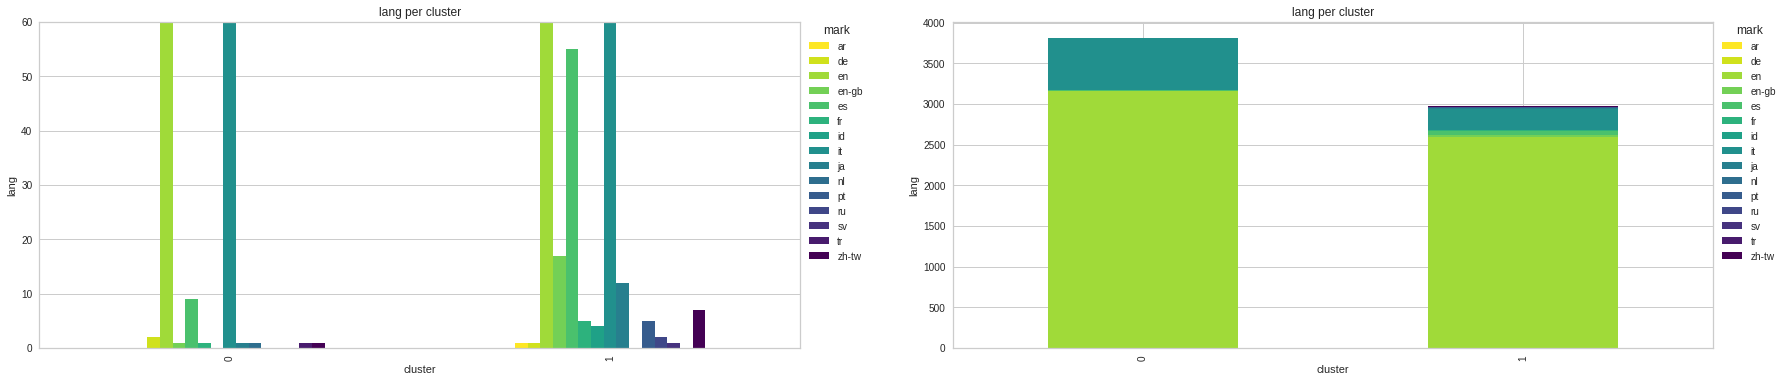

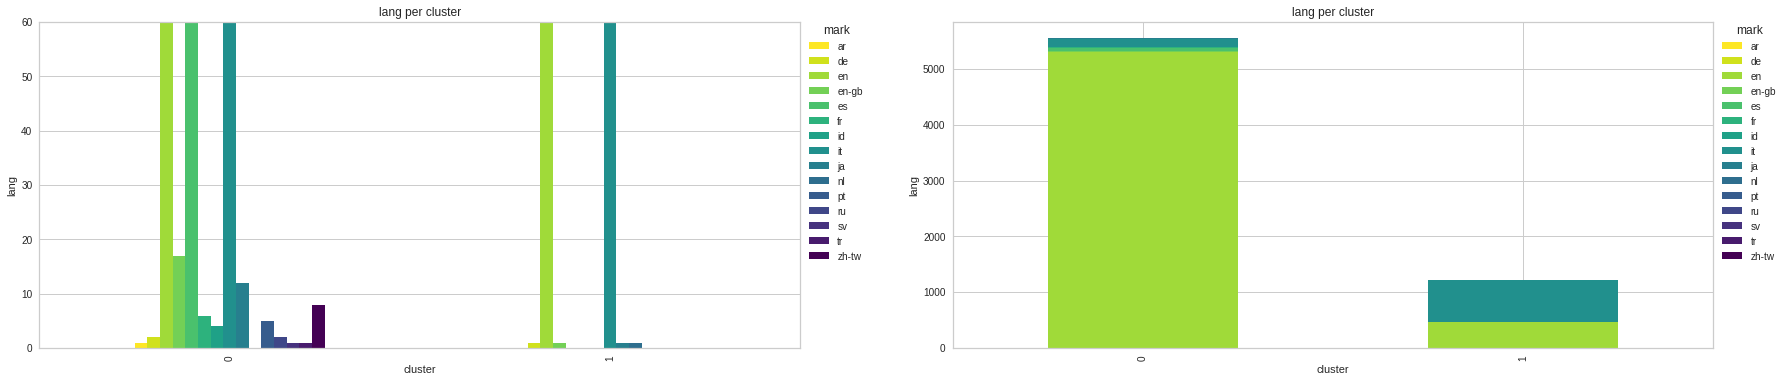

In [ ]:
for i in range(len(timeserieskmeans_dtw)):
  lang_ct = pd.crosstab(timeserieskmeans_dtw[i].labels_,users_profile_all['lang'])

  f, axs = plt.subplots(ncols=2, figsize=(30,6))

  ax1 = lang_ct.plot(kind='bar', stacked=False, title='lang per cluster', ax=axs[0], colormap="viridis_r")
  ax1.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  axs[0].set_xlabel('cluster')
  axs[0].set_ylabel('lang')
  axs[0].set_ylim(0, 60) 

  ax2 = lang_ct.plot(kind='bar', stacked=True, title='lang per cluster', ax=axs[1], colormap="viridis_r")
  ax2.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  axs[1].set_xlabel('cluster')
  axs[1].set_ylabel('lang')

  plt.show()

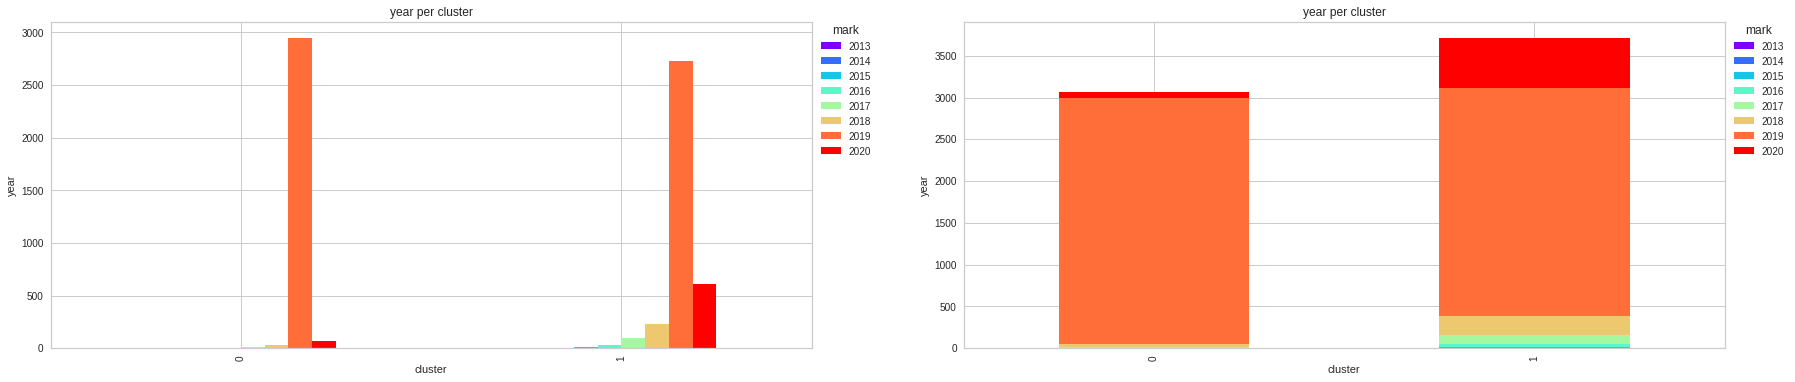

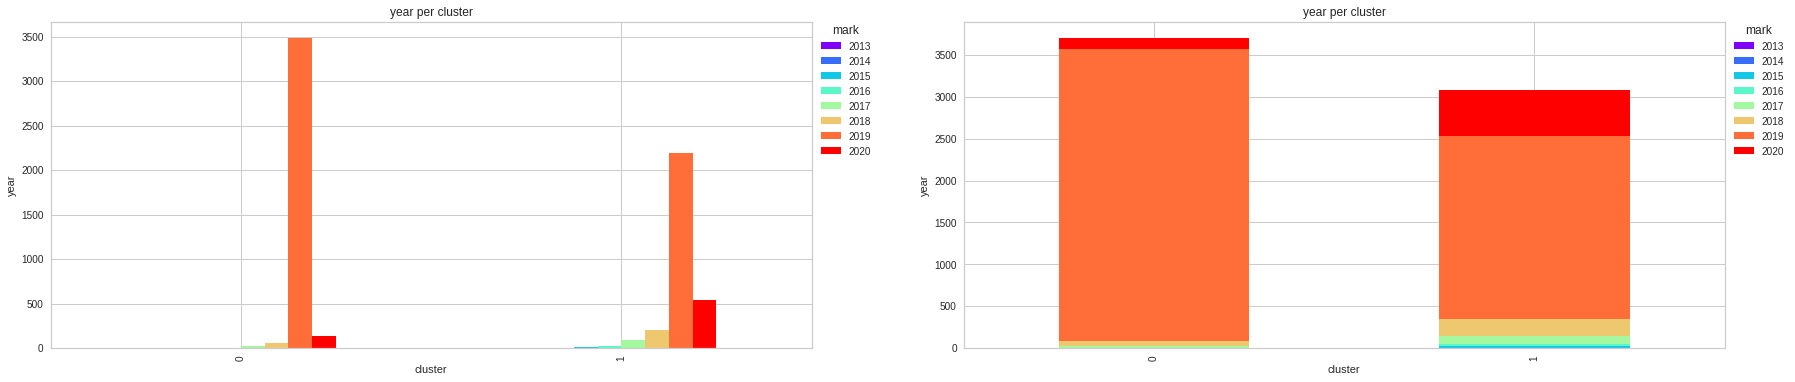

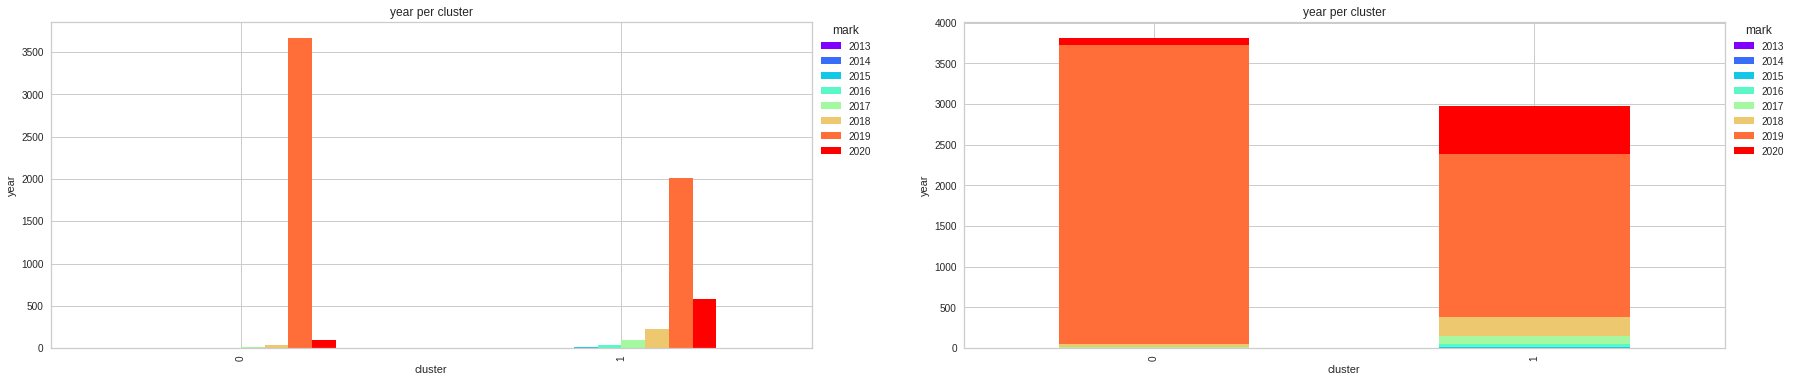

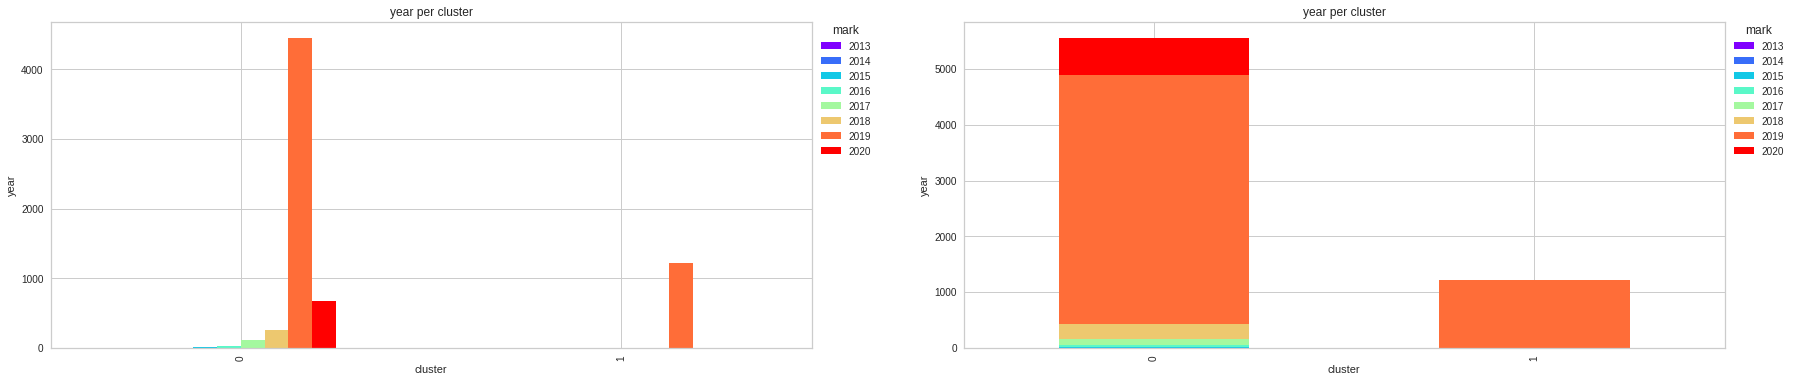

In [ ]:
for i in range(len(timeserieskmeans_dtw)):
  year_ct = pd.crosstab(timeserieskmeans_dtw[i].labels_,users_profile_all['most_freq_year'])

  f, axs = plt.subplots(ncols=2, figsize=(30,6))

  ax1 = year_ct.plot(kind='bar', stacked=False, title='year per cluster', ax=axs[0], colormap="rainbow")
  ax1.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  axs[0].set_xlabel('cluster')
  axs[0].set_ylabel('year')

  ax2 = year_ct.plot(kind='bar', stacked=True, title='year per cluster', ax=axs[1], colormap="rainbow")
  ax2.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  axs[1].set_xlabel('cluster')
  axs[1].set_ylabel('year')

  plt.show()

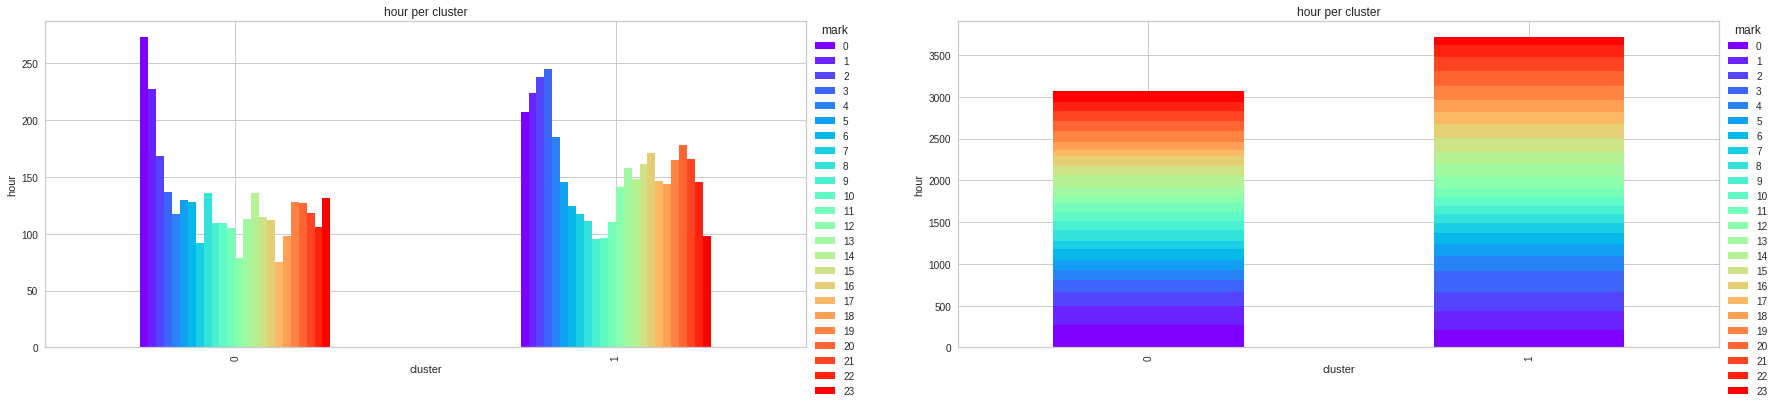

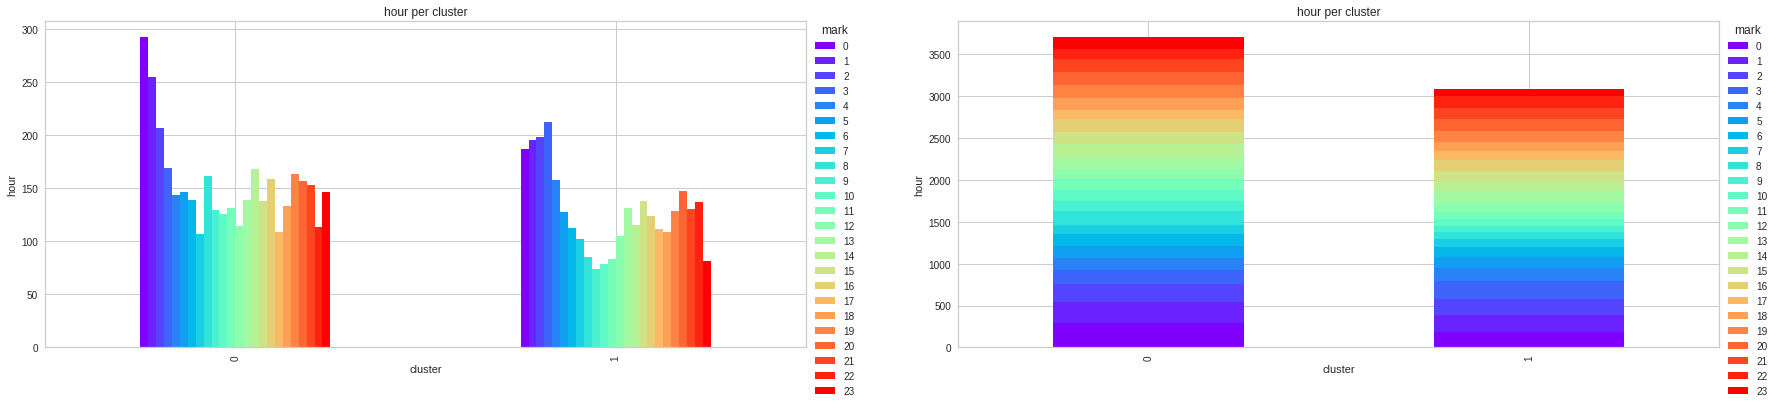

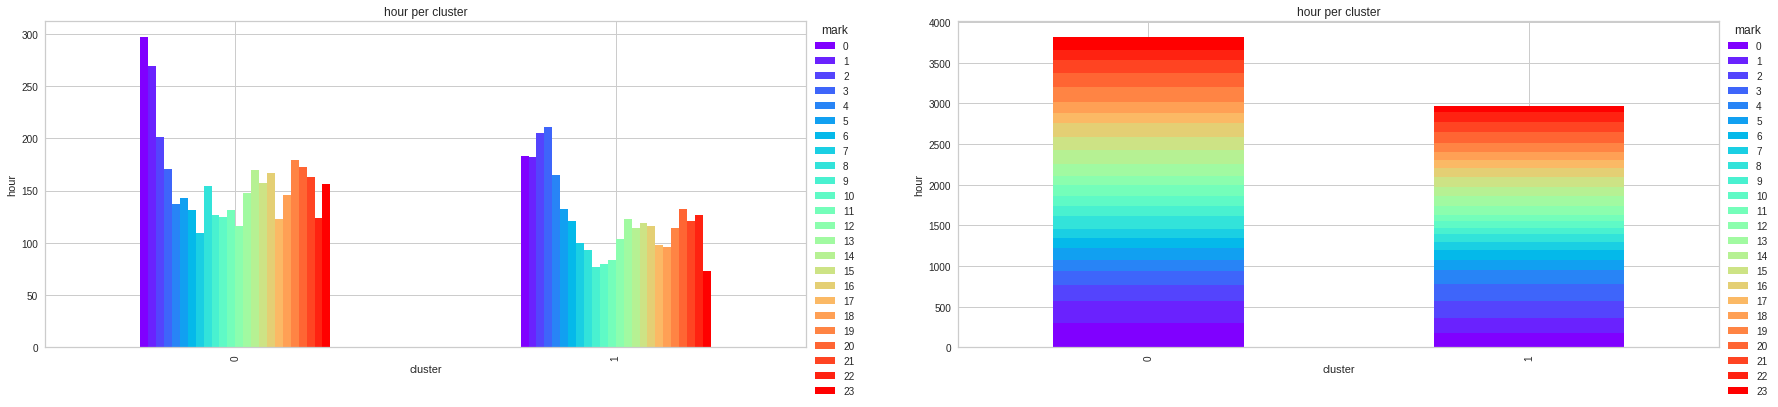

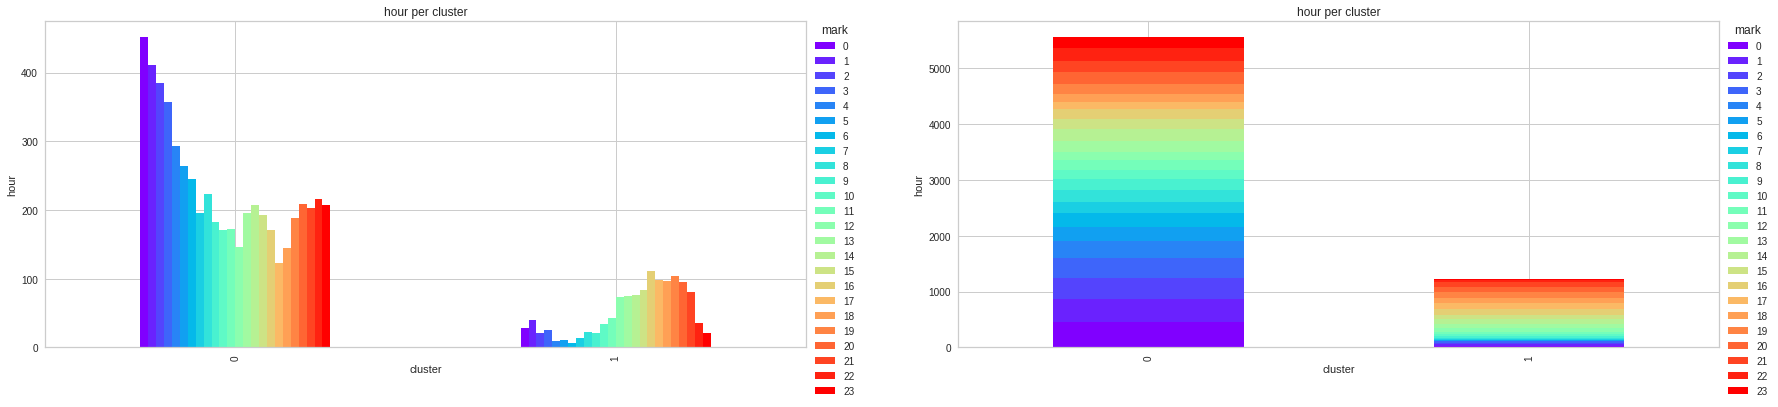

In [ ]:
for i in range(len(timeserieskmeans_dtw)):
  hour_ct = pd.crosstab(timeserieskmeans_dtw[i].labels_,users_profile_all['most_freq_hour'])

  f, axs = plt.subplots(ncols=2, figsize=(30,6))

  ax1 = hour_ct.plot(kind='bar', stacked=False, title='hour per cluster', ax=axs[0], colormap="rainbow")
  ax1.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  axs[0].set_xlabel('cluster')
  axs[0].set_ylabel('hour')

  ax2 = hour_ct.plot(kind='bar', stacked=True, title='hour per cluster', ax=axs[1], colormap="rainbow")
  ax2.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  axs[1].set_xlabel('cluster')
  axs[1].set_ylabel('hour')

  plt.show()

In [ ]:
cols = []
for i in range(len(timeserieskmeans_dtw)):
  s = 'label_K=2 '+str(i+2)
  cols.append(s)

In [ ]:
for i in range(len(timeserieskmeans_dtw)):
  users_profile_all[cols[i]]=timeserieskmeans_dtw[i].labels_

In [ ]:
users_profile_all.head()

user_id                  name lang  bot_x      user_created_at  \
0   722623          Buzz Jackson   en      0  2012-01-31 00:54:34   
1   755746  Sarah Friedlander G.   en      0  2012-02-09 05:21:24   
2   806975          Mrinal Desai   en      0  2012-03-03 20:00:04   
3   887281          Paul Youlten   en      0  2012-03-11 22:25:08   
4  1382561                jojoko   en      0  2012-03-18 23:24:35   

   statuses_count  retweet_count  reply_count  favorite_count  num_hashtags  \
0           11770      1158520.0          0.0           969.0         766.0   
1           18035       317861.0          0.0           209.0         488.0   
2           28400       173785.0          0.0           529.0         643.0   
3             626         9894.0          0.0            30.0         180.0   
4            8236       276333.0          0.0           612.0         630.0   

   ...  men_entropy  avg_textlen  days_on_tw  activity_richness  \
0  ...      0.00000    85.026719        3893           0.519137   
1  ...      0.00000    84.281111        3884           0.519310   
2  ...      0.00000    74.629235        3861           0.680653   
3  ...      0.00000    88.407975        3853           0.169219   
4  ...      9.74366    81.041131        3846           0.507280   

                                        SuccessScore  bot_y  label_K=2 2  \
0  [-1.0, -1.0, 1.5492957746478877, 1626.39344262...      0            1   
1  [-1.0, -1.0, 0.0, 0.0, 0.0, 0.1639344262295082...      0            1   
2  [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....      0            1   
3  [-1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0...      0            1   
4  [-1.0, -1.0, 60.0940070505288, 0.4480651731160...      0            1   

   label_K=2 3  label_K=2 4  label_K=2 5  
0            1            1            0  
1            1            1            0  
2            1            1            0  
3            1            1            0  
4            1            1            0  

[5 rows x 39 columns]

In [ ]:
for i in range(len(cols)):
  x = users_profile_all[['statuses_count','retweet_count','favorite_count','num_hashtags','num_urls','num_mentions','max_retweet_count',
                     'max_favorite_count','std_retweet_count','std_favorite_count','popularity','tweet_richness','text_entropy',
                     'avg_textlen','days_on_tw','activity_richness',cols[i]]].groupby(cols[i]).mean()
  display(x)

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 2                                                                
0               1200.632454   78651.780059      490.570870     62.750733   
1               4592.008607  391646.164605      806.921463    279.020979   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 2                                                                    
0            129.260345    120.657217        5329.866406           33.869664   
1            299.731576    572.672673       53351.936794          255.160301   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 2                                                      
0                   224.543777            1.122477   40.784595   
1                  2015.112425            7.239348  250.377959   

             tweet_richness  text_entropy  avg_textlen   days_on_tw  \
label_K=2 2                                                           
0                  0.491263      2.025078    70.268518  1506.747801   
1                  0.771665      3.371021    74.532866  1932.940022   

             activity_richness  
label_K=2 2                     
0                     0.321395  
1                     0.672492

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 3                                                                
0               1725.906933  160815.057459      663.240896    119.598597   
1               4662.302597  357591.342532      664.630519    255.399351   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 3                                                                    
0            128.320205    220.240626       12135.397087           55.160777   
1            336.175000    546.448701       55108.423377          275.373701   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 3                                                      
0                   515.209086            1.758162   89.085261   
1                  2036.179470            7.741321  235.660426   

             tweet_richness  text_entropy  avg_textlen   days_on_tw  \
label_K=2 3                                                           
0                  0.540818      2.359125    71.584037  1572.039385   
1                  0.770106      3.247774    73.832874  1942.639610   

             activity_richness  
label_K=2 3                     
0                     0.382709  
1                     0.671423

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 4                                                                
0               2093.526592  130073.809798      652.730155    106.802987   
1               4298.598653  404387.549158      678.190236    276.873737   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 4                                                                    
0            201.211947    184.317527        9680.472884           51.953367   
1            250.193939    604.698316       59855.049158          287.651852   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 4                                                      
0                   383.401635            1.648049   65.345742   
1                  2261.908690            8.104436  271.598814   

             tweet_richness  text_entropy  avg_textlen   days_on_tw  \
label_K=2 4                                                           
0                  0.510511      2.359425    72.348531  1592.451402   
1                  0.817548      3.280301    72.933647  1930.132323   

             activity_richness  
label_K=2 4                     
0                     0.447134  
1                     0.599318

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 5                                                                
0               2623.676561  302389.641662       429.80716    177.090304   
1               5026.719055   13468.025244      1723.45114    199.948697   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 5                                                                    
0            127.014211    415.190502       37428.545782          142.252024   
1            655.561889    155.903909        5419.035016          213.235342   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 5                                                      
0                  1439.377968            4.355662  187.773186   
1                   146.425673            5.006229    9.969083   

             tweet_richness  text_entropy  avg_textlen   days_on_tw  \
label_K=2 5                                                           
0                  0.705361      2.549586    69.522427  1668.140673   
1                  0.371040      3.725790    86.557088  2066.519544   

             activity_richness  
label_K=2 5                     
0                     0.377075  
1                     1.132350

In [ ]:
for i in range(len(cols)):
  x = users_profile_all[['statuses_count','retweet_count','favorite_count','num_hashtags','num_urls','num_mentions','max_retweet_count',
                     'max_favorite_count','std_retweet_count','std_favorite_count','popularity','tweet_richness','text_entropy',
                     'avg_textlen','days_on_tw','activity_richness',cols[i]]].groupby(cols[i]).std()
  display(x)

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 2                                                                
0               4281.739398   9.809699e+05     3058.961982    198.782209   
1              10294.055661   2.073817e+06     4207.717145    609.466381   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 2                                                                    
0            432.237821    347.735939       32534.668445          476.409512   
1            564.225970    789.775082      115533.938497         1349.726325   

             std_retweet_count  std_favorite_count   popularity  \
label_K=2 2                                                       
0                  1599.617532           10.658996   431.329775   
1                  5011.279580           44.000238  1017.880480   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 2                                                          
0                  0.678116      2.806488     9.614772  397.632290   
1                  0.713717      4.208214    15.393863  618.801899   

             activity_richness  
label_K=2 2                     
0                     0.467150  
1                     0.574427

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 3                                                                
0               7471.161348   1.403060e+06     4710.604419    421.583909   
1               8976.476464   1.952848e+06     2010.847868    537.892058   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 3                                                                    
0            409.469474    539.497283       50872.570172          598.801331   
1            600.777178    759.325993      119598.853541         1412.114474   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 3                                                      
0                  2843.951674           17.181948  780.747271   
1                  4859.817795           45.781292  845.398993   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 3                                                          
0                  0.725993      3.226485    11.320698  456.263838   
1                  0.673017      4.153841    15.201897  627.198266   

             activity_richness  
label_K=2 3                     
0                     0.491961  
1                     0.588425

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 4                                                                
0               7567.673928   1.223411e+06     4671.544822    402.094840   
1               9043.173880   2.113772e+06     1960.061877    555.222209   

              num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 4                                                                   
0            534.95643    498.970841       46161.403898          567.198411   
1            488.77487    775.963523      122292.894112         1448.532515   

             std_retweet_count  std_favorite_count   popularity  \
label_K=2 4                                                       
0                  2027.895939           16.353884   551.916045   
1                  5350.570724           46.852602  1048.230918   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 4                                                          
0                  0.693748      3.191226    11.048459  447.668641   
1                  0.696993      4.215349    15.665614  651.072326   

             activity_richness  
label_K=2 4                     
0                     0.557769  
1                     0.543616

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 5                                                                
0               7264.065783   1.849441e+06     2391.893279    452.030486   
1              11783.825154   8.114683e+04     7062.644989    601.778644   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 5                                                                    
0            334.796837    691.963060       98347.972644         1034.042605   
1            857.102321    497.824639       39866.676327         1142.717490   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 5                                                      
0                  4322.646550           35.297955  895.839610   
1                   925.566001           23.580690   53.428568   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 5                                                          
0                  0.745983      3.618960    12.393205  594.438269   
1                  0.433889      3.919636     6.350505  271.098196   

             activity_richness  
label_K=2 5                     
0                     0.470624  
1                     0.493214

In [ ]:
for i in range(len(cols)):
  x = users_profile_all[['statuses_count','retweet_count','favorite_count','num_hashtags','num_urls','num_mentions','max_retweet_count',
                     'max_favorite_count','std_retweet_count','std_favorite_count','popularity','tweet_richness','text_entropy',
                     'avg_textlen','days_on_tw','activity_richness',cols[i]]].groupby(cols[i]).max()
  display(x)

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 2                                                                
0                     99563     47425166.0        105015.0        2738.0   
1                    200000     91037102.0        221102.0       16228.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 2                                                                  
0              3613.0        4067.0           500000.0             10000.0   
1              3749.0        6284.0           500000.0             10000.0   

             std_retweet_count  std_favorite_count    popularity  \
label_K=2 2                                                        
0                 56277.447006          272.969840  19247.366477   
1                 95097.011295          916.660125  29482.488281   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 2                                                          
0                 10.440860     11.757003   124.876111        3559   
1                  9.703704     11.806861   146.675595        3893   

             activity_richness  
label_K=2 2                     
0                     2.467515  
1                     2.783033

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 3                                                                
0                    200000     47425166.0        221102.0        9611.0   
1                    200000     91037102.0         49243.0       16228.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 3                                                                  
0              3749.0        4904.0           500000.0             10000.0   
1              3639.0        6284.0           500000.0             10000.0   

             std_retweet_count  std_favorite_count    popularity  \
label_K=2 3                                                        
0                 95097.011295          690.046878  29482.488281   
1                 56734.038613          916.660125  24651.463851   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 3                                                          
0                 10.440860     11.760029   146.675595        3796   
1                  9.703704     11.806861   127.692488        3893   

             activity_richness  
label_K=2 3                     
0                     2.689978  
1                     2.783033

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 4                                                                
0                    200000     47425166.0        221102.0        9611.0   
1                    200000     91037102.0         49243.0       16228.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 4                                                                  
0              3749.0        4904.0           500000.0             10000.0   
1              3639.0        6284.0           500000.0             10000.0   

             std_retweet_count  std_favorite_count    popularity  \
label_K=2 4                                                        
0                 56277.447006          690.046878  21587.464847   
1                 95097.011295          916.660125  29482.488281   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 4                                                          
0                 10.440860     11.760029   146.675595        3795   
1                  9.703704     11.806861   127.692488        3893   

             activity_richness  
label_K=2 4                     
0                     2.783033  
1                     2.696154

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 5                                                                
0                    200000     91037102.0        105015.0       16228.0   
1                    200000      1560343.0        221102.0        9611.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 5                                                                  
0              3639.0        6284.0           500000.0             10000.0   
1              3749.0        4835.0           500000.0             10000.0   

             std_retweet_count  std_favorite_count    popularity  \
label_K=2 5                                                        
0                 95097.011295          916.660125  29482.488281   
1                 12724.654514          262.431665    783.324590   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 5                                                          
0                 10.440860     11.806861   127.692488        3893   
1                  4.142281     11.760029   146.675595        3304   

             activity_richness  
label_K=2 5                     
0                     2.696154  
1                     2.783033

In [ ]:
for i in range(len(cols)):
  x = users_profile_all[['statuses_count','retweet_count','favorite_count','num_hashtags','num_urls','num_mentions','max_retweet_count',
                     'max_favorite_count','std_retweet_count','std_favorite_count','popularity','tweet_richness','text_entropy',
                     'avg_textlen','days_on_tw','activity_richness',cols[i]]].groupby(cols[i]).min()
  display(x)

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 2                                                                
0                        16            0.0             0.0           0.0   
1                         5            0.0             0.0           0.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 2                                                                  
0                 0.0           0.0                0.0                 0.0   
1                 0.0           0.0                0.0                 0.0   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 2                                                      
0                          0.0                 0.0         0.0   
1                          0.0                 0.0         0.0   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 2                                                          
0                       0.0           0.0    37.776143        1194   
1                       0.0           0.0    29.320513        1155   

             activity_richness  
label_K=2 2                     
0                     0.026423  
1                     0.003207

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 3                                                                
0                        15            0.0             0.0           0.0   
1                         5            0.0             0.0           0.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 3                                                                  
0                 0.0           0.0                0.0                 0.0   
1                 0.0           0.0                0.0                 0.0   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 3                                                      
0                          0.0                 0.0         0.0   
1                          0.0                 0.0         0.0   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 3                                                          
0                       0.0           0.0    37.776143        1190   
1                       0.0           0.0    29.320513        1155   

             activity_richness  
label_K=2 3                     
0                     0.026423  
1                     0.003207

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 4                                                                
0                         5            0.0             0.0           0.0   
1                         5            0.0             0.0           0.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 4                                                                  
0                 0.0           0.0                0.0                 0.0   
1                 0.0           0.0                0.0                 0.0   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 4                                                      
0                          0.0                 0.0         0.0   
1                          0.0                 0.0         0.0   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 4                                                          
0                       0.0           0.0    37.776143        1214   
1                       0.0           0.0    29.320513        1155   

             activity_richness  
label_K=2 4                     
0                     0.030626  
1                     0.003207

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 5                                                                
0                         5            0.0             0.0           0.0   
1                         5            1.0             1.0           0.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 5                                                                  
0                 0.0           0.0                0.0                 0.0   
1                 0.0           0.0                1.0                 1.0   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 5                                                      
0                     0.000000            0.000000    0.000000   
1                     0.028243            0.035158    0.002475   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 5                                                          
0                       0.0           0.0    29.320513        1155   
1                       0.0           0.0    49.458168        1270   

             activity_richness  
label_K=2 5                     
0                     0.003207  
1                     0.129258

# Feature-based clustering

In [ ]:
import scipy.stats as stats
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        #'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [ ]:
F = [list(calculate_features(x).values())[:-2] for x in X]
F = np.array(F)

Fw7 = [list(calculate_features(x).values())[:-2] for x in Xw7]
Fw7 = np.array(Fw7)

Fw14 = [list(calculate_features(x).values())[:-2] for x in Xw14]
Fw14 = np.array(Fw14)

Fw30 = [list(calculate_features(x).values())[:-2] for x in Xw30]
Fw30 = np.array(Fw30)

Fn = [list(calculate_features(x).values())[:-2] for x in Xn]
Fn = np.array(Fn)

Fwn7 = [list(calculate_features(x).values())[:-2] for x in Xwn7]
Fwn7 = np.array(Fwn7)

Fwn14 = [list(calculate_features(x).values())[:-2] for x in Xwn14]
Fwn14 = np.array(Fwn14)

Fwn30 = [list(calculate_features(x).values())[:-2] for x in Xwn30]
Fwn30 = np.array(Fwn30)

In [ ]:
np.any(np.isnan(F))  # false 

False

In [ ]:
np.any(np.isnan(Fw7))  # false 

False

In [ ]:
np.any(np.isnan(Fw14))  # false 

False

In [ ]:
np.any(np.isnan(Fw30))  # false 

False

In [ ]:
np.any(np.isnan(Fn))  # false 

False

In [ ]:
np.any(np.isnan(Fwn7))  # false 

False

In [ ]:
np.any(np.isnan(Fwn14))  # false 

False

In [ ]:
np.any(np.isnan(Fwn30))  # false 

False

In [ ]:
np.all(np.isfinite(F))   # true

True

In [ ]:
np.all(np.isfinite(Fw7))   # true

True

In [ ]:
np.all(np.isfinite(Fw14))   # true

True

In [ ]:
np.all(np.isfinite(Fw30))   # true

True

In [ ]:
np.all(np.isfinite(Fn))   # true

True

In [ ]:
np.all(np.isfinite(Fwn7))   # true

True

In [ ]:
np.all(np.isfinite(Fwn14))   # true

True

In [ ]:
np.all(np.isfinite(Fwn30))   # true

True

In [ ]:
Fn.shape

(6787, 10)

## KMeans

Parameters:
* **n_clusters** (default 8): The number of clusters
* **n_init** (default 10): Number of time k-means will be run with different initial centroids. The final results will be the best output in terms of inertia.
* **max_iter** (default 300): Maximum number of iterations of the k-means algorithm for a single run.

Output:
* **labels_**: Labels of each point
* **cluster\_centers_**: Coordinates of cluster centers
* **inertia_**: Sum of squared distances of samples to their closest cluster center.

In [ ]:
kmeans = []

kmeans1 = KMeans(n_clusters=2, n_init=10, max_iter=100)
kmeans1.fit(F)
kmeans.append(kmeans1)

kmeans2 = KMeans(n_clusters=2, n_init=10, max_iter=100)
kmeans2.fit(Fn)
kmeans.append(kmeans2)

kmeans3 = KMeans(n_clusters=2, n_init=10, max_iter=100)
kmeans3.fit(Fw7)
kmeans.append(kmeans3)

kmeans4 = KMeans(n_clusters=2, n_init=10, max_iter=100)
kmeans4.fit(Fwn7)
kmeans.append(kmeans4)

kmeans5 = KMeans(n_clusters=2, n_init=10, max_iter=100)
kmeans5.fit(Fw14)
kmeans.append(kmeans5)

kmeans6 = KMeans(n_clusters=2, n_init=10, max_iter=100)
kmeans6.fit(Fwn14)
kmeans.append(kmeans6)

kmeans7 = KMeans(n_clusters=2, n_init=10, max_iter=100)
kmeans7.fit(Fw30)
kmeans.append(kmeans7)

kmeans8 = KMeans(n_clusters=2, n_init=10, max_iter=100)
kmeans8.fit(Fwn30)
kmeans.append(kmeans8)

Labels

In [ ]:
for i in range(len(kmeans)):
  print(kmeans[i].labels_[:5])

[0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0]
[1 1 1 1 1]
[0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0]
[1 1 1 1 1]


Observing the size of each cluster

In [ ]:
for i in range(len(kmeans)):
  print(np.unique(kmeans[i].labels_, return_counts=True))

(array([0, 1], dtype=int32), array([6783,    4]))
(array([0, 1], dtype=int32), array([6437,  350]))
(array([0, 1], dtype=int32), array([6783,    4]))
(array([0, 1], dtype=int32), array([2846, 3941]))
(array([0, 1], dtype=int32), array([6783,    4]))
(array([0, 1], dtype=int32), array([2796, 3991]))
(array([0, 1], dtype=int32), array([6783,    4]))
(array([0, 1], dtype=int32), array([4251, 2536]))


In [ ]:
for i in range(len(kmeans)):
  hist, bins = np.histogram(kmeans[i].labels_, bins=range(0, len(set(kmeans[i].labels_)) + 1))
  print(dict(zip(bins, hist)))

{0: 6783, 1: 4}
{0: 6437, 1: 350}
{0: 6783, 1: 4}
{0: 2846, 1: 3941}
{0: 6783, 1: 4}
{0: 2796, 1: 3991}
{0: 6783, 1: 4}
{0: 4251, 1: 2536}


### Centers

In [ ]:
for i in range(len(kmeans)):
  print(kmeans[i].cluster_centers_)
  print("------------------------")

[[ 6.58571308e+01  4.98741595e+02  7.64258769e+06  4.09927219e+00
  -5.49125531e-01  9.31483310e-01  4.09927219e+00  1.89053100e+01
   8.34570393e+01  1.79738267e+01]
 [ 1.56884340e+04  2.79510672e+05  7.81262155e+10  2.25000000e+00
  -7.50000000e-01 -7.50000000e-01  2.25000000e+00  8.71103896e+00
   2.97500000e+01  9.46103896e+00]]
------------------------
[[2.49897288e-02 9.91634359e-02 1.14271107e-02 1.57192203e-03
  5.53284138e-05 2.24283954e-04 1.57192203e-03 6.08974992e-03
  2.10853537e-02 5.86546596e-03]
 [1.41294002e-01 2.64429348e-01 7.51947730e-02 2.23815841e-02
  3.68508396e-03 5.65704772e-03 2.23815841e-02 8.51072241e-02
  6.56110228e-01 7.94501764e-02]]
------------------------
[[6.58821330e+01 2.01426348e+02 1.16231433e+06 1.30415155e+01
  1.07868604e+00 3.44610983e+00 1.30415155e+01 4.45115436e+01
  1.37431692e+02 4.10654337e+01]
 [1.56884486e+04 1.04644325e+05 1.09504347e+10 3.71103896e+00
  5.51175015e-01 1.69143112e+00 3.71103896e+00 1.58728542e+01
  5.26041716e+01 1.

### Visualization of clusters centers by means of parallel coordinates

In [ ]:
features = ['avg','std','var','med','10p','25p','50p','75p','90p','iqr','skw','kur']

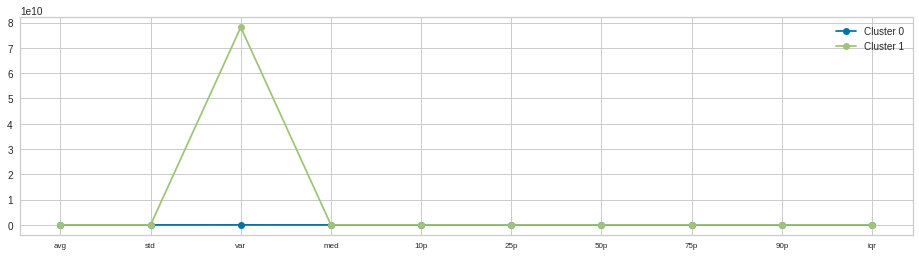

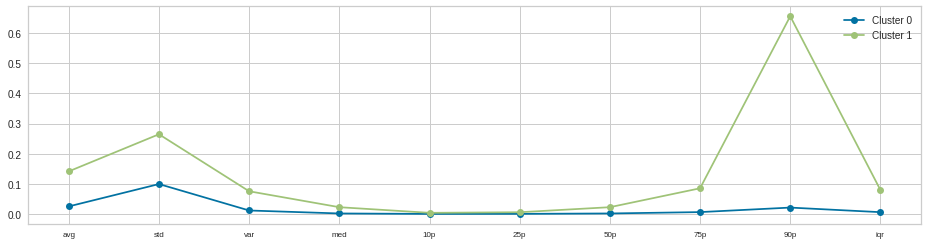

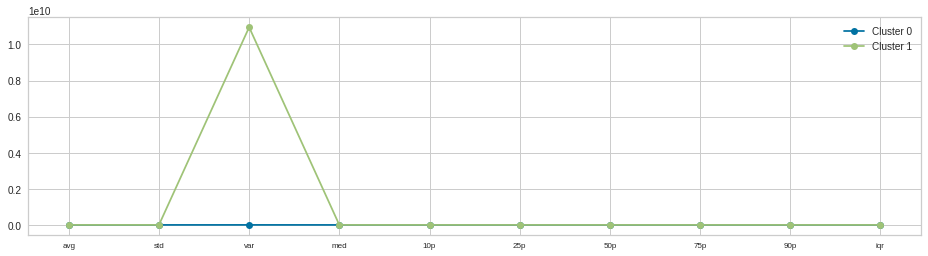

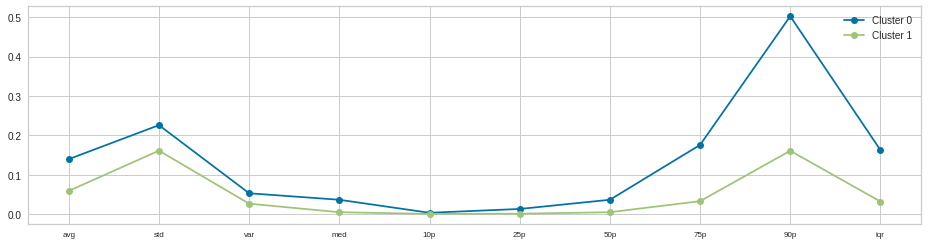

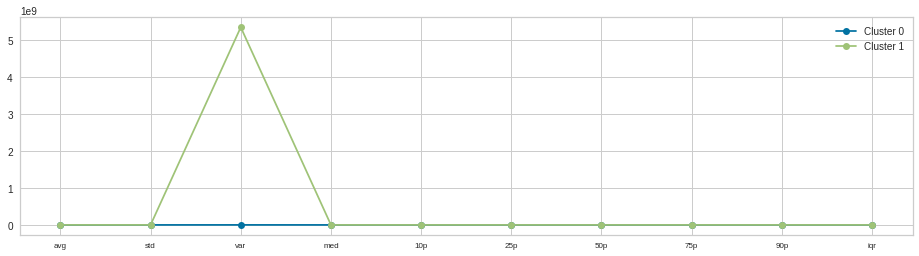

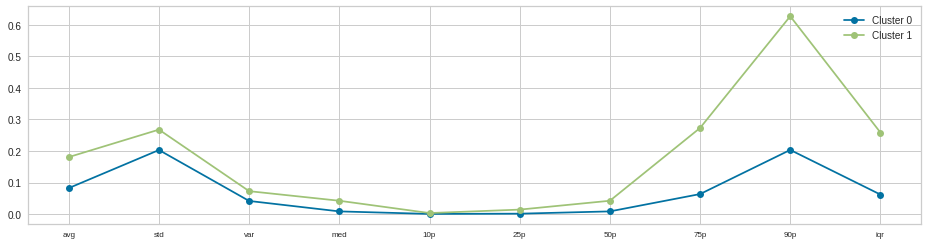

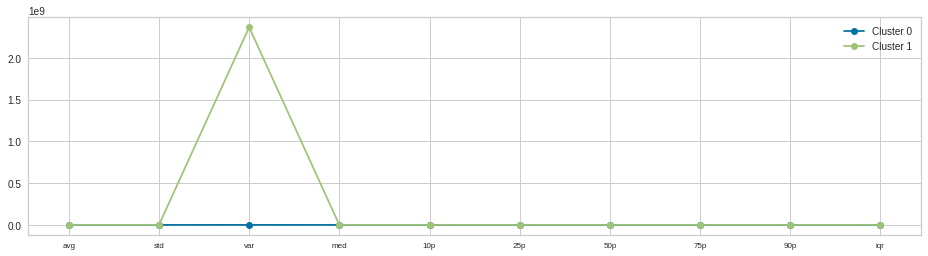

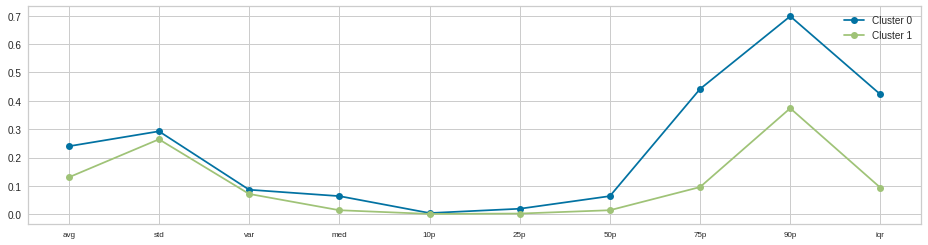

In [ ]:
for ii in range(len(kmeans)):
  plt.figure(figsize=(16, 4))
  for i in range(0, len(kmeans[ii].cluster_centers_)):
      plt.plot(kmeans[ii].cluster_centers_[i], marker='o', label='Cluster %s' % i)
  plt.tick_params(axis='both', which='major', labelsize=10)
  plt.xticks(range(0, len(features[:-2])), features[:-2], fontsize=8)
  plt.legend(fontsize=10)
  plt.show()

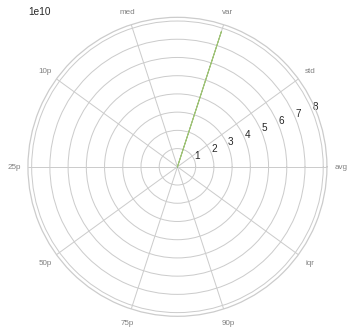

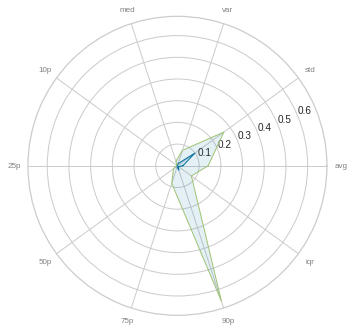

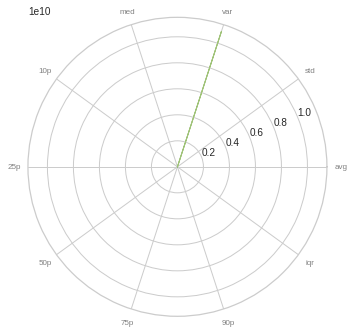

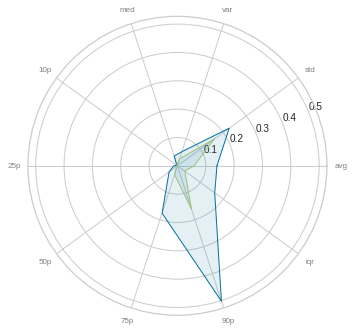

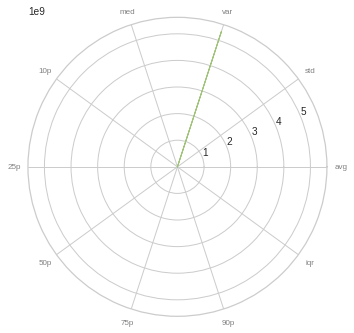

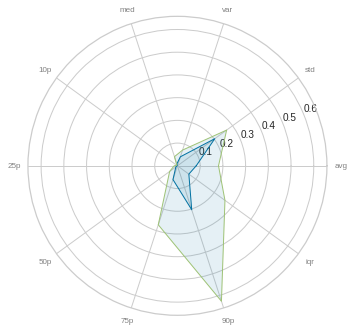

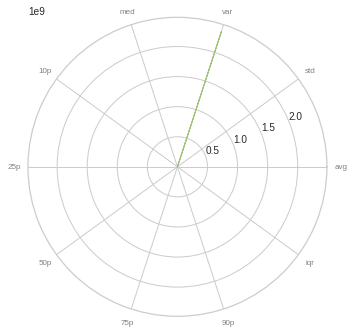

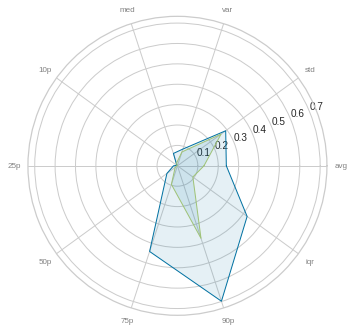

In [ ]:
for ii in range(len(kmeans)):
  # number of variable
  N = 10
  # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
  for i in range(0, len(kmeans[ii].cluster_centers_)):
      angles = [n / float(N) * 2 * pi for n in range(N)]
      values = kmeans[ii].cluster_centers_[i].tolist()
      values += values[:1]
      angles += angles[:1]
  # Initialise the spider plot
      ax = plt.subplot(polar=True)
  # Draw one axe per variable + add labels labels yet
      plt.xticks(angles[:-1], features[:-2], color='grey', size=8) 
  # Plot data
      ax.plot(angles, values, linewidth=1, linestyle='solid')
  # Fill area
      ax.fill(angles, values, 'b', alpha=0.1)
  plt.show()

### Clusters characterization

In [ ]:
users_profile_all = pd.read_csv('/content/drive/Shareddrives/DataMining/dataset/users_profile.csv', lineterminator='\n')

In [ ]:
users_profile_all = users_profile_all.merge(ts_users, on='user_id')

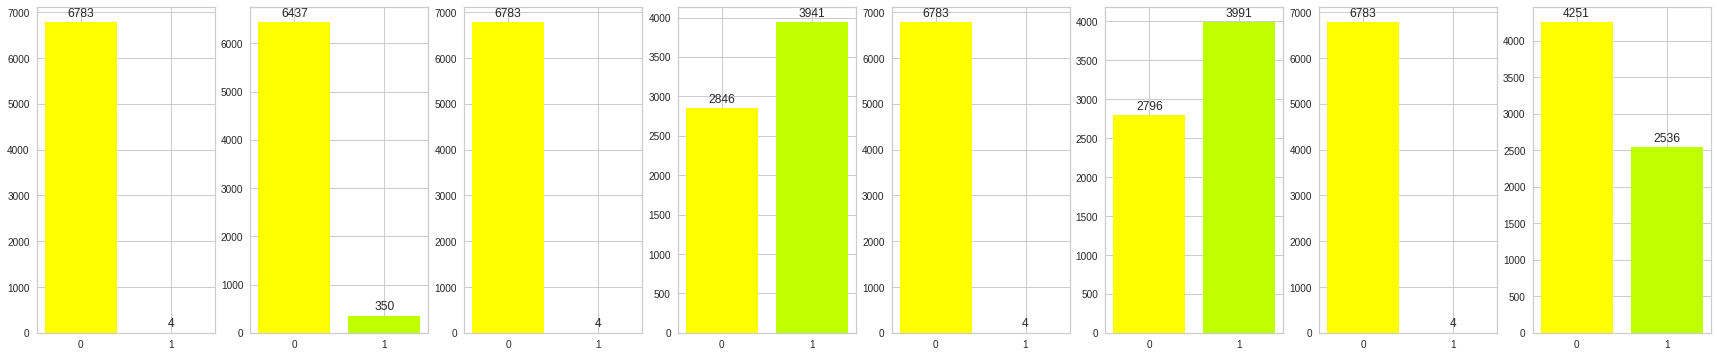

In [ ]:
fig, ax = plt.subplots(ncols=len(kmeans), figsize=(30,6))
for i in range(len(kmeans)):
  hist, bins = np.histogram(kmeans[i].labels_, bins=range(0, len(set(kmeans[i].labels_)) + 1))
  #plt.stairs(hist, bins)
  clusters = ax[i].bar(range(len(dict(zip(bins, hist)))), list(dict(zip(bins, hist)).values()), align='center', color=['#ffff00', '#bfff00', '#00ff40', '#00ff80', '#00ffbf', '#00ffff', '#00bfff', '#0080ff', '#0040ff', '#0000ff', '#4000ff', '#8000ff', '#bf00ff', '#ff00ff', '#ff00bf', '#ff0080', '#ff0040', '#ff0000', '#756bb1'])
  ax[i].set_xticks(range(len(dict(zip(bins, hist)))), list(dict(zip(bins, hist)).keys()))
  ax[i].bar_label(clusters, padding=3)
plt.show()

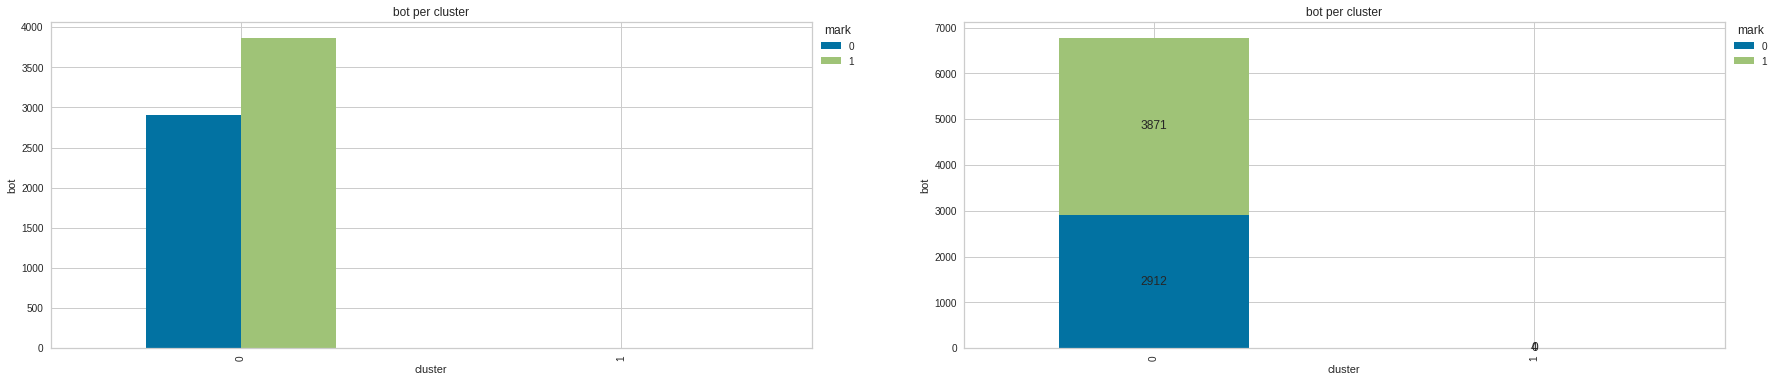

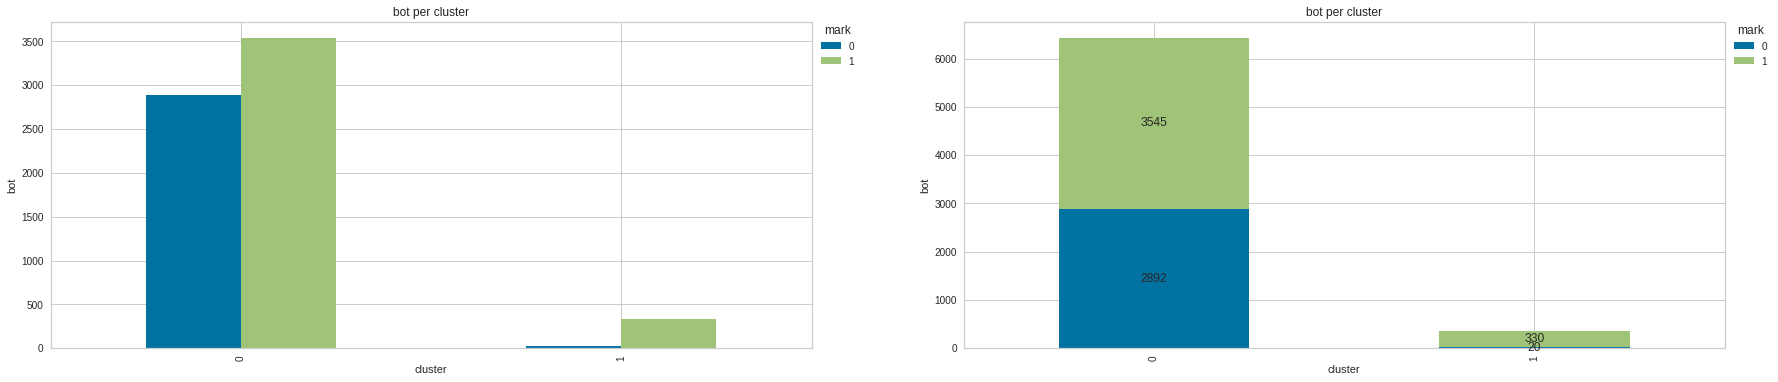

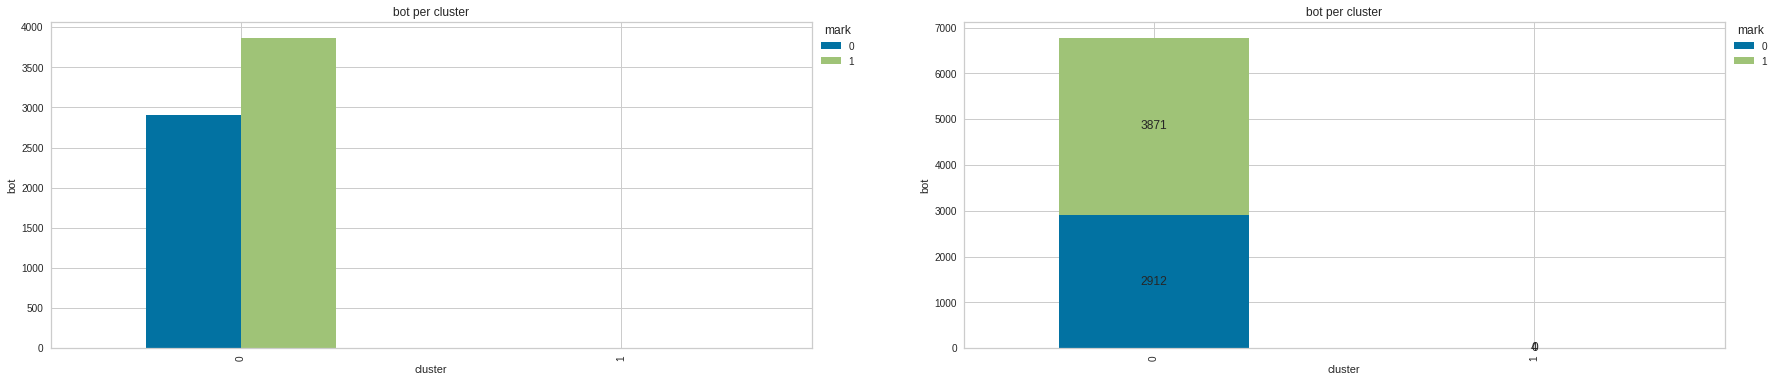

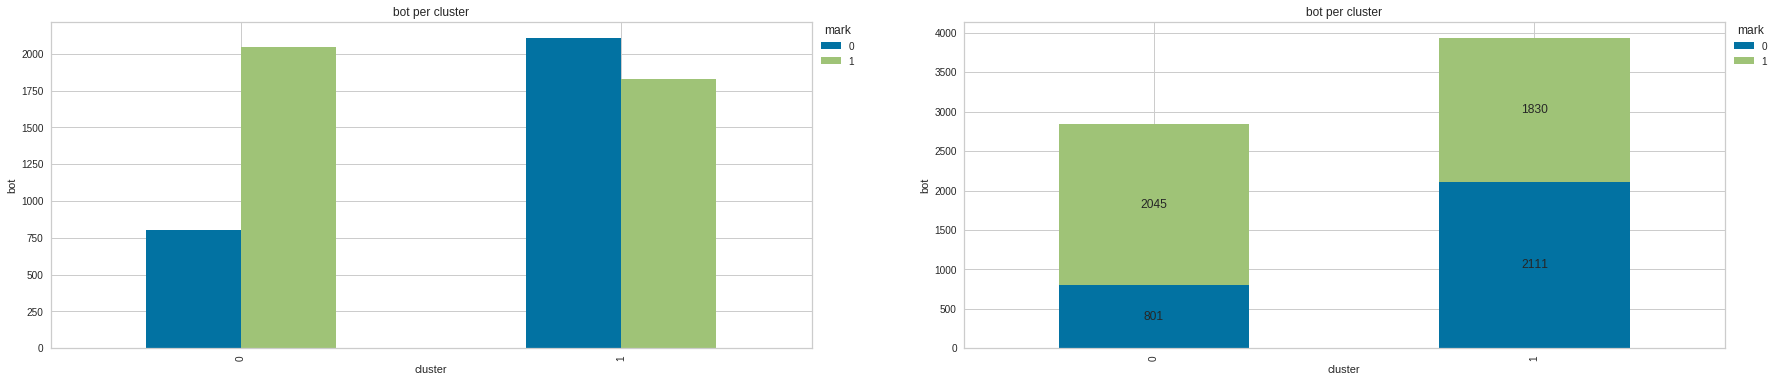

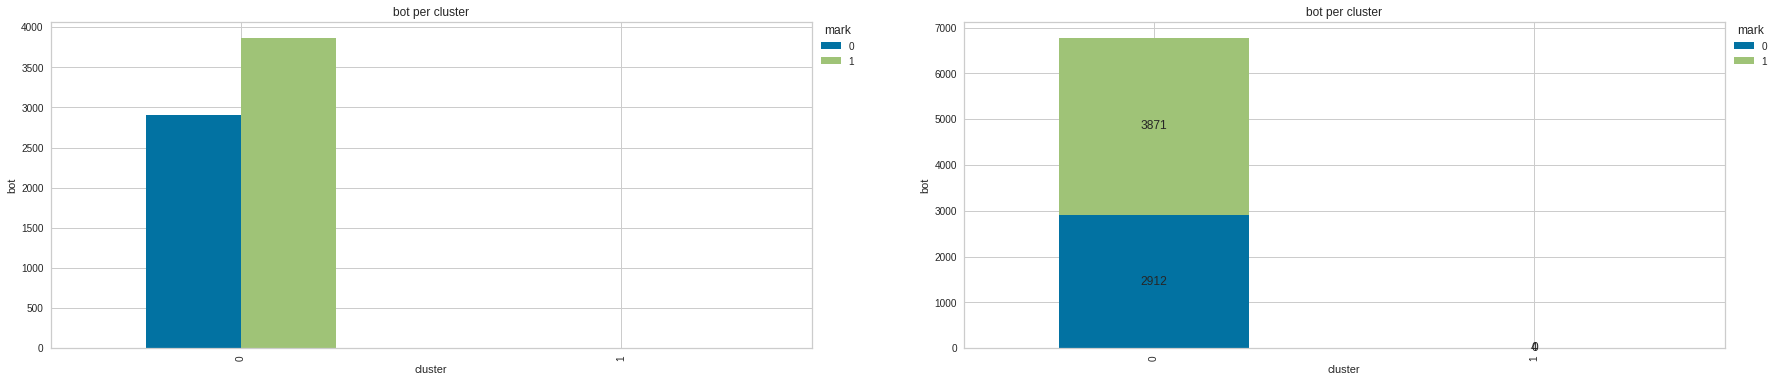

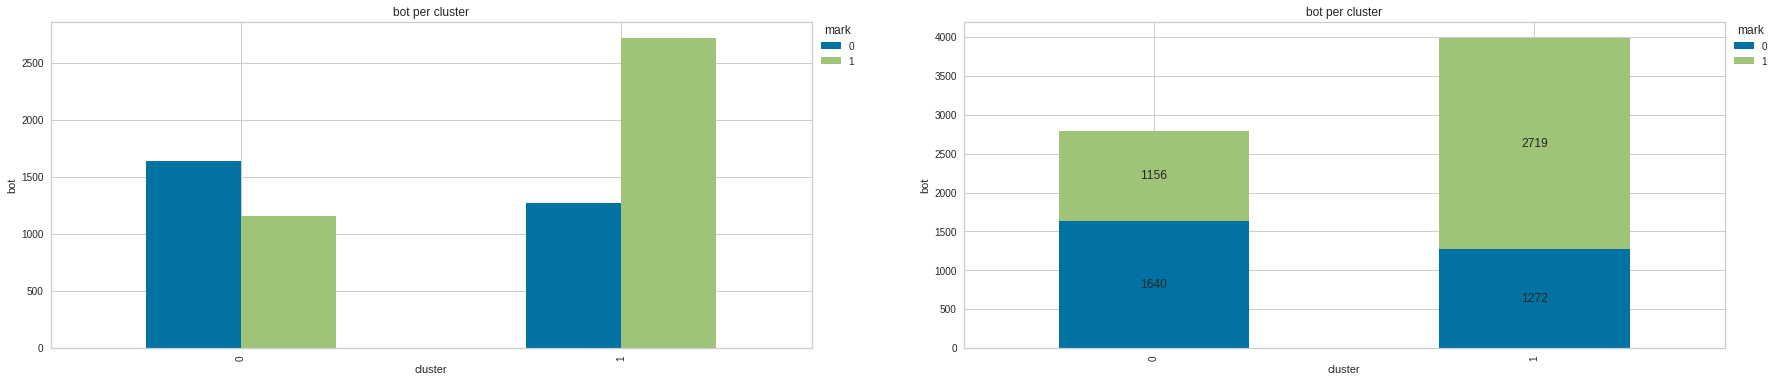

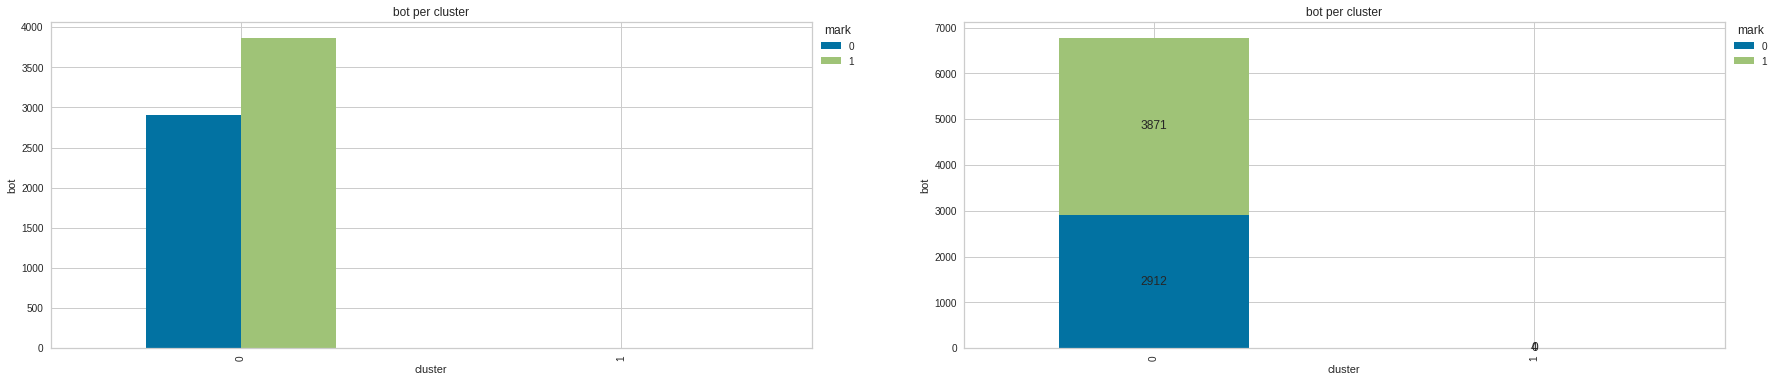

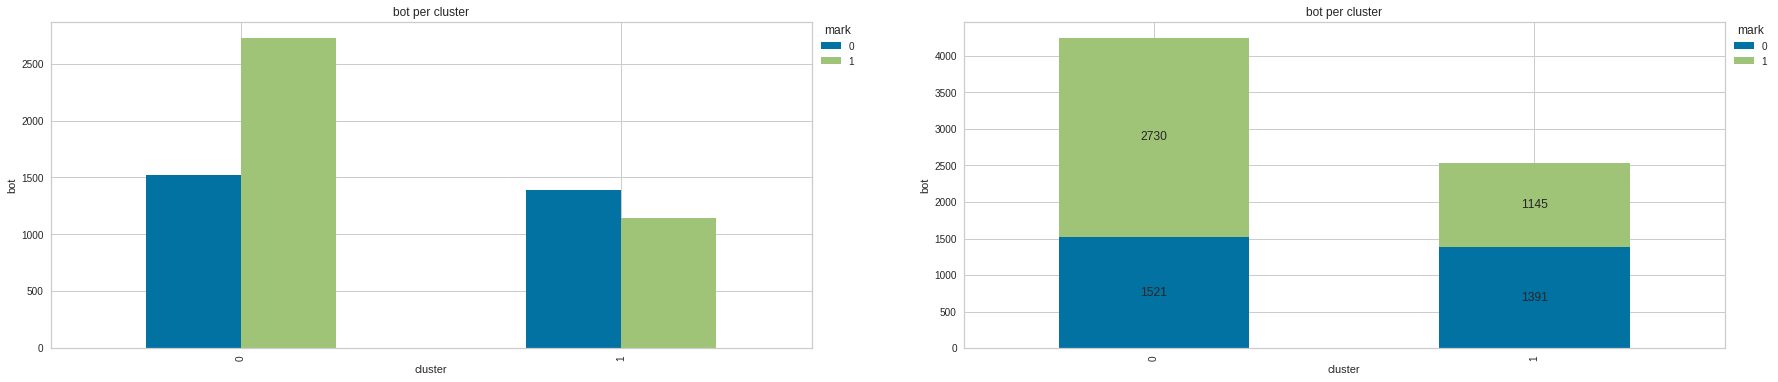

In [ ]:
for i in range(len(kmeans)):
  bot_ct = pd.crosstab(kmeans[i].labels_,ts_users['bot'])

  f, axs = plt.subplots(ncols=2, figsize=(30,6))

  ax1 = bot_ct.plot(kind='bar', stacked=False, title='bot per cluster', ax=axs[0])
  ax1.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  axs[0].set_xlabel('cluster')
  axs[0].set_ylabel('bot')

  ax2 = bot_ct.plot(kind='bar', stacked=True, title='bot per cluster', ax=axs[1])
  ax2.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  # add counts
  for c in ax2.containers:
      # set the bar label
      ax2.bar_label(c, label_type='center')
  axs[1].set_xlabel('cluster')
  axs[1].set_ylabel('bot')

  plt.show()

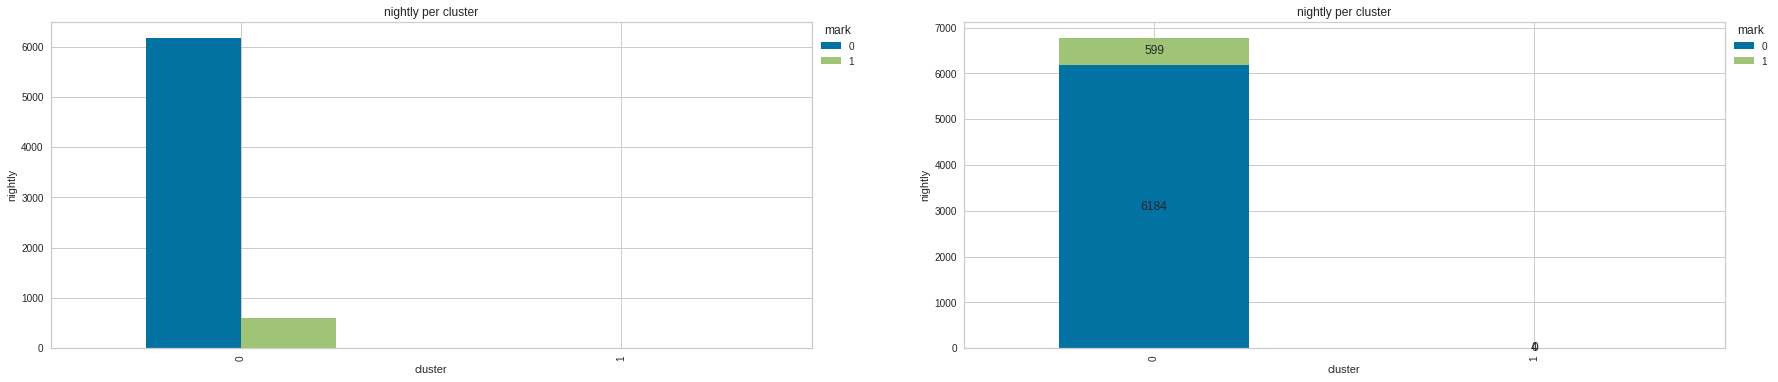

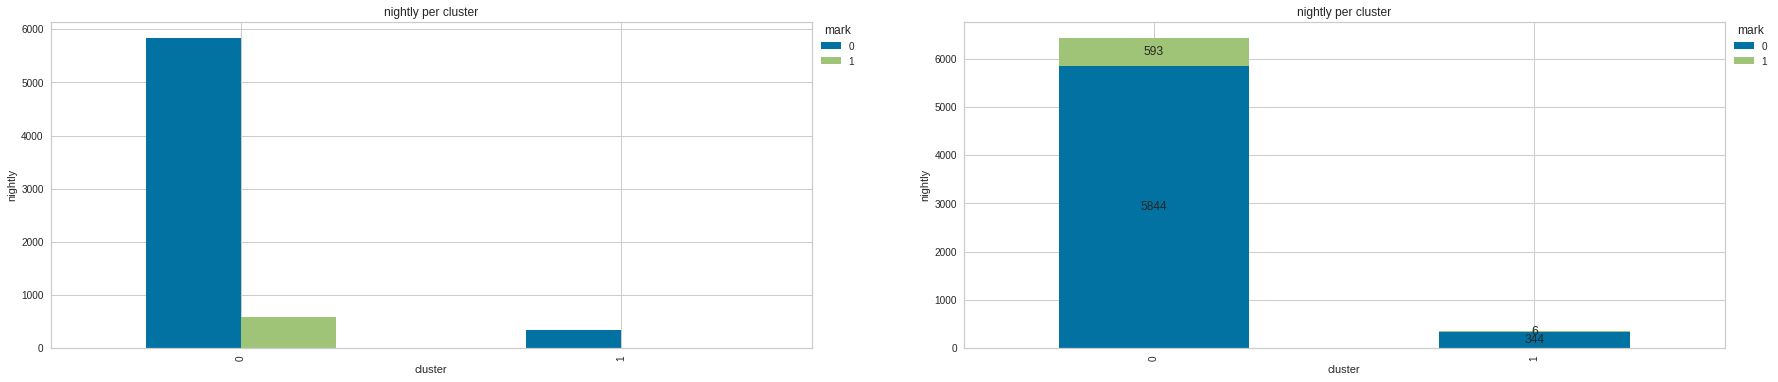

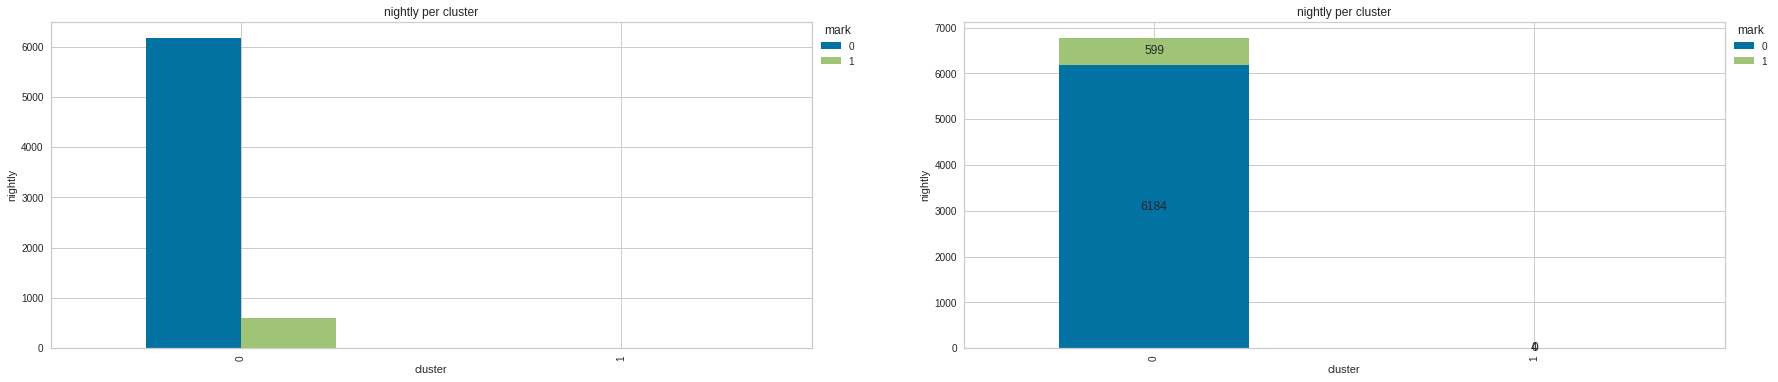

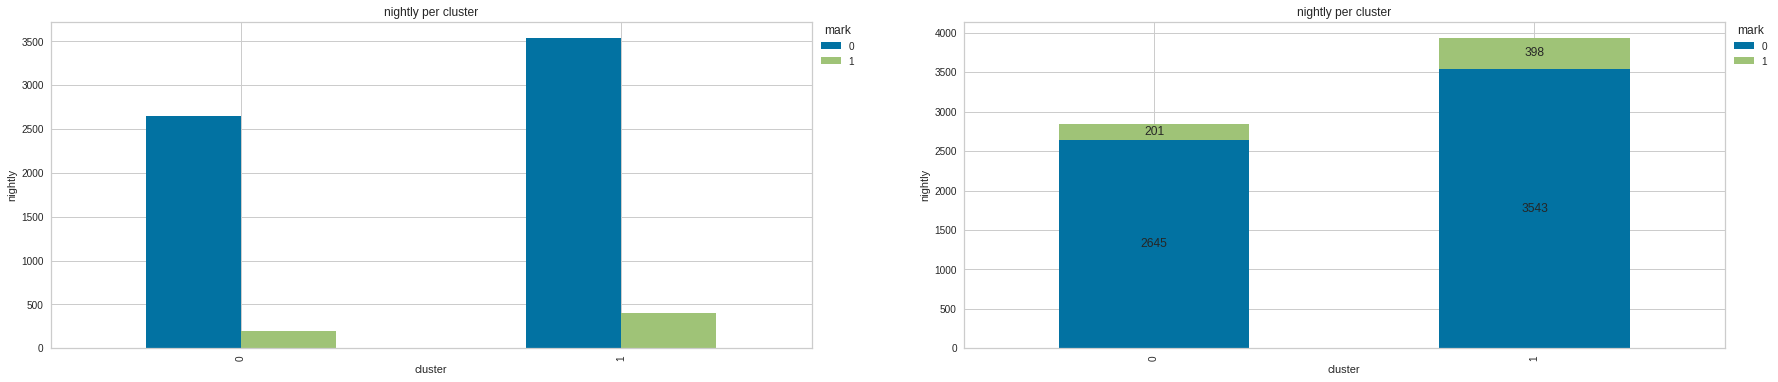

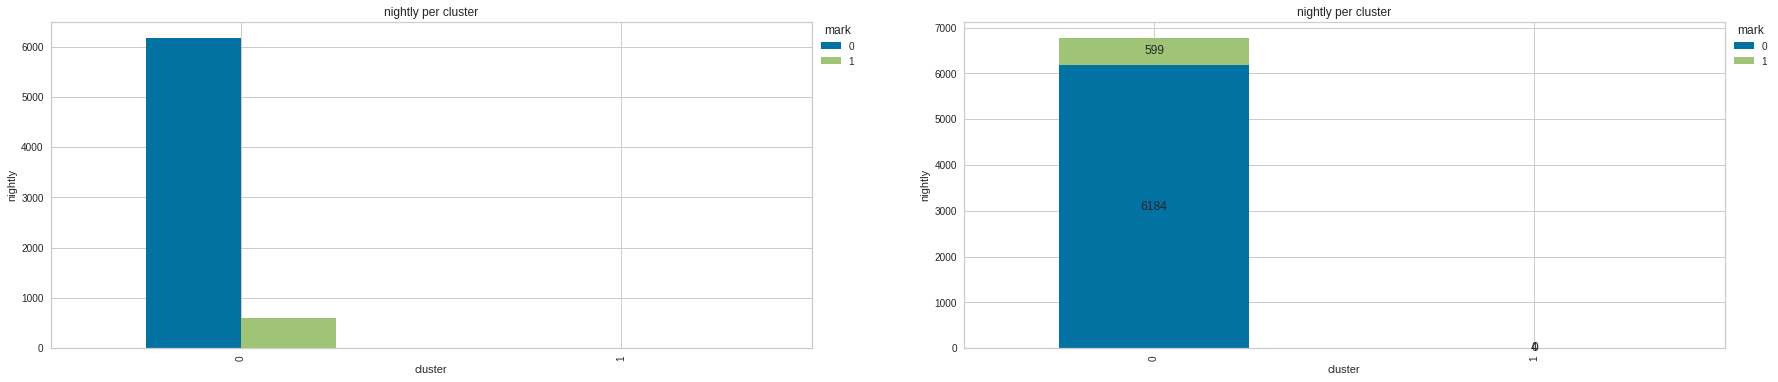

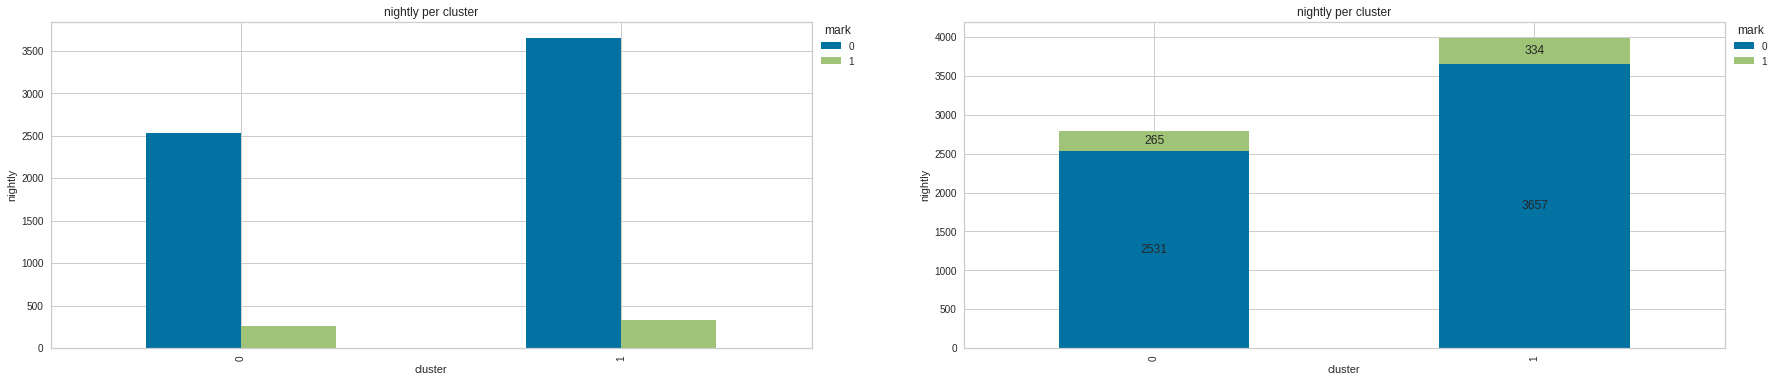

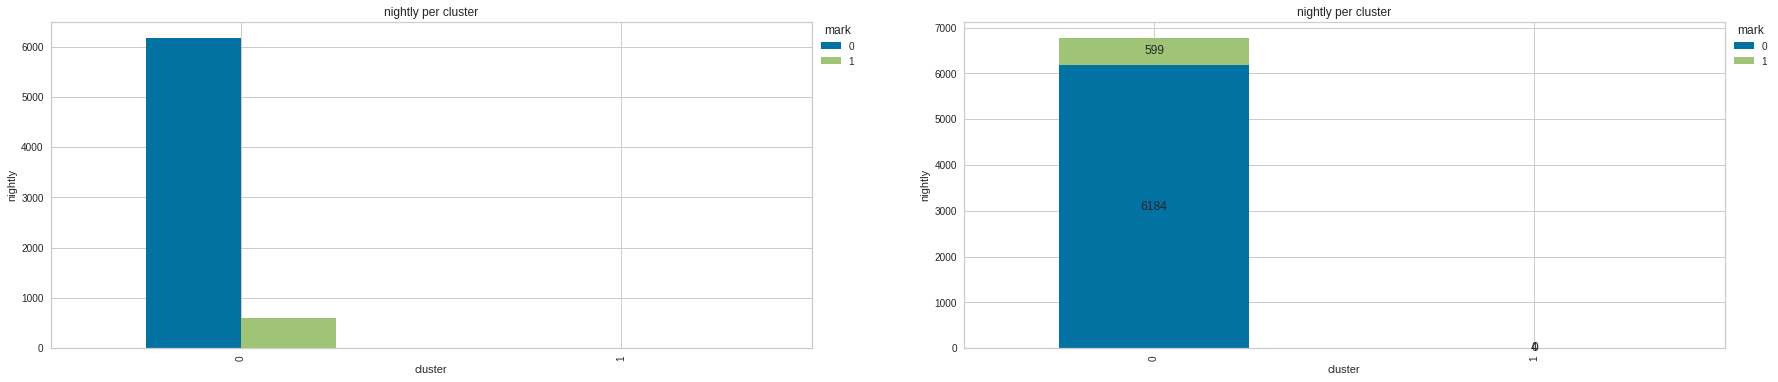

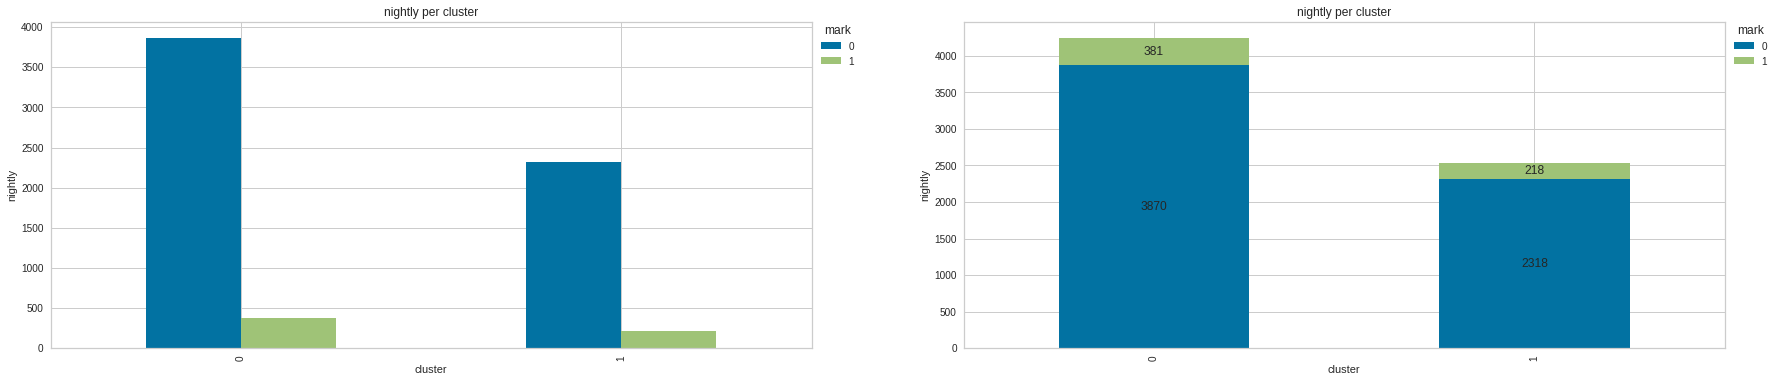

In [ ]:
for i in range(len(kmeans)):
  nightly_ct = pd.crosstab(kmeans[i].labels_,users_profile_all['nightly'])

  f, axs = plt.subplots(ncols=2, figsize=(30,6))

  ax1 = nightly_ct.plot(kind='bar', stacked=False, title='nightly per cluster', ax=axs[0])
  ax1.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  axs[0].set_xlabel('cluster')
  axs[0].set_ylabel('nightly')

  ax2 = nightly_ct.plot(kind='bar', stacked=True, title='nightly per cluster', ax=axs[1])
  ax2.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  # add counts
  for c in ax2.containers:
      # set the bar label
      ax2.bar_label(c, label_type='center')
  axs[1].set_xlabel('cluster')
  axs[1].set_ylabel('nightly')

  plt.show()

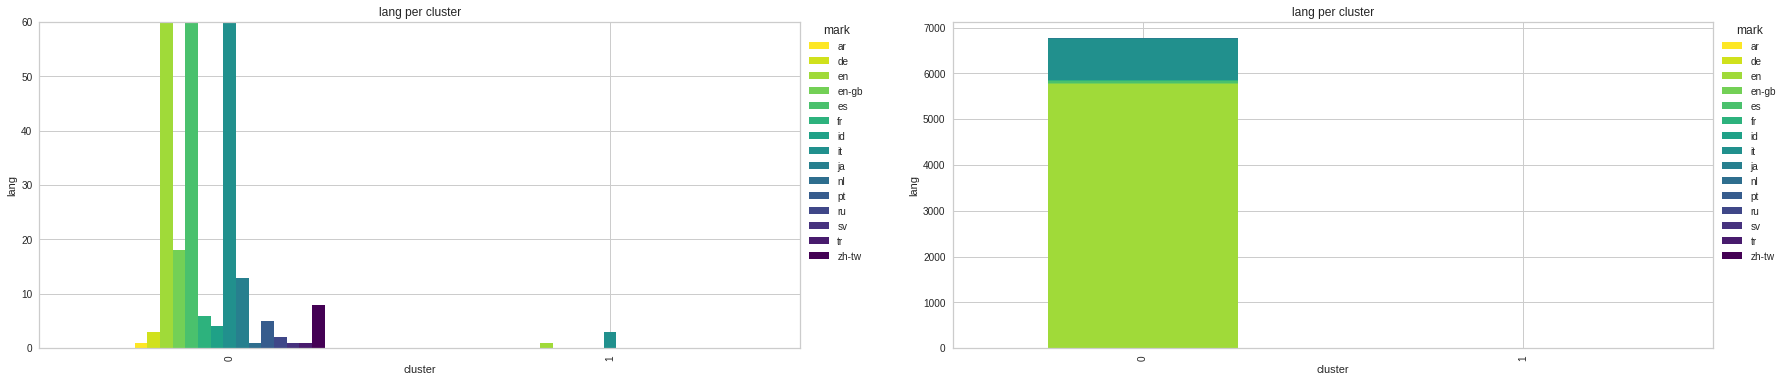

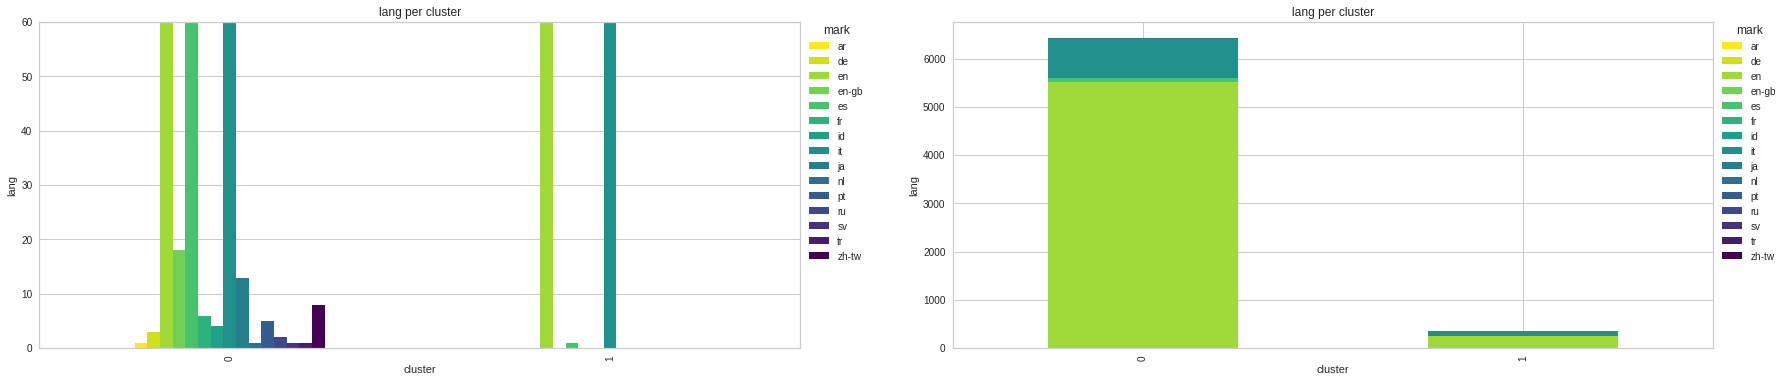

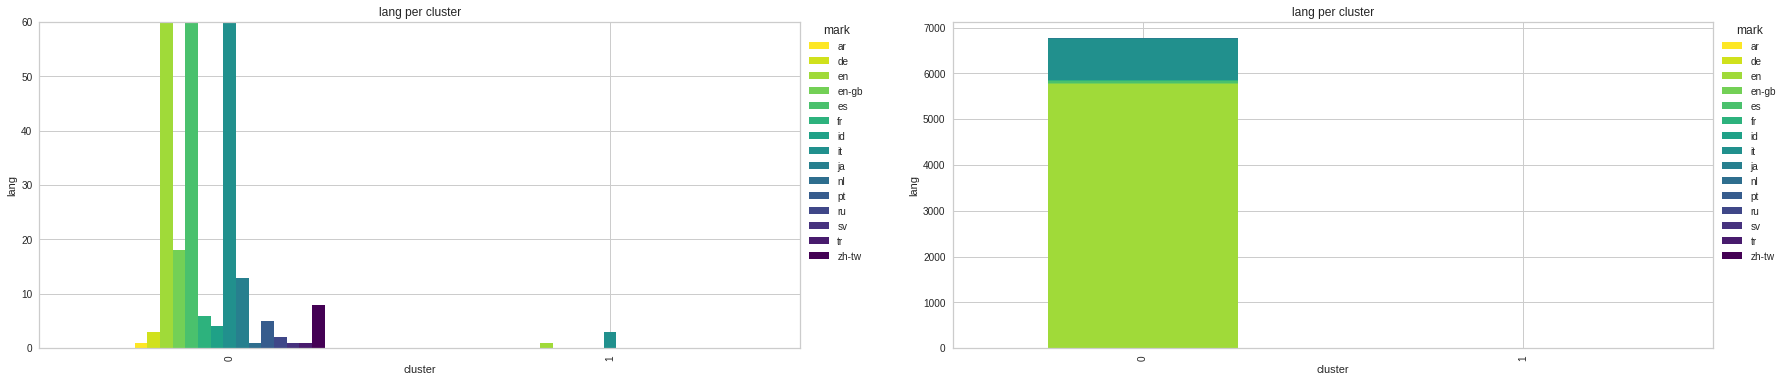

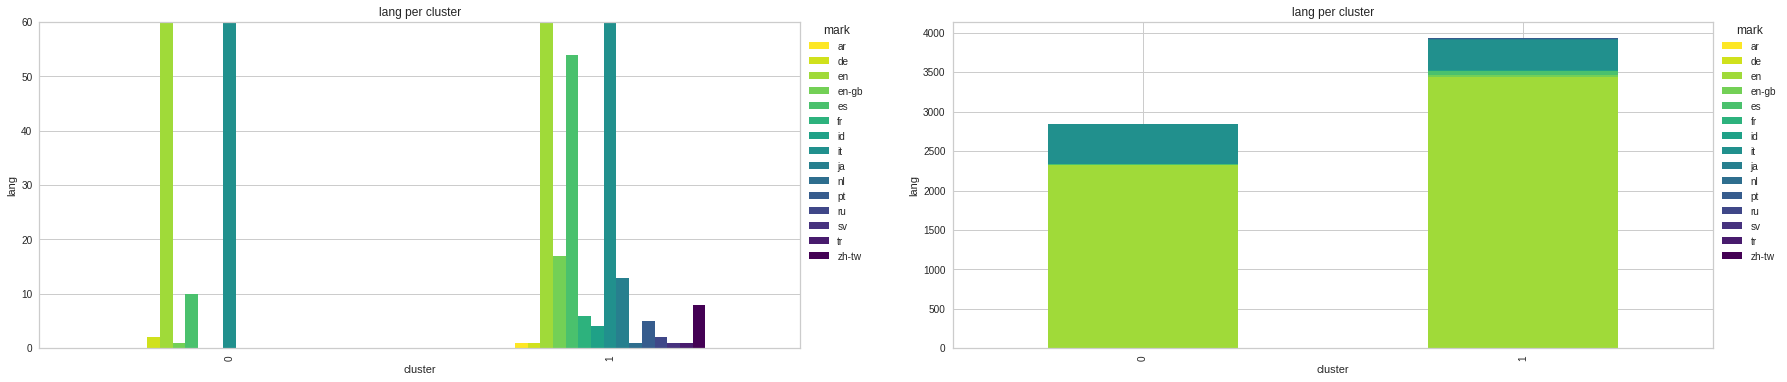

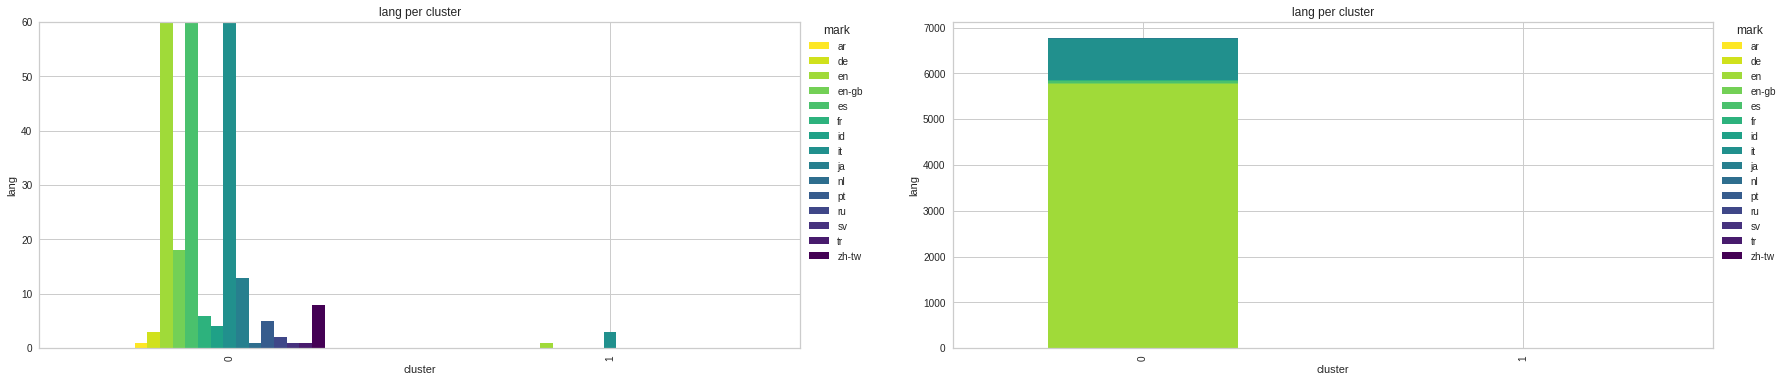

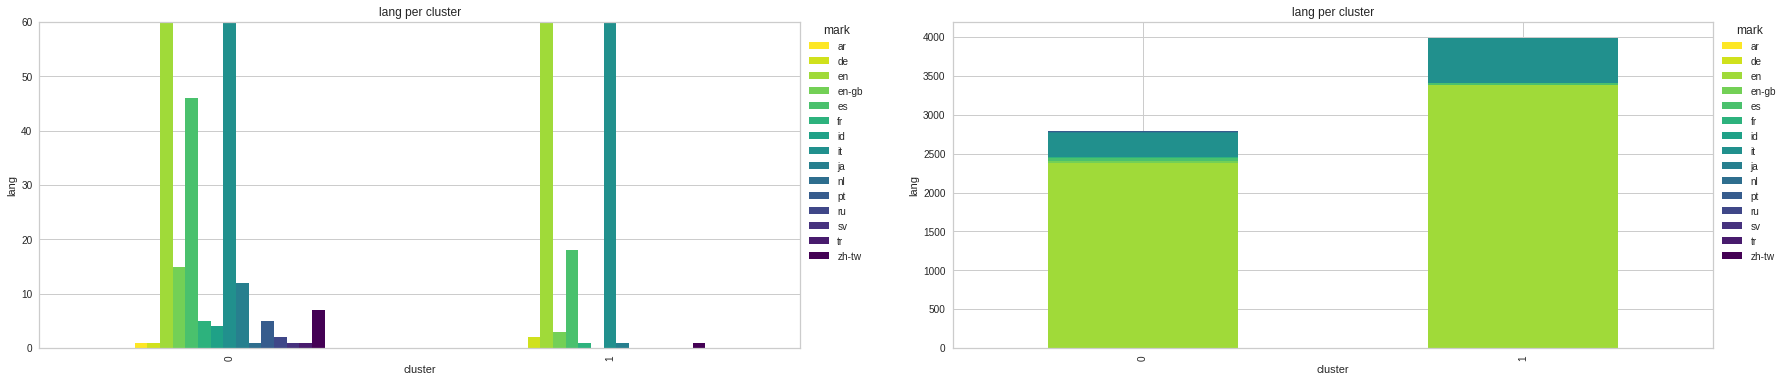

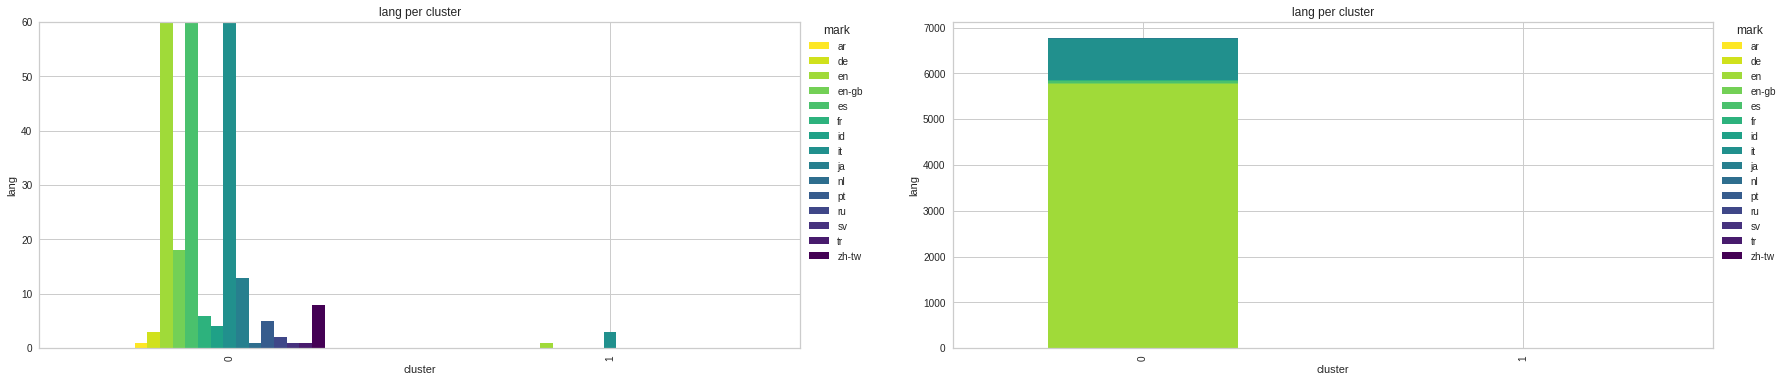

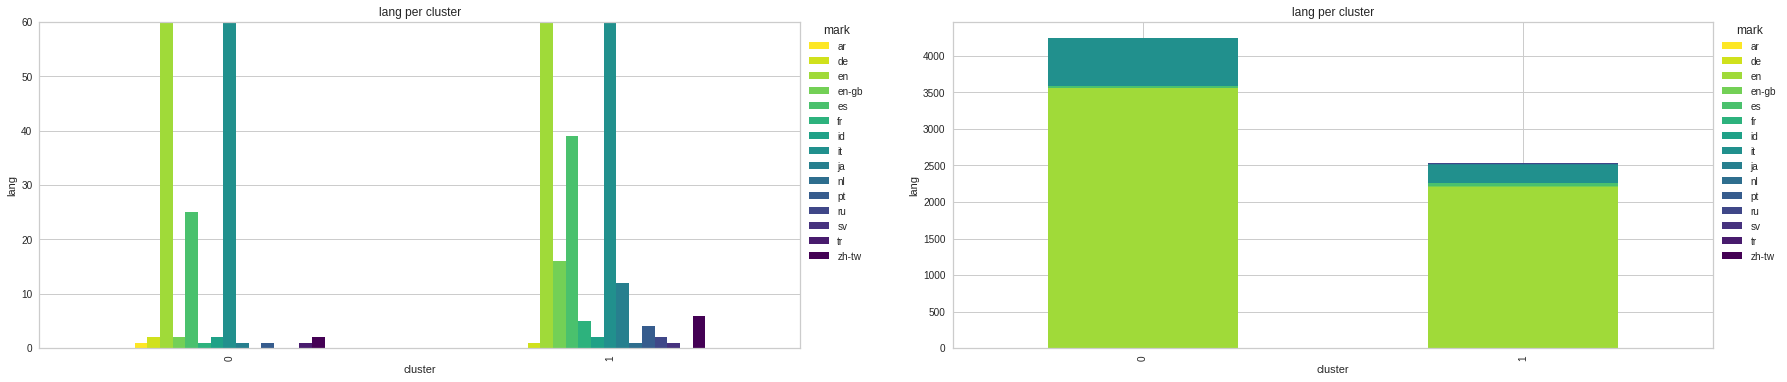

In [ ]:
for i in range(len(kmeans)):
  lang_ct = pd.crosstab(kmeans[i].labels_,users_profile_all['lang'])

  f, axs = plt.subplots(ncols=2, figsize=(30,6))

  ax1 = lang_ct.plot(kind='bar', stacked=False, title='lang per cluster', ax=axs[0], colormap="viridis_r")
  ax1.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  axs[0].set_xlabel('cluster')
  axs[0].set_ylabel('lang')
  axs[0].set_ylim(0, 60) 

  ax2 = lang_ct.plot(kind='bar', stacked=True, title='lang per cluster', ax=axs[1], colormap="viridis_r")
  ax2.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  axs[1].set_xlabel('cluster')
  axs[1].set_ylabel('lang')

  plt.show()

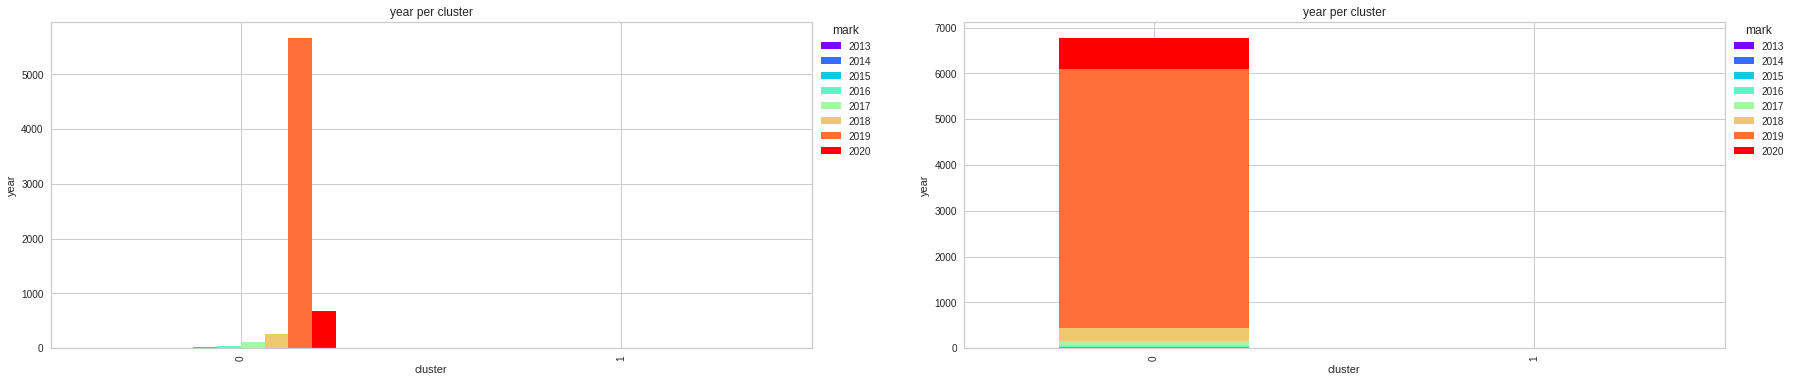

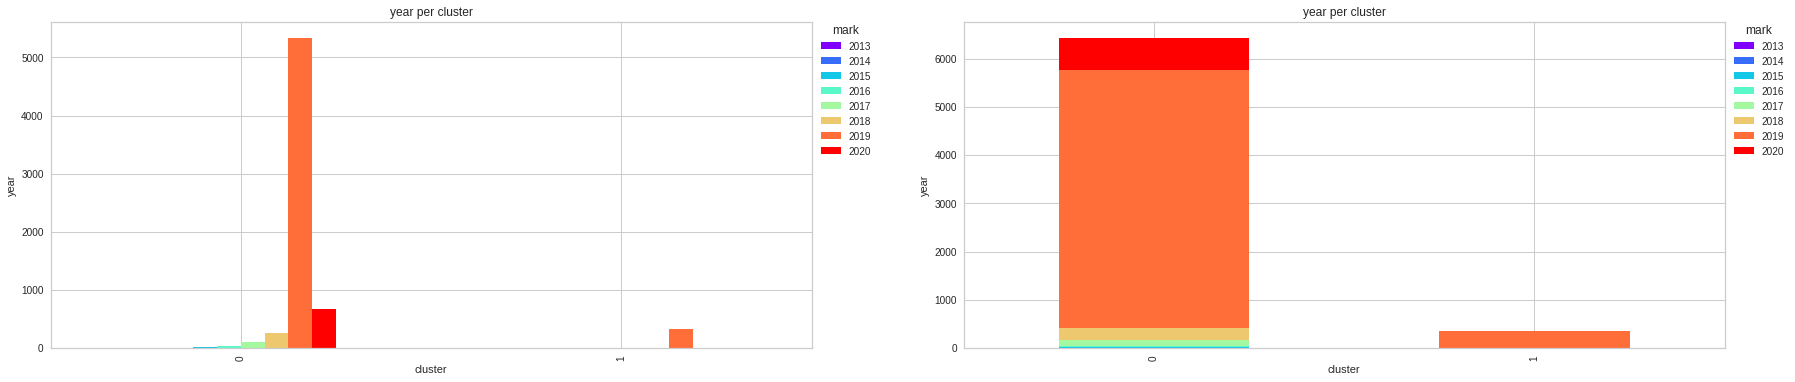

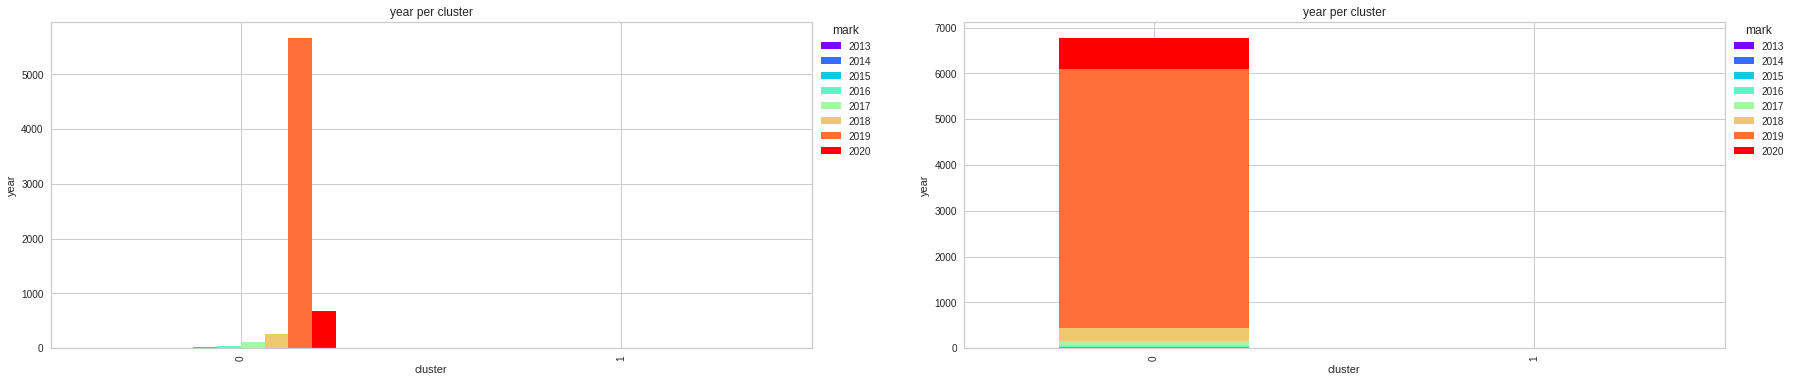

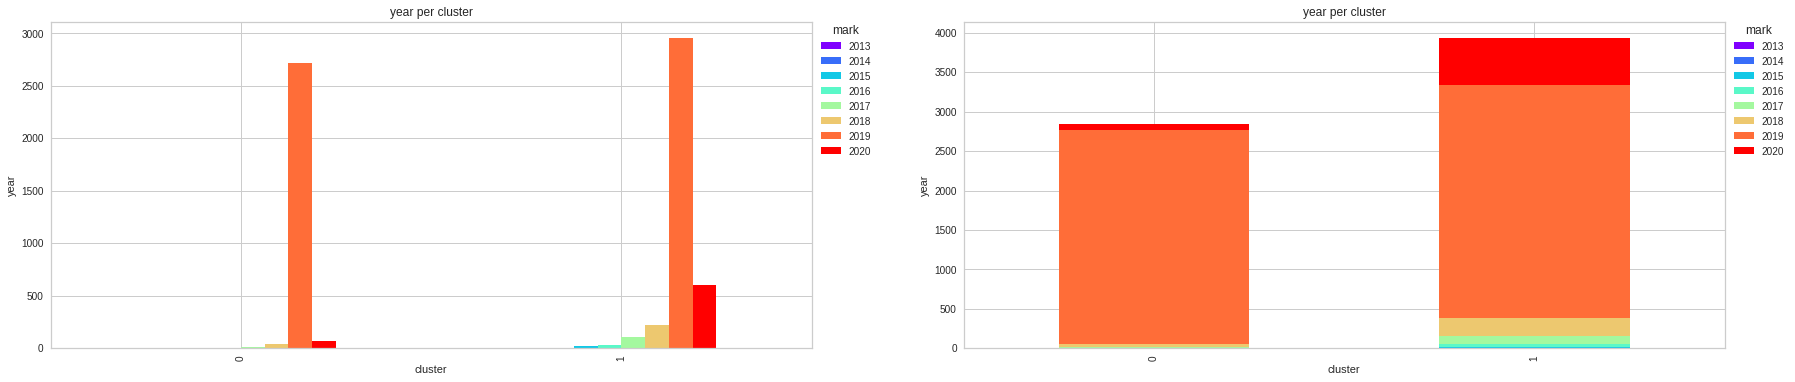

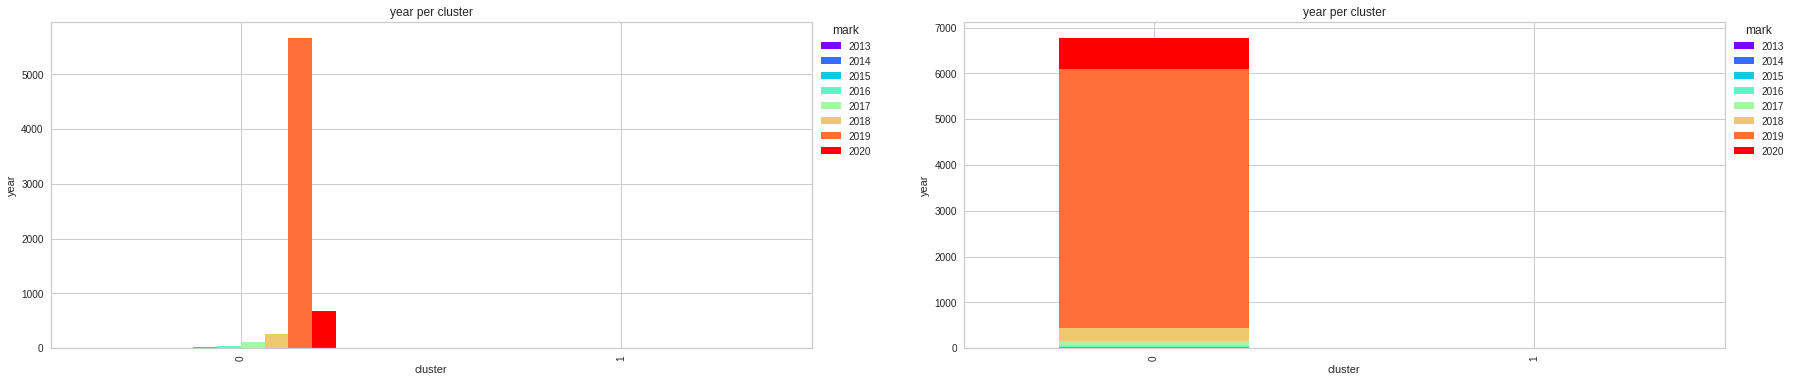

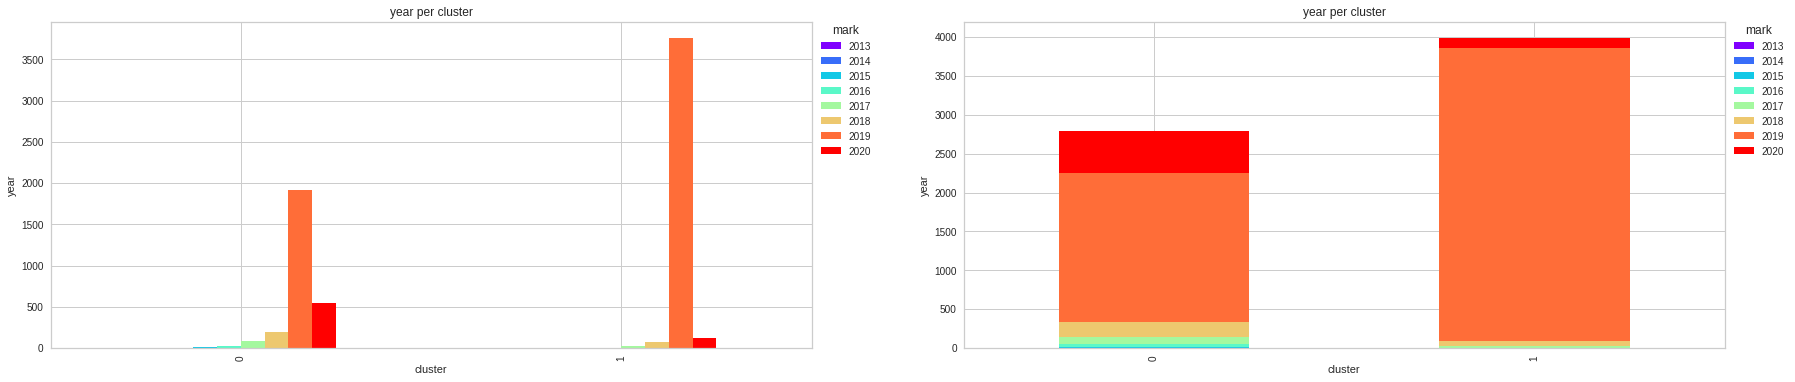

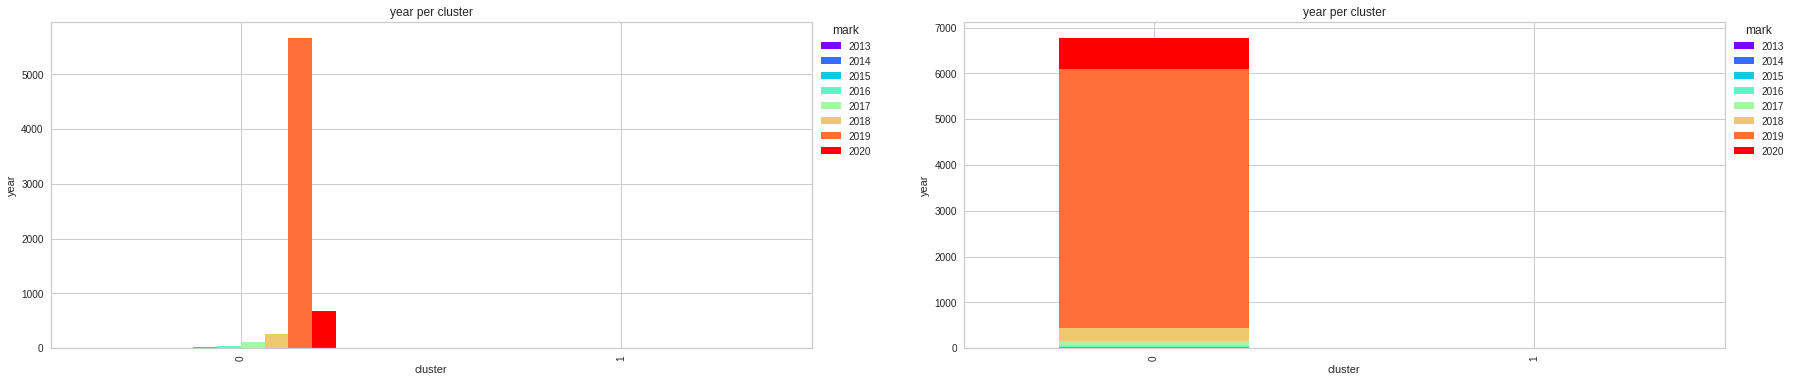

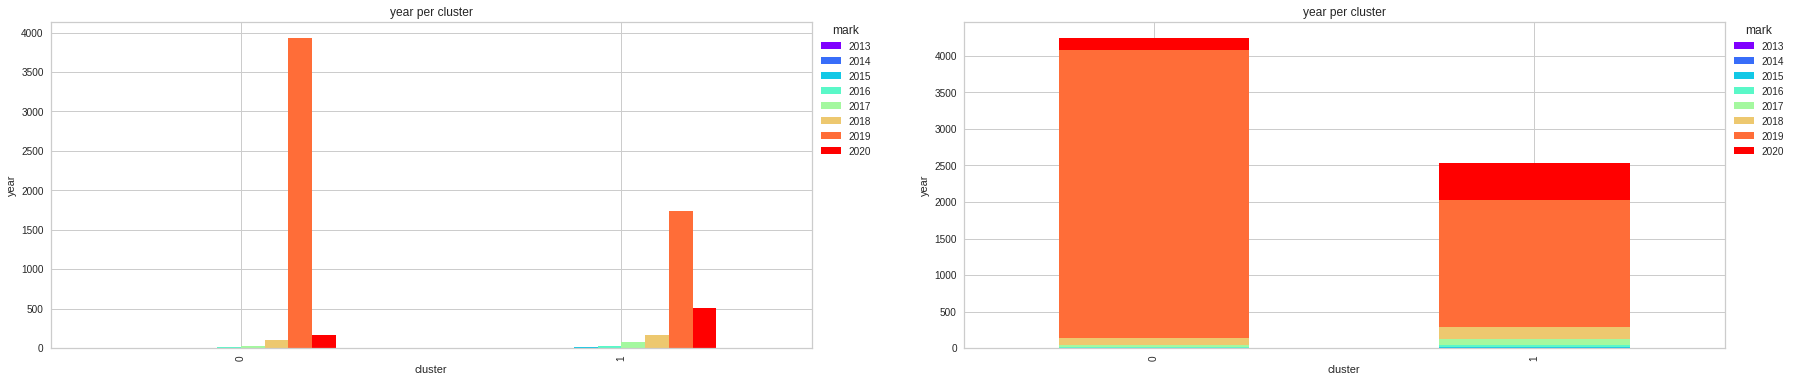

In [ ]:
for i in range(len(kmeans)):
  year_ct = pd.crosstab(kmeans[i].labels_,users_profile_all['most_freq_year'])

  f, axs = plt.subplots(ncols=2, figsize=(30,6))

  ax1 = year_ct.plot(kind='bar', stacked=False, title='year per cluster', ax=axs[0], colormap="rainbow")
  ax1.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  axs[0].set_xlabel('cluster')
  axs[0].set_ylabel('year')

  ax2 = year_ct.plot(kind='bar', stacked=True, title='year per cluster', ax=axs[1], colormap="rainbow")
  ax2.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  axs[1].set_xlabel('cluster')
  axs[1].set_ylabel('year')

  plt.show()

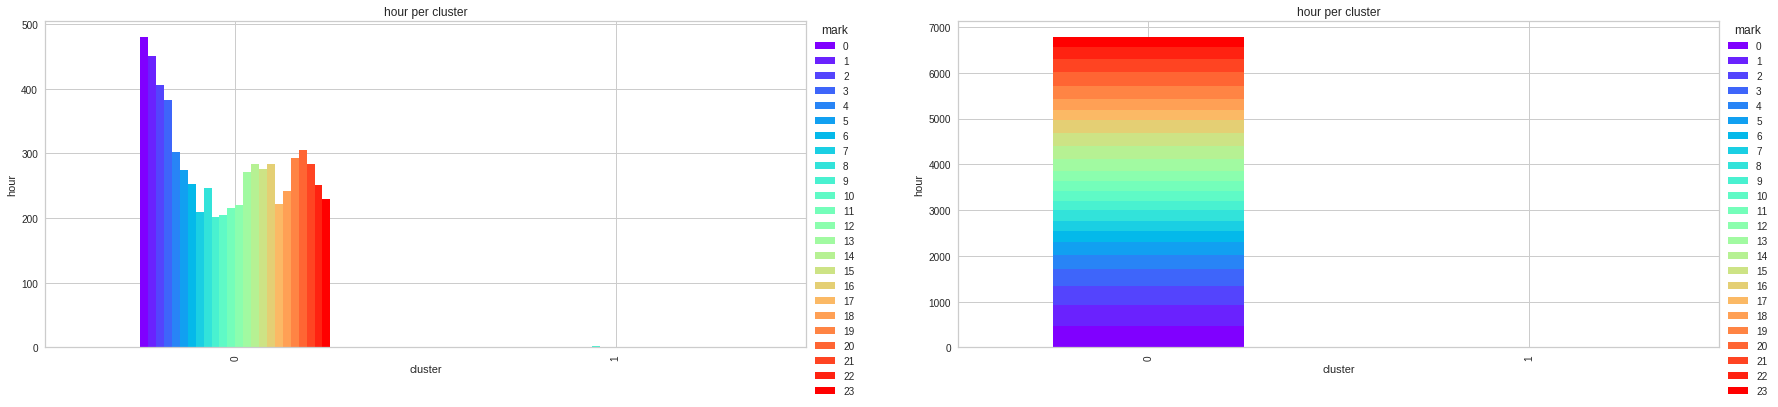

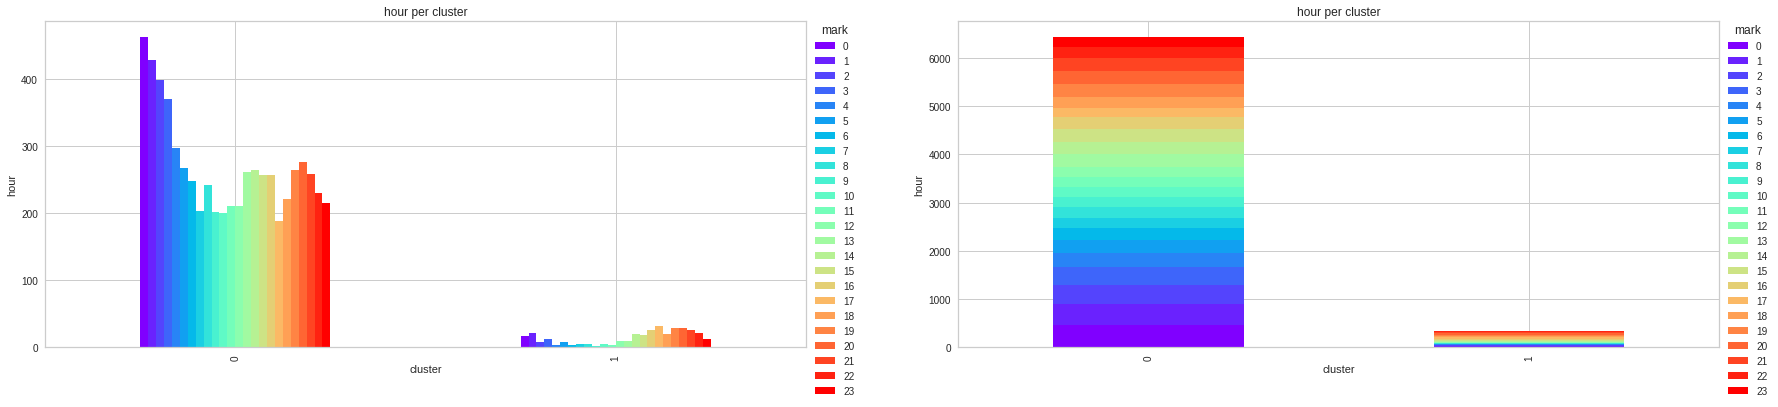

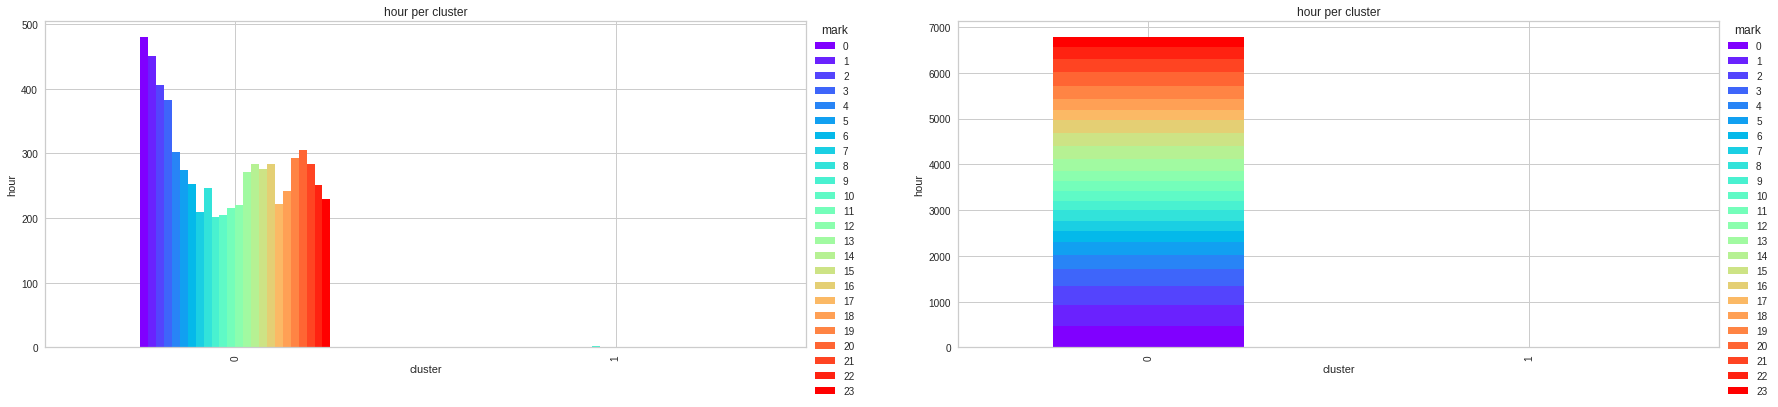

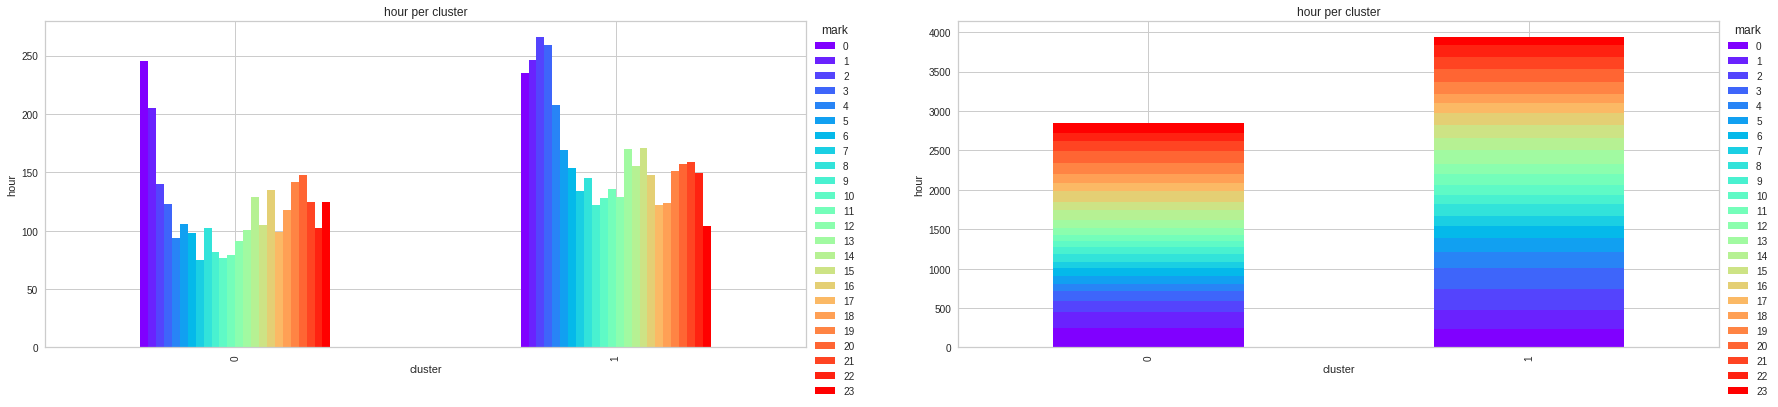

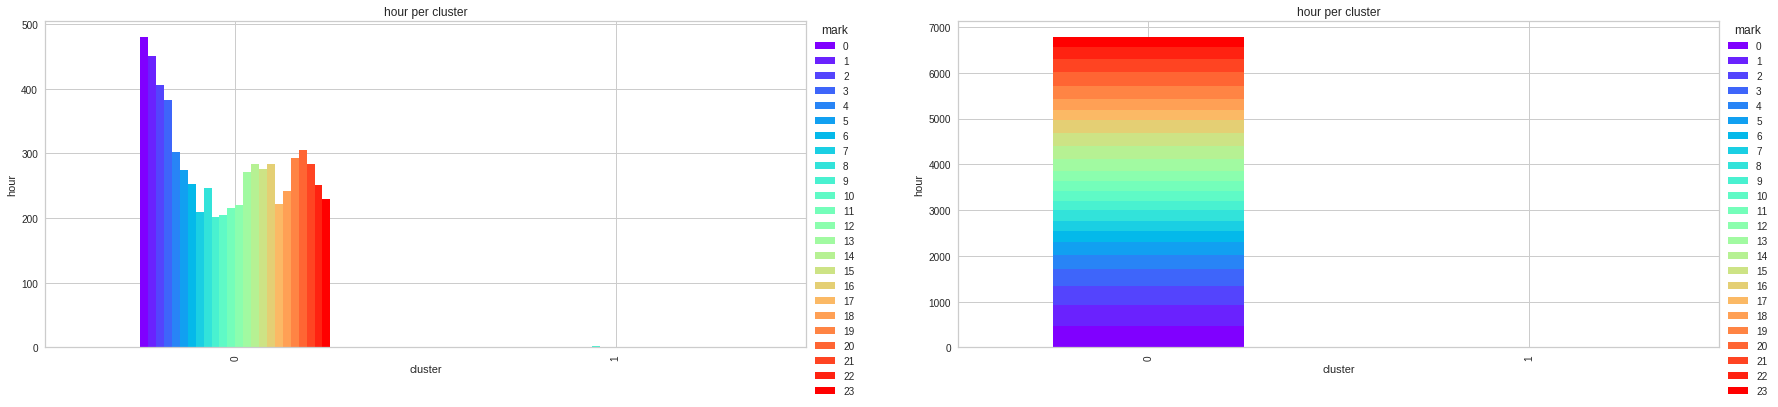

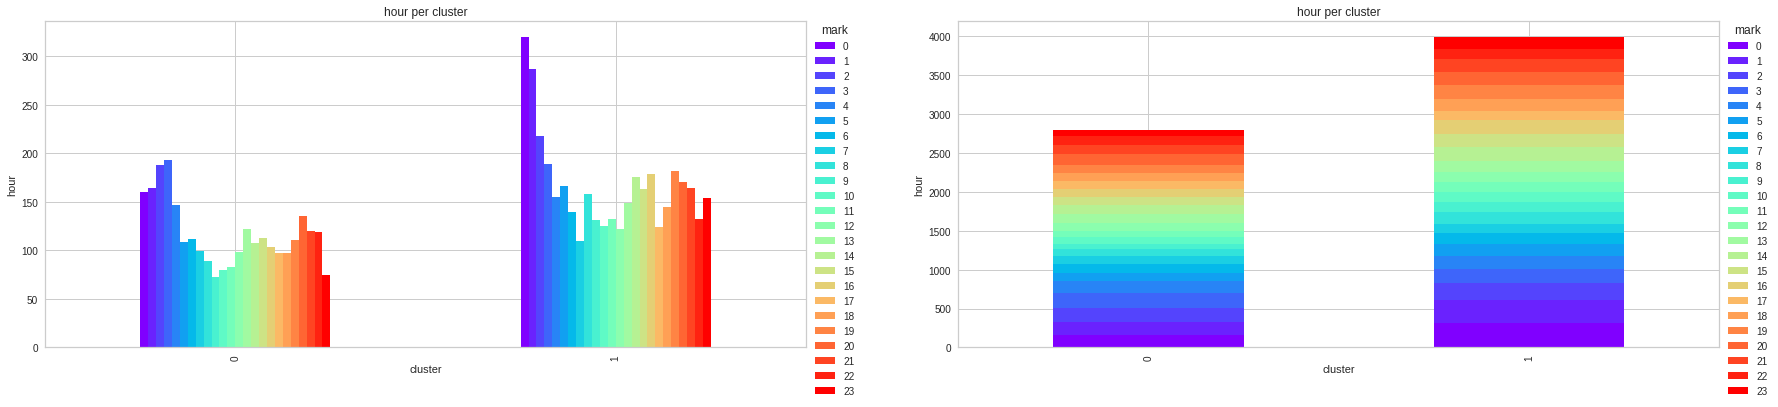

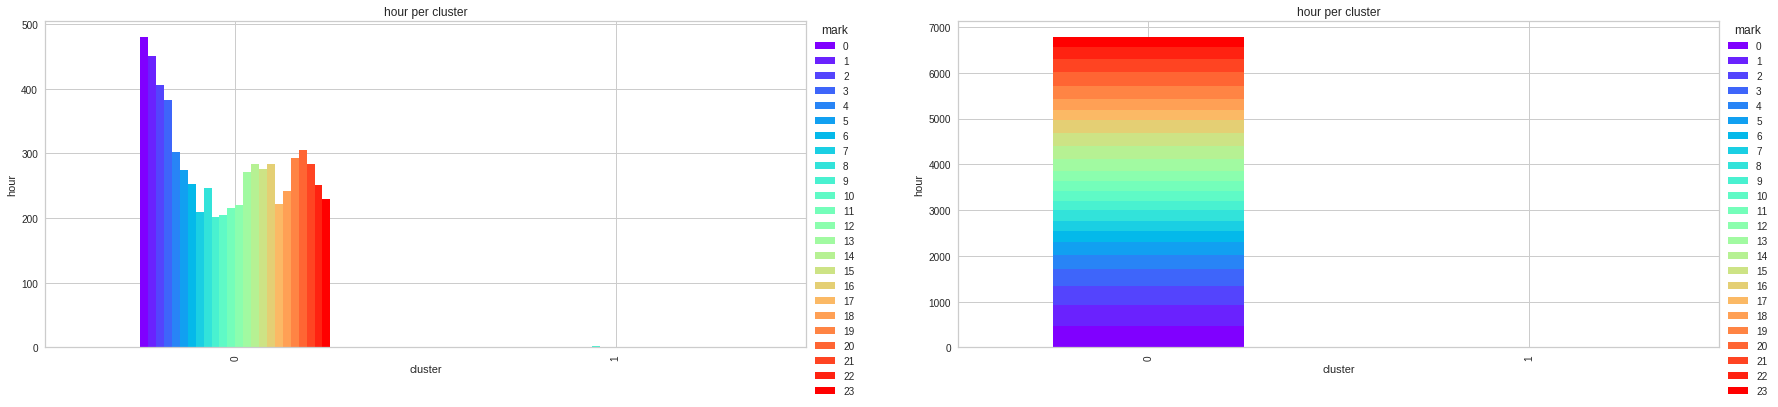

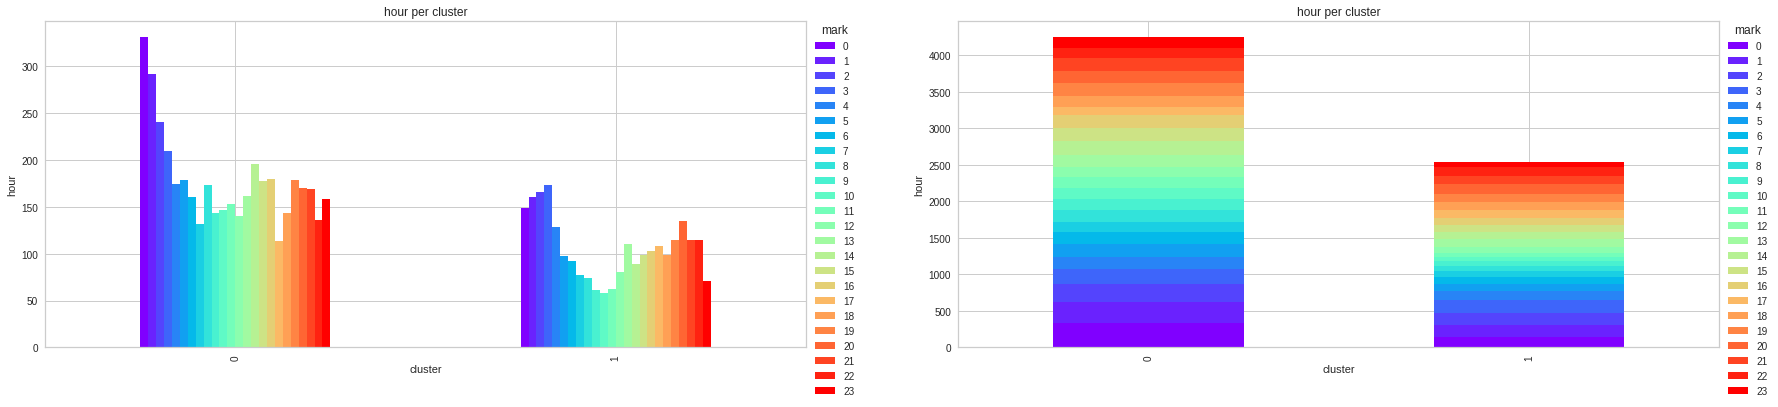

In [ ]:
for i in range(len(kmeans)):
  hour_ct = pd.crosstab(kmeans[i].labels_,users_profile_all['most_freq_hour'])

  f, axs = plt.subplots(ncols=2, figsize=(30,6))

  ax1 = hour_ct.plot(kind='bar', stacked=False, title='hour per cluster', ax=axs[0], colormap="rainbow")
  ax1.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  axs[0].set_xlabel('cluster')
  axs[0].set_ylabel('hour')

  ax2 = hour_ct.plot(kind='bar', stacked=True, title='hour per cluster', ax=axs[1], colormap="rainbow")
  ax2.legend(title='mark', bbox_to_anchor=(1, 1.02), loc='upper left')
  axs[1].set_xlabel('cluster')
  axs[1].set_ylabel('hour')

  plt.show()

In [ ]:
cols = []
for i in range(len(kmeans)):
  s = 'label_K=2 '+str(i+2)
  cols.append(s)

In [ ]:
for i in range(len(kmeans)):
  users_profile_all[cols[i]]=kmeans[i].labels_

In [ ]:
users_profile_all.head()

user_id                  name lang  bot_x      user_created_at  \
0   722623          Buzz Jackson   en      0  2012-01-31 00:54:34   
1   755746  Sarah Friedlander G.   en      0  2012-02-09 05:21:24   
2   806975          Mrinal Desai   en      0  2012-03-03 20:00:04   
3   887281          Paul Youlten   en      0  2012-03-11 22:25:08   
4  1382561                jojoko   en      0  2012-03-18 23:24:35   

   statuses_count  retweet_count  reply_count  favorite_count  num_hashtags  \
0           11770      1158520.0          0.0           969.0         766.0   
1           18035       317861.0          0.0           209.0         488.0   
2           28400       173785.0          0.0           529.0         643.0   
3             626         9894.0          0.0            30.0         180.0   
4            8236       276333.0          0.0           612.0         630.0   

   ...                                       SuccessScore  bot_y  label_K=2 2  \
0  ...  [-1.0, -1.0, 1.5492957746478877, 1626.39344262...      0            0   
1  ...  [-1.0, -1.0, 0.0, 0.0, 0.0, 0.1639344262295082...      0            0   
2  ...  [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....      0            0   
3  ...  [-1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0...      0            0   
4  ...  [-1.0, -1.0, 60.0940070505288, 0.4480651731160...      0            0   

   label_K=2 3  label_K=2 4  label_K=2 5  label_K=2 6  label_K=2 7  \
0            0            0            1            0            0   
1            0            0            1            0            0   
2            0            0            1            0            0   
3            0            0            1            0            0   
4            0            0            1            0            0   

   label_K=2 8  label_K=2 9  
0            0            1  
1            0            1  
2            0            1  
3            0            1  
4            0            1  

[5 rows x 43 columns]

In [ ]:
for i in range(len(cols)):
  x = users_profile_all[['statuses_count','retweet_count','favorite_count','num_hashtags','num_urls','num_mentions','max_retweet_count',
                     'max_favorite_count','std_retweet_count','std_favorite_count','popularity','tweet_richness','text_entropy',
                     'avg_textlen','days_on_tw','activity_richness',cols[i]]].groupby(cols[i]).mean()
  display(x)

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 2                                                                
0               3059.963733  249958.153324      663.856553    181.179272   
1                523.750000  514149.750000      689.250000    260.750000   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 2                                                                  
0             222.553    368.297361       31360.734336          154.996462   
1             381.250    333.250000      500000.000000          322.750000   

             std_retweet_count  std_favorite_count   popularity  \
label_K=2 2                                                       
0                  1193.674374            4.472673   154.824208   
1                 21154.892900            5.659292  1475.142863   

             tweet_richness  text_entropy  avg_textlen   days_on_tw  \
label_K=2 2                                                           
0                  0.644939      2.763744    72.597258  1740.150523   
1                  0.529045      0.486440    85.019501  1859.750000   

             activity_richness  
label_K=2 2                     
0                     0.513545  
1                     0.827121

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 3                                                                
0               2766.397079  263510.973435      606.266739    181.290974   
1               8430.088571    3721.762857     1723.305714    180.034286   

                num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 3                                                                     
0             167.150225    381.770701       33245.849309          162.287867   
1            1243.302857    120.102857        2046.654286           22.814286   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 3                                                      
0                  1266.583079            4.650567  163.769223   
1                    80.907338            1.214497    5.401969   

             tweet_richness  text_entropy  avg_textlen   days_on_tw  \
label_K=2 3                                                           
0                  0.653197      2.673972    72.040129  1718.282585   
1                  0.491738      4.388748    82.985625  2143.700000   

             activity_richness  
label_K=2 3                     
0                     0.465362  
1                     1.403274

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 4                                                                
0               3059.963733  249958.153324      663.856553    181.179272   
1                523.750000  514149.750000      689.250000    260.750000   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 4                                                                  
0             222.553    368.297361       31360.734336          154.996462   
1             381.250    333.250000      500000.000000          322.750000   

             std_retweet_count  std_favorite_count   popularity  \
label_K=2 4                                                       
0                  1193.674374            4.472673   154.824208   
1                 21154.892900            5.659292  1475.142863   

             tweet_richness  text_entropy  avg_textlen   days_on_tw  \
label_K=2 4                                                           
0                  0.644939      2.763744    72.597258  1740.150523   
1                  0.529045      0.486440    85.019501  1859.750000   

             activity_richness  
label_K=2 4                     
0                     0.513545  
1                     0.827121

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 5                                                                
0               2128.378777  145475.002108      779.999297    108.643008   
1               3730.135245  325678.989343      580.009642    233.642223   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 5                                                                    
0            232.325720    183.020028        9110.137737           57.217498   
1            215.656686    502.060137       47904.696524          225.777975   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 5                                                      
0                   373.767279            1.877787   70.717054   
1                  1806.031762            6.347778  216.902420   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 5                                                          
0                  0.508730      2.528189    72.982068  1622.40267   
1                  0.743186      2.931539    72.331974  1825.30373   

             activity_richness  
label_K=2 5                     
0                     0.488751  
1                     0.531768

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 6                                                                
0               3059.963733  249958.153324      663.856553    181.179272   
1                523.750000  514149.750000      689.250000    260.750000   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 6                                                                  
0             222.553    368.297361       31360.734336          154.996462   
1             381.250    333.250000      500000.000000          322.750000   

             std_retweet_count  std_favorite_count   popularity  \
label_K=2 6                                                       
0                  1193.674374            4.472673   154.824208   
1                 21154.892900            5.659292  1475.142863   

             tweet_richness  text_entropy  avg_textlen   days_on_tw  \
label_K=2 6                                                           
0                  0.644939      2.763744    72.597258  1740.150523   
1                  0.529045      0.486440    85.019501  1859.750000   

             activity_richness  
label_K=2 6                     
0                     0.513545  
1                     0.827121

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 7                                                                
0               4799.966381  392346.233906      675.439557    270.117668   
1               1838.417189  150469.226510      655.767226    118.950890   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 7                                                                    
0            278.396280    589.910229       59940.807940          283.778612   
1            183.589577    213.005512       11807.908294           64.942871   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 7                                                      
0                  2241.874214            8.030278  260.291336   
1                   479.336644            1.981488   82.259734   

             tweet_richness  text_entropy  avg_textlen   days_on_tw  \
label_K=2 7                                                           
0                  0.806433      3.308808    73.657841  1937.290415   
1                  0.531685      2.379602    71.866688  1602.158857   

             activity_richness  
label_K=2 7                     
0                     0.632004  
1                     0.430870

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 8                                                                
0               3059.963733  249958.153324      663.856553    181.179272   
1                523.750000  514149.750000      689.250000    260.750000   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 8                                                                  
0             222.553    368.297361       31360.734336          154.996462   
1             381.250    333.250000      500000.000000          322.750000   

             std_retweet_count  std_favorite_count   popularity  \
label_K=2 8                                                       
0                  1193.674374            4.472673   154.824208   
1                 21154.892900            5.659292  1475.142863   

             tweet_richness  text_entropy  avg_textlen   days_on_tw  \
label_K=2 8                                                           
0                  0.644939      2.763744    72.597258  1740.150523   
1                  0.529045      0.486440    85.019501  1859.750000   

             activity_richness  
label_K=2 8                     
0                     0.513545  
1                     0.827121

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 9                                                                
0               1305.275465  163147.234298      652.643613    129.858622   
1               5997.280363  395892.689274      682.692429    267.331625   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 9                                                                    
0             88.654905    253.520583       15434.209833           62.856034   
1            447.251577    560.638013       58796.938091          309.712539   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 9                                                      
0                   582.039500            1.941097   86.318327   
1                  2250.419139            8.718128  271.740523   

             tweet_richness  text_entropy  avg_textlen   days_on_tw  \
label_K=2 9                                                           
0                  0.552985       2.35604    71.341869  1588.154552   
1                  0.798896       3.44357    74.721210  1995.124211   

             activity_richness  
label_K=2 9                     
0                     0.363455  
1                     0.765629

In [ ]:
for i in range(len(cols)):
  x = users_profile_all[['statuses_count','retweet_count','favorite_count','num_hashtags','num_urls','num_mentions','max_retweet_count',
                     'max_favorite_count','std_retweet_count','std_favorite_count','popularity','tweet_richness','text_entropy',
                     'avg_textlen','days_on_tw','activity_richness',cols[i]]].groupby(cols[i]).std()
  display(x)

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 2                                                                
0               8319.733024   1.678288e+06     3736.438491    482.698229   
1                957.507311   2.640541e+04      821.730846    330.761117   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 2                                                                    
0            515.838032    668.604538       90756.431109         1055.023588   
1            463.849383    625.250017           0.000000          622.277202   

             std_retweet_count  std_favorite_count   popularity  \
label_K=2 2                                                       
0                  3913.453077           33.491755   812.004003   
1                 19367.990388           10.068681  2385.423010   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 2                                                          
0                  0.711791      3.703303    13.267134  571.267447   
1                  0.293950      0.972881    14.703751  375.929404   

             activity_richness  
label_K=2 2                     
0                     0.556618  
1                     0.740316

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 3                                                                
0               8214.103118   1.721803e+06     3482.971673    465.280589   
1               8390.543307   2.361829e+04     6812.141149    732.461645   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 3                                                                    
0            422.014396    679.359174       93494.048007         1082.457824   
1            887.190566    337.784490       21304.142292           85.185167   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 3                                                      
0                  4054.926032           34.366087  834.924122   
1                   919.722124            2.754695   50.914369   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 3                                                          
0                  0.723314      3.660648    13.288401  573.759471   
1                  0.416454      4.081645     7.332350  316.480871   

             activity_richness  
label_K=2 3                     
0                     0.516464  
1                     0.520466

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 4                                                                
0               8319.733024   1.678288e+06     3736.438491    482.698229   
1                957.507311   2.640541e+04      821.730846    330.761117   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 4                                                                    
0            515.838032    668.604538       90756.431109         1055.023588   
1            463.849383    625.250017           0.000000          622.277202   

             std_retweet_count  std_favorite_count   popularity  \
label_K=2 4                                                       
0                  3913.453077           33.491755   812.004003   
1                 19367.990388           10.068681  2385.423010   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 4                                                          
0                  0.711791      3.703303    13.267134  571.267447   
1                  0.293950      0.972881    14.703751  375.929404   

             activity_richness  
label_K=2 4                     
0                     0.556618  
1                     0.740316

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 5                                                                
0               6920.616678   1.505557e+06     5268.356332    390.725320   
1               9137.467554   1.788314e+06     1993.302701    533.256032   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 5                                                                    
0            572.567491    486.236782       44972.939617          600.407166   
1            470.504460    745.903450      110946.674527         1282.209634   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 5                                                      
0                  2232.469037           18.179139  657.039494   
1                  4753.198284           41.034914  905.741647   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 5                                                          
0                  0.704971      3.260624    11.143262  460.698332   
1                  0.700187      3.983437    14.610363  625.575255   

             activity_richness  
label_K=2 5                     
0                     0.580218  
1                     0.538475

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 6                                                                
0               8319.733024   1.678288e+06     3736.438491    482.698229   
1                957.507311   2.640541e+04      821.730846    330.761117   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 6                                                                    
0            515.838032    668.604538       90756.431109         1055.023588   
1            463.849383    625.250017           0.000000          622.277202   

             std_retweet_count  std_favorite_count   popularity  \
label_K=2 6                                                       
0                  3913.453077           33.491755   812.004003   
1                 19367.990388           10.068681  2385.423010   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 6                                                          
0                  0.711791      3.703303    13.267134  571.267447   
1                  0.293950      0.972881    14.703751  375.929404   

             activity_richness  
label_K=2 6                     
0                     0.556618  
1                     0.740316

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 7                                                                
0              10678.744953   2.077046e+06     2232.100087    561.955965   
1               5845.005456   1.319665e+06     4498.935026    406.811176   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 7                                                                    
0            535.224735    781.796936      122668.099870         1427.097724   
1            498.094530    522.924069       52201.394563          667.748133   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 7                                                      
0                  5083.570728           47.067195  894.246055   
1                  2707.429459           18.432875  743.989877   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 7                                                          
0                  0.715215      4.209994    15.599852  639.322920   
1                  0.686889      3.247388    11.300837  471.411419   

             activity_richness  
label_K=2 7                     
0                     0.559870  
1                     0.539339

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 8                                                                
0               8319.733024   1.678288e+06     3736.438491    482.698229   
1                957.507311   2.640541e+04      821.730846    330.761117   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 8                                                                    
0            515.838032    668.604538       90756.431109         1055.023588   
1            463.849383    625.250017           0.000000          622.277202   

             std_retweet_count  std_favorite_count   popularity  \
label_K=2 8                                                       
0                  3913.453077           33.491755   812.004003   
1                 19367.990388           10.068681  2385.423010   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 8                                                          
0                  0.711791      3.703303    13.267134  571.267447   
1                  0.293950      0.972881    14.703751  375.929404   

             activity_richness  
label_K=2 8                     
0                     0.556618  
1                     0.740316

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 9                                                                
0               4500.243827   1.146592e+06     4363.671759    377.504581   
1              11723.711742   2.301650e+06     2329.552663    610.512047   

               num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 9                                                                    
0            288.878925    576.007865       59935.537156          637.021855   
1            701.207164    762.287087      123214.034049         1503.279253   

             std_retweet_count  std_favorite_count   popularity  \
label_K=2 9                                                       
0                  2480.566186           17.594479   566.422587   
1                  5475.888293           49.530563  1101.835679   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 9                                                          
0                  0.729294      3.260043    11.665043  478.618532   
1                  0.652682      4.259244    15.366155  620.845047   

             activity_richness  
label_K=2 9                     
0                     0.444838  
1                     0.629752

In [ ]:
for i in range(len(cols)):
  x = users_profile_all[['statuses_count','retweet_count','favorite_count','num_hashtags','num_urls','num_mentions','max_retweet_count',
                     'max_favorite_count','std_retweet_count','std_favorite_count','popularity','tweet_richness','text_entropy',
                     'avg_textlen','days_on_tw','activity_richness',cols[i]]].groupby(cols[i]).max()
  display(x)

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 2                                                                
0                    200000     91037102.0        221102.0       16228.0   
1                      1960       553745.0          1853.0         749.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 2                                                                  
0              3749.0        6284.0           500000.0             10000.0   
1               975.0        1271.0           500000.0              1256.0   

             std_retweet_count  std_favorite_count    popularity  \
label_K=2 2                                                        
0                 95097.011295          916.660125  29482.488281   
1                 49997.448155           20.750137   5050.555556   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 2                                                          
0                 10.440860     11.806861   146.675595        3893   
1                  0.790845      1.945762    97.129123        2079   

             activity_richness  
label_K=2 2                     
0                     2.783033  
1                     1.848638

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 3                                                                
0                    200000     91037102.0        221102.0       16228.0   
1                     84120       286395.0        105015.0        9611.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 3                                                                  
0              3639.0        6284.0           500000.0             10000.0   
1              3749.0        2295.0           280956.0               997.0   

             std_retweet_count  std_favorite_count    popularity  \
label_K=2 3                                                        
0                 95097.011295          916.660125  29482.488281   
1                 15755.614884           25.321079    903.495268   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 3                                                          
0                 10.440860     11.806861   146.675595        3893   
1                  4.142281     11.757003   122.358427        3452   

             activity_richness  
label_K=2 3                     
0                     2.696154  
1                     2.783033

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 4                                                                
0                    200000     91037102.0        221102.0       16228.0   
1                      1960       553745.0          1853.0         749.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 4                                                                  
0              3749.0        6284.0           500000.0             10000.0   
1               975.0        1271.0           500000.0              1256.0   

             std_retweet_count  std_favorite_count    popularity  \
label_K=2 4                                                        
0                 95097.011295          916.660125  29482.488281   
1                 49997.448155           20.750137   5050.555556   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 4                                                          
0                 10.440860     11.806861   146.675595        3893   
1                  0.790845      1.945762    97.129123        2079   

             activity_richness  
label_K=2 4                     
0                     2.783033  
1                     1.848638

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 5                                                                
0                    184661     47425166.0        221102.0        9611.0   
1                    200000     91037102.0         51278.0       16228.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 5                                                                  
0              3749.0        4904.0           500000.0             10000.0   
1              3639.0        6284.0           500000.0             10000.0   

             std_retweet_count  std_favorite_count    popularity  \
label_K=2 5                                                        
0                 56277.447006          690.046878  21587.464847   
1                 95097.011295          916.660125  29482.488281   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 5                                                          
0                  9.276786     11.760029   124.876111        3795   
1                 10.440860     11.806861   146.675595        3893   

             activity_richness  
label_K=2 5                     
0                     2.783033  
1                     2.696154

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 6                                                                
0                    200000     91037102.0        221102.0       16228.0   
1                      1960       553745.0          1853.0         749.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 6                                                                  
0              3749.0        6284.0           500000.0             10000.0   
1               975.0        1271.0           500000.0              1256.0   

             std_retweet_count  std_favorite_count    popularity  \
label_K=2 6                                                        
0                 95097.011295          916.660125  29482.488281   
1                 49997.448155           20.750137   5050.555556   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 6                                                          
0                 10.440860     11.806861   146.675595        3893   
1                  0.790845      1.945762    97.129123        2079   

             activity_richness  
label_K=2 6                     
0                     2.783033  
1                     1.848638

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 7                                                                
0                    200000     91037102.0         51278.0       16228.0   
1                    184661     47425166.0        221102.0        9611.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 7                                                                  
0              3639.0        6284.0           500000.0             10000.0   
1              3749.0        4904.0           500000.0             10000.0   

             std_retweet_count  std_favorite_count    popularity  \
label_K=2 7                                                        
0                 56734.038613          916.660125  24651.463851   
1                 95097.011295          690.046878  29482.488281   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 7                                                          
0                 10.440860     11.806861   146.675595        3893   
1                  9.276786     11.760029   127.692488        3796   

             activity_richness  
label_K=2 7                     
0                     2.696154  
1                     2.783033

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 8                                                                
0                    200000     91037102.0        221102.0       16228.0   
1                      1960       553745.0          1853.0         749.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 8                                                                  
0              3749.0        6284.0           500000.0             10000.0   
1               975.0        1271.0           500000.0              1256.0   

             std_retweet_count  std_favorite_count    popularity  \
label_K=2 8                                                        
0                 95097.011295          916.660125  29482.488281   
1                 49997.448155           20.750137   5050.555556   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 8                                                          
0                 10.440860     11.806861   146.675595        3893   
1                  0.790845      1.945762    97.129123        2079   

             activity_richness  
label_K=2 8                     
0                     2.783033  
1                     1.848638

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 9                                                                
0                     99563     46671925.0        221102.0        7750.0   
1                    200000     91037102.0         51278.0       16228.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 9                                                                  
0              3557.0        6284.0           500000.0             10000.0   
1              3749.0        4835.0           500000.0             10000.0   

             std_retweet_count  std_favorite_count    popularity  \
label_K=2 9                                                        
0                 51792.864493          690.046878  21587.464847   
1                 95097.011295          916.660125  29482.488281   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 9                                                          
0                 10.440860     11.750935   127.692488        3796   
1                  9.703704     11.806861   146.675595        3893   

             activity_richness  
label_K=2 9                     
0                     2.689978  
1                     2.783033

In [ ]:
for i in range(len(cols)):
  x = users_profile_all[['statuses_count','retweet_count','favorite_count','num_hashtags','num_urls','num_mentions','max_retweet_count',
                     'max_favorite_count','std_retweet_count','std_favorite_count','popularity','tweet_richness','text_entropy',
                     'avg_textlen','days_on_tw','activity_richness',cols[i]]].groupby(cols[i]).min()
  display(x)

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 2                                                                
0                         5            0.0             0.0           0.0   
1                        41       500001.0             4.0          15.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 2                                                                  
0                 0.0           0.0                0.0                 0.0   
1                 0.0          12.0           500000.0                 1.0   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 2                                                      
0                     0.000000            0.000000    0.000000   
1                  8259.153044            0.196905  151.883461   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 2                                                          
0                  0.000000           0.0    29.320513        1155   
1                  0.125687           0.0    63.610526        1300   

             activity_richness  
label_K=2 2                     
0                     0.003207  
1                     0.076154

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 3                                                                
0                         5            0.0             0.0           0.0   
1                        59            0.0             1.0           0.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 3                                                                  
0                 0.0           0.0                0.0                 0.0   
1                 0.0           0.0                0.0                 1.0   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 3                                                      
0                          0.0            0.000000    0.000000   
1                          0.0            0.018075    0.000654   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 3                                                          
0                  0.000000           0.0    29.320513        1155   
1                  0.002976           0.0    42.686508        1312   

             activity_richness  
label_K=2 3                     
0                     0.003207  
1                     0.079365

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 4                                                                
0                         5            0.0             0.0           0.0   
1                        41       500001.0             4.0          15.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 4                                                                  
0                 0.0           0.0                0.0                 0.0   
1                 0.0          12.0           500000.0                 1.0   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 4                                                      
0                     0.000000            0.000000    0.000000   
1                  8259.153044            0.196905  151.883461   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 4                                                          
0                  0.000000           0.0    29.320513        1155   
1                  0.125687           0.0    63.610526        1300   

             activity_richness  
label_K=2 4                     
0                     0.003207  
1                     0.076154

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 5                                                                
0                        15            0.0             0.0           0.0   
1                         5            0.0             0.0           0.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 5                                                                  
0                 0.0           0.0                0.0                 0.0   
1                 0.0           0.0                0.0                 0.0   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 5                                                      
0                          0.0                 0.0    0.000000   
1                          0.0                 0.0    0.007052   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 5                                                          
0                       0.0           0.0    38.648679        1202   
1                       0.0           0.0    29.320513        1155   

             activity_richness  
label_K=2 5                     
0                     0.030421  
1                     0.003207

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 6                                                                
0                         5            0.0             0.0           0.0   
1                        41       500001.0             4.0          15.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 6                                                                  
0                 0.0           0.0                0.0                 0.0   
1                 0.0          12.0           500000.0                 1.0   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 6                                                      
0                     0.000000            0.000000    0.000000   
1                  8259.153044            0.196905  151.883461   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 6                                                          
0                  0.000000           0.0    29.320513        1155   
1                  0.125687           0.0    63.610526        1300   

             activity_richness  
label_K=2 6                     
0                     0.003207  
1                     0.076154

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 7                                                                
0                         5            0.0             0.0           0.0   
1                        14            0.0             0.0           0.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 7                                                                  
0                 0.0           0.0                0.0                 0.0   
1                 0.0           0.0                0.0                 0.0   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 7                                                      
0                          0.0                 0.0         0.0   
1                          0.0                 0.0         0.0   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 7                                                          
0                       0.0           0.0    29.320513        1155   
1                       0.0           0.0    37.776143        1202   

             activity_richness  
label_K=2 7                     
0                     0.003207  
1                     0.024327

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 8                                                                
0                         5            0.0             0.0           0.0   
1                        41       500001.0             4.0          15.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 8                                                                  
0                 0.0           0.0                0.0                 0.0   
1                 0.0          12.0           500000.0                 1.0   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 8                                                      
0                     0.000000            0.000000    0.000000   
1                  8259.153044            0.196905  151.883461   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 8                                                          
0                  0.000000           0.0    29.320513        1155   
1                  0.125687           0.0    63.610526        1300   

             activity_richness  
label_K=2 8                     
0                     0.003207  
1                     0.076154

statuses_count  retweet_count  favorite_count  num_hashtags  \
label_K=2 9                                                                
0                        14            0.0             0.0           0.0   
1                         5            0.0             0.0           0.0   

             num_urls  num_mentions  max_retweet_count  max_favorite_count  \
label_K=2 9                                                                  
0                 0.0           0.0                0.0                 0.0   
1                 0.0           0.0                0.0                 0.0   

             std_retweet_count  std_favorite_count  popularity  \
label_K=2 9                                                      
0                          0.0                 0.0         0.0   
1                          0.0                 0.0         0.0   

             tweet_richness  text_entropy  avg_textlen  days_on_tw  \
label_K=2 9                                                          
0                       0.0           0.0    35.181058        1224   
1                       0.0           0.0    29.320513        1155   

             activity_richness  
label_K=2 9                     
0                     0.024327  
1                     0.003207